# 1. <a id='toc1_'></a>[科学技術計算6](#toc0_)

この演習トピックでは，最適化問題の基本と主要な反復法について学ぶ．まず，最適化問題の定式化を概説し，1次および2次微分（勾配ベクトル，ヘッセ行列）の計算を復習する．次に，1次の微分情報を用いる最急降下法，2次の微分情報を用いるニュートン法とその派生手法である準ニュートン法，さらに，共役勾配法，慣性項，加速法など重要な手法も実装し，これらの手法の収束特性を検証する．また，JAXによる自動微分を用いることで，目的関数の導関数やヘッセ行列の計算を効率化する手法も学ぶ．最後に，深層学習における最適化問題の特性について説明し，確率的勾配降下法（SGD）などについても触れる．


In [ ]:
import numpy as np
import scipy
from scipy.optimize import OptimizeResult

from numpy.linalg import inv, norm, solve, det, matrix_rank, cond
from numpy import diag
rng = np.random.default_rng()

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["savefig.bbox"] = "tight"
from matplotlib.colors import BoundaryNorm

from typing import List, Optional, Union, Tuple, Dict


**目次**<a id='toc0_'></a>    
- 1. [科学技術計算6](#toc1_)    
  - 1.1. [最適化問題の定式化](#toc1_1_)    
    - 1.1.1. [1次微分：勾配ベクトル](#toc1_1_1_)    
      - 1.1.1.1. [内積](#toc1_1_1_1_)    
      - 1.1.1.2. [2次形式](#toc1_1_1_2_)    
      - 1.1.1.3. [その他](#toc1_1_1_3_)    
    - 1.1.2. [2次微分：ヘッセ行列](#toc1_1_2_)    
      - 1.1.2.1. [例：2次関数](#toc1_1_2_1_)    
    - 1.1.3. [1次微分：ヤコビ行列](#toc1_1_3_)    
      - 1.1.3.1. [ヤコビ行列，勾配ベクトル，ヘッセ行列](#toc1_1_3_1_)    
        - 1.1.3.1.1. [$f$がスカラー値関数の場合](#toc1_1_3_1_1_)    
        - 1.1.3.1.2. [$f$がベクトル値関数の場合](#toc1_1_3_1_2_)    
        - 1.1.3.1.3. [勾配ベクトルの場合](#toc1_1_3_1_3_)    
  - 1.2. [1次の反復法（1次元）](#toc1_2_)    
    - 1.2.1. [最急降下法](#toc1_2_1_)    
      - 1.2.1.1. [アルゴリズム](#toc1_2_1_1_)    
      - 1.2.1.2. [関数による実装](#toc1_2_1_2_)    
      - 1.2.1.3. [クラスによる実装](#toc1_2_1_3_)    
      - 1.2.1.4. [終了条件の追加](#toc1_2_1_4_)    
      - 1.2.1.5. [コールバック](#toc1_2_1_5_)    
      - 1.2.1.6. [scipy.optimize.minimize_scalar()](#toc1_2_1_6_)    
      - 1.2.1.7. [scipy.optimize.minimize()](#toc1_2_1_7_)    
        - 1.2.1.7.1. [カスタムソルバー](#toc1_2_1_7_1_)    
  - 1.3. [1次の反復法（2次元以上）](#toc1_3_)    
    - 1.3.1. [最急降下法](#toc1_3_1_)    
      - 1.3.1.1. [初期値の異なる実行の比較を同時プロットする](#toc1_3_1_1_)    
    - 1.3.2. [scipyの最適化ソルバー`scipy.optimize.minimize`](#toc1_3_2_)    
    - 1.3.3. [最急降下法＋直線探索](#toc1_3_3_)    
      - 1.3.3.1. [直線探索の手法](#toc1_3_3_1_)    
      - 1.3.3.2. [scipyの1次元最適化を利用した直線探索](#toc1_3_3_2_)    
  - 1.4. [1次の反復法の欠点](#toc1_4_)    
  - 1.5. [2次の反復法（1次元）](#toc1_5_)    
    - 1.5.1. [ニュートン法](#toc1_5_1_)    
      - 1.5.1.1. [実装](#toc1_5_1_1_)    
    - 1.5.2. [ニュートン法の問題点](#toc1_5_2_)    
    - 1.5.3. [修正ニュートン法](#toc1_5_3_)    
      - 1.5.3.1. [実装](#toc1_5_3_1_)    
  - 1.6. [2次の反復法（2次元以上）](#toc1_6_)    
    - 1.6.1. [ニュートン法](#toc1_6_1_)    
      - 1.6.1.1. [アルゴリズム](#toc1_6_1_1_)    
      - 1.6.1.2. [実装](#toc1_6_1_2_)    
    - 1.6.2. [ニュートン法の問題点と改良手法](#toc1_6_2_)    
      - 1.6.2.1. [問題点１：時間計算量と空間計算量](#toc1_6_2_1_)    
      - 1.6.2.2. [問題点２：正定値性](#toc1_6_2_2_)    
        - 1.6.2.2.1. [正定値性の可視化](#toc1_6_2_2_1_)    
      - 1.6.2.3. [解決方法](#toc1_6_2_3_)    
      - 1.6.2.4. [修正ニュートン法](#toc1_6_2_4_)    
        - 1.6.2.4.1. [実装](#toc1_6_2_4_1_)    
      - 1.6.2.5. [動的な修正ニュートン法](#toc1_6_2_5_)    
        - 1.6.2.5.1. [アルゴリズム](#toc1_6_2_5_1_)    
        - 1.6.2.5.2. [実装](#toc1_6_2_5_2_)    
    - 1.6.3. [準ニュートン法](#toc1_6_3_)    
      - 1.6.3.1. [アルゴリズム](#toc1_6_3_1_)    
      - 1.6.3.2. [BFGS更新式](#toc1_6_3_2_)    
      - 1.6.3.3. [実装](#toc1_6_3_3_)    
      - 1.6.3.4. [L-BFGS](#toc1_6_3_4_)    
  - 1.7. [共役勾配法](#toc1_7_)    
    - 1.7.1. [連立方程式ソルバーとしての共役勾配法](#toc1_7_1_)    
      - 1.7.1.1. [基底展開](#toc1_7_1_1_)    
        - 1.7.1.1.1. [直交の場合](#toc1_7_1_1_1_)    
        - 1.7.1.1.2. [共役の場合](#toc1_7_1_1_2_)    
      - 1.7.1.2. [連立方程式の最適化問題としての定式化](#toc1_7_1_2_)    
        - 1.7.1.2.1. [ステップサイズ](#toc1_7_1_2_1_)    
        - 1.7.1.2.2. [方向ベクトル](#toc1_7_1_2_2_)    
        - 1.7.1.2.3. [直交の場合](#toc1_7_1_2_3_)    
        - 1.7.1.2.4. [共役の場合](#toc1_7_1_2_4_)    
    - 1.7.2. [非線形最適化としての共役勾配法](#toc1_7_2_)    
  - 1.8. [慣性項，加速法](#toc1_8_)    
    - 1.8.1. [慣性項の利用](#toc1_8_1_)    
    - 1.8.2. [Nesterovの加速勾配法](#toc1_8_2_)    
  - 1.9. [自動微分と深層学習フレームワーク](#toc1_9_)    
    - 1.9.1. [微分の計算方法](#toc1_9_1_)    
    - 1.9.2. [jax](#toc1_9_2_)    
      - 1.9.2.1. [JAXのインストールと基本設定](#toc1_9_2_1_)    
      - 1.9.2.2. [基本的な使い方](#toc1_9_2_2_)    
    - 1.9.3. [jaxを用いた目的関数クラスの実装](#toc1_9_3_)    
      - 1.9.3.1. [基底クラス](#toc1_9_3_1_)    
      - 1.9.3.2. [実際に使用する派生クラス](#toc1_9_3_2_)    
    - 1.9.4. [jaxとnumpyの比較](#toc1_9_4_)    
      - 1.9.4.1. [jax版の計算](#toc1_9_4_1_)    
      - 1.9.4.2. [numpy版の計算](#toc1_9_4_2_)    
    - 1.9.5. [jax版の目的関数に対する最適化の実行例](#toc1_9_5_)    
  - 1.10. [機械学習・深層学習と計算精度・コスト](#toc1_10_)    
    - 1.10.1. [概要：損失関数の最小化](#toc1_10_1_)    
      - 1.10.1.1. [損失関数の種類](#toc1_10_1_1_)    
      - 1.10.1.2. [汎化性能の評価](#toc1_10_1_2_)    
    - 1.10.2. [最適化と機械学習の違い：最小化か汎化性能か](#toc1_10_2_)    
      - 1.10.2.1. [深層学習における計算精度とコスト](#toc1_10_2_1_)    
    - 1.10.3. [深層学習では1次の勾配法を用いる](#toc1_10_3_)    
      - 1.10.3.1. [1次の勾配法の利用](#toc1_10_3_1_)    
    - 1.10.4. [深層学習では確率的勾配法を用いる](#toc1_10_4_)    
      - 1.10.4.1. [確率的勾配法の必要性](#toc1_10_4_1_)    
      - 1.10.4.2. [確率的勾配降下法（SGD）](#toc1_10_4_2_)    
      - 1.10.4.3. [ミニバッチSGD](#toc1_10_4_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1.1. <a id='toc1_1_'></a>[最適化問題の定式化](#toc0_)

引数に$n$次元ベクトル$\boldsymbol{x} \in R^n$をとるスカラー値関数$f(\boldsymbol{x}) \in R$を最小化する問題について考える．この問題を**最適化問題**（optimization）または**最小化問題**（minimization）と呼ぶ．最小化の対象となる関数は**目的関数**（objective function）と呼び，分野によっては**エネルギー関数**，**コスト関数**，**損失関数**とも言うことがある．

目的関数の定義域を$D = \operatorname{dom}(f)$とし，この領域内で目的関数$f$を最小化する$\boldsymbol{x}$を求める最適化問題は次のように定式化される．
$$
\min_{\boldsymbol{x} \in D} f(\boldsymbol{x})
$$
この式は，関数$f(\boldsymbol{x})$の最小値を求める問題である．最小値を取る$\boldsymbol{x}$そのものを求める場合は，次のように表す．
$$
\hat{\boldsymbol{x}} = \operatorname{argmin}_{\boldsymbol{x} \in D} f(\boldsymbol{x})
$$
この$\hat{\boldsymbol{x}}$を**最適解**（optimal solution）や**最小解**（minimizer）と呼び，$\boldsymbol{x}^*$や$\hat{\boldsymbol{x}}$と表記されることが多い．最大化問題は，目的関数の符号を反転させれば最小化問題として解けるため，通常の最適化問題は最小化を指すことが一般的である．


以下は，$f(x) = (x-2)^2 + 25$に対して$\min_x f(x)$および$\operatorname{argmin}_x f(x)$を表示するコードである．

In [ ]:
# 詳しくはコードの説明はしない

# 最小化する関数の定義
def f(x):
    return (x - 2)**2 + 25

# 最小化の実行（最適解を求める）
solution = scipy.optimize.minimize_scalar(f)
x_solution = solution.x  # 最適解のx値

fig = plt.figure(figsize=(5, 3))
ax = fig.subplots()

# -10から10までのxに対するf(x)を計算
x = np.arange(-10, 10, 0.1)
ax.plot(x, f(x), label="$f(x)$")  # 関数のグラフをプロット

# 最適解をプロット
ax.scatter(x_solution, f(x_solution), c="w", edgecolors="k", label=r"$\hat{x}$")
ax.set_title(
    r"$\hat{x}=\mathrm{arg}\min_{x} f(x)$=" + f"{x_solution:.1f}\n"
    r"$\min_{x} f(x)$=" + f"{f(x_solution):.1f}"
)

# 最小値の位置をハイライト
ax.hlines(y=f(x_solution), xmin=x.min(), xmax=x_solution, lw=1, ls=":", colors="r")
ax.vlines(x=x_solution, ymin=0, ymax=f(x_solution), lw=1, ls=":", colors="r")

ax.set_ylim(0,)
ax.legend()
plt.show()


$\hat{\boldsymbol{x}}$が最適解となるための十分条件は，目的関数の勾配（1次微分）が0になることである．つまり，次のように表される．

$$
\nabla f (\hat{\boldsymbol{x}}) = \boldsymbol{0}
$$
この式は，**1次最適性条件**と呼ばれ，極大値や極小値でこの条件を満たす．


$\hat{\boldsymbol{x}}$が極小値であるための**2次最適性条件**は，$n=1$の1次元の場合には，2次微分が正であることである．このとき，$f(x)$は極大値ではなく極小値となる．

一方で，多次元の場合には，ヘッセ行列（2次微分の行列）が正定値であることが条件である．ヘッセ行列が正定値である場合，$f(\boldsymbol{x})$はその点において極小値を持つ．

以下のコードでは，$f(x) = (x-2)^2 + 25$という関数の$f(x)$と$f'(x)$を表示している．ここで，$f'(x)=0$となる点$\hat{x}=2$が最適解であることが確認できる．

In [ ]:
# 詳しくはコードの説明はしない

# 目的関数の定義
def f(x):
    return (x - 2)**2 + 25

# 目的関数の1次微分（勾配）の定義
def f_prime(x):
    return 2 * (x - 2)

fig = plt.figure(figsize=(5, 3))
ax = fig.subplots()


# -10から10までのxに対するf(x)とf'(x)を計算
x = np.arange(-10, 10, 0.1)
ax.plot(x, f(x), label="$f(x)$")  # f(x)のグラフをプロット
ax.plot(x, f_prime(x), label="$f'(x)$")  # f'(x)のグラフをプロット

# f'(x)=0の点をプロット
ax.scatter(2, 0, c="w", edgecolors="k", label="$f'(x)=0$")
# y=0のラインを追加してf'(x)=0を強調
ax.hlines(y=0, xmin=x.min(), xmax=x.max(), lw=1, ls=":", colors="k")


ax.legend()
plt.show()

目的関数$f$が2次関数である場合，解析解を求めることができる（つまり，数式を使って最適解を直接求めることができる）．しかし，一般的な関数では解析解が存在しないため，**反復法**を用いる．反復法では，初期解（初期値）$\boldsymbol{x}^{(0)}$からスタートし，次のように反復的に解を改良していく．
$$
f(\boldsymbol{x}^{(0)}) \ge f(\boldsymbol{x}^{(1)}) \ge  f(\boldsymbol{x}^{(2)}) \ge \cdots \ge \min_{\boldsymbol{x}} f(\boldsymbol{x})
$$
このように関数の値を**単調減少**させながら，解の系列
$$
\boldsymbol{x}^{(0)}, \boldsymbol{x}^{(1)}, \boldsymbol{x}^{(2)}, \ldots
$$
を生成し，最終的には
$$
\lim_{k \to \infty} \boldsymbol{x}^{(k)} = \operatorname{argmin}_{\boldsymbol{x} \in D} f(\boldsymbol{x})
$$
となることを目指す．

反復法で利用できる情報は，以下に示すような，現在の点$\boldsymbol{x}^{(k)}$の近傍での関数値やその微分情報である．

- $f(\boldsymbol{x}^{(k)})$（関数値）
- $f'(\boldsymbol{x}^{(k)})$（1次微分）
- $f''(\boldsymbol{x}^{(k)})$（2次微分）

例えば，1次微分の情報を用いる手法は**最急降下法**と呼ばれ，2次微分の情報を用いる手法は**ニュートン法**と呼ばれる．これらの手法は，微分（勾配）の情報を活用して最適解を求めるため，総称して**勾配法**と呼ばれる．

また，過去の解の履歴を利用することもできる．たとえば，以下の履歴を使う．

- $\boldsymbol{x}^{(0)}, \boldsymbol{x}^{(1)}, \ldots$（過去の解）
- $f(\boldsymbol{x}^{(0)}), f(\boldsymbol{x}^{(1)}), \ldots$（過去の関数値）
- $f'(\boldsymbol{x}^{(0)}), f'(\boldsymbol{x}^{(1)}), \ldots$（過去の1次微分）

これらの履歴を利用して解を改善する手法が**準ニュートン法**である．

$f$が凸関数である場合，1次最適性条件$\nabla f = 0$を満たす解は**大域的最適解**であり，これは凸最適化の分野で様々な手法が研究されている．一方，$f$が非凸関数である場合，反復法で得られる解は初期値に依存する**局所最適解**であり，必ずしも大域的な最適解とは限らない．

### 1.1.1. <a id='toc1_1_1_'></a>[1次微分：勾配ベクトル](#toc0_)

スカラー値関数$f(\boldsymbol{x}): R^n \to R$に対するベクトル$\boldsymbol{x}=(x_1, \ldots, x_n)^T$の微分は，**勾配ベクトル**（gradient vector）または単に**勾配**（gradient）と呼ばれる．これは，各要素$x_i$についての$f$の偏微分を成分とするベクトルである．次のように表される．

\begin{align*}
\frac{\partial f}{\partial \boldsymbol{x}}
=
\begin{pmatrix}
\frac{\partial f}{\partial x_1} \\
\frac{\partial f}{\partial x_2} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{pmatrix}
=
\left(
\frac{\partial f}{\partial x_1},
\frac{\partial f}{\partial x_2},
\ldots,
\frac{\partial f}{\partial x_n}
\right)^T
=
\left[
\frac{\partial f}{\partial x_i}
\right]_i
\end{align*}

この勾配ベクトルを表すための記法には，$\frac{\partial f}{\partial \boldsymbol{x}}$の他に，$\nabla f(\boldsymbol{x})$，$\nabla_{\boldsymbol{x}} f(\boldsymbol{x})$，$\nabla f$などがある．

物理の分野などでは，$\nabla$が微分演算子として用いられることがあり，ベクトルの各成分に対して偏微分を適用する演算子として，次のように定義される．

\begin{align*}
\nabla
=
\frac{\partial}{\partial \boldsymbol{x}}
=
\left(
\frac{\partial}{\partial x_1},
\frac{\partial}{\partial x_2},
\cdots
\right)^T
\end{align*}



#### 1.1.1.1. <a id='toc1_1_1_1_'></a>[内積](#toc0_)

1次元の場合，$f(x) = ax$の導関数は$f'(x) = a$である．これを多次元に拡張したものが内積$\boldsymbol{a}^T \boldsymbol{x}$の微分であり，勾配ベクトルは係数$\boldsymbol{a}$となる．
$$
\frac{\partial}{\partial \boldsymbol{x}} \boldsymbol{a}^T \boldsymbol{x} = \frac{\partial}{\partial \boldsymbol{x}} \boldsymbol{x}^T \boldsymbol{a} = \boldsymbol{a}
$$

この結果を確認するためには，次のように各要素について偏微分を行い，勾配ベクトルを求めればよい．

\begin{align*}
\frac{\partial}{\partial x_i} \boldsymbol{a}^T \boldsymbol{x}
&= \frac{\partial}{\partial x_i} \sum_i a_i x_i \\
&= \frac{\partial}{\partial x_i} (a_1 x_1 + a_2 x_2 + \cdots + a_i x_i + \cdots) \\
&= a_i
\end{align*}


#### 1.1.1.2. <a id='toc1_1_1_2_'></a>[2次形式](#toc0_)

1次元の場合，$f(x) = ax^2$の導関数は$f'(x) = 2ax$である．これを多次元に拡張したものが，$n$次正方行列$A$に対する2次形式$\boldsymbol{x}^T A \boldsymbol{x}$の微分であり，勾配ベクトルは次のように表される．

$$
\frac{\partial}{\partial \boldsymbol{x}} \boldsymbol{x}^T A \boldsymbol{x} = (A^T + A) \boldsymbol{x}
$$

$A$が対称行列である場合，この結果は$2A\boldsymbol{x}$となる．これも各要素について偏微分を行い，勾配ベクトルを求めることで確認できる．


#### 1.1.1.3. <a id='toc1_1_1_3_'></a>[その他](#toc0_)

以上の結果から，次のような公式が得られる．

- $\frac{\partial}{\partial \boldsymbol{x}} \boldsymbol{y}^T A \boldsymbol{x} = A^T \boldsymbol{y}$
- $\frac{\partial}{\partial \boldsymbol{x}} \| \boldsymbol{x} \|_2^2 = \frac{\partial}{\partial \boldsymbol{x}} \boldsymbol{x}^T \boldsymbol{x} = 2 \boldsymbol{x}$

その他の公式は，以下の有名な資料を参照すること．

- Petersen and Pedersen, The Matrix Cookbook, 2012/11/15. <http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=3274>



### 1.1.2. <a id='toc1_1_2_'></a>[2次微分：ヘッセ行列](#toc0_)

スカラー値関数$f(\boldsymbol{x}): R^n \to R$のベクトル$\boldsymbol{x}=(x_1, \ldots, x_n)^T$に対する2次微分は**ヘッセ行列**（Hessian）と呼ばれ，各要素についての2次偏微分で構成される行列である．

\begin{align*}
H =
\begin{pmatrix}
\frac{\partial^2 f}{\partial x_1^2} &
\frac{\partial^2 f}{\partial x_1 \partial x_2} &
\cdots &
\frac{\partial^2 f}{\partial x_1 \partial x_n}
\\
\frac{\partial^2 f}{\partial x_2 \partial x_1} &
\frac{\partial^2 f}{\partial x_2^2} &
\cdots &
\frac{\partial^2 f}{\partial x_2 \partial x_n}
\\
\vdots & \vdots & & \vdots
\\
\frac{\partial^2 f}{\partial x_n \partial x_1} &
\frac{\partial^2 f}{\partial x_n \partial x_2} &
\cdots &
\frac{\partial^2 f}{\partial x_n \partial x_n}
\end{pmatrix}
=
\left[
\frac{\partial^2 f}{\partial x_i \partial x_j}
\right]_{ij}
=\nabla^2 f
\end{align*}

演算子として形式的に表すと，次のように変形できる．

\begin{align*}
\nabla^2 f
&=
\begin{pmatrix}
\frac{\partial^2}{\partial x_1^2} &
\frac{\partial^2}{\partial x_1 \partial x_2} &
\cdots &
\frac{\partial^2}{\partial x_1 \partial x_n}
\\
\frac{\partial^2}{\partial x_2 \partial x_1} &
\frac{\partial^2}{\partial x_2^2} &
\cdots &
\frac{\partial^2}{\partial x_2 \partial x_n}
\\
\vdots & \vdots & & \vdots
\\
\frac{\partial^2}{\partial x_n \partial x_1} &
\frac{\partial^2}{\partial x_n \partial x_2} &
\cdots &
\frac{\partial^2}{\partial x_n \partial x_n}
\end{pmatrix}
f
=
\begin{pmatrix}
\frac{\partial}{\partial x_1}\\
\vdots\\
\frac{\partial}{\partial x_n}
\end{pmatrix}
\begin{pmatrix}
\frac{\partial}{\partial x_1}, \cdots, \frac{\partial}{\partial x_n}
\end{pmatrix}
f
\\
&=
\nabla (\nabla^T f)
\end{align*}

これはつまり，1次元の場合と同様に，関数$f$の**勾配ベクトル**を再度微分すると，**2次微分**（ヘッセ行列）が得られるということである．

#### 1.1.2.1. <a id='toc1_1_2_1_'></a>[例：2次関数](#toc0_)

1次元の場合の2次関数

- $f(x) = \frac{1}{2} a x^2 + b x + c$

を例に考える．

- 1次微分は$f'(x) = ax + b$
- 2次微分は$f''(x) = a$

である．


次に，これを多次元に拡張した2次関数

- $f = \frac{1}{2} \boldsymbol{x}^T A \boldsymbol{x} + \boldsymbol{b}^T \boldsymbol{x} + c$

について考える．この場合，2次偏微分を行ってヘッセ行列を構成することで，以下のような結果が得られる．

- 1次微分（勾配ベクトル）は$\nabla f = \frac{1}{2}(A^T + A) \boldsymbol{x} + \boldsymbol{b}$
- 2次微分（ヘッセ行列）は$\nabla^2 f = \frac{1}{2}(A^T + A)$



### 1.1.3. <a id='toc1_1_3_'></a>[1次微分：ヤコビ行列](#toc0_)

ベクトル値関数$\boldsymbol{f}: R^n \to R^m$の場合，各要素$f_i$がスカラー値関数である次のような$m$次元ベクトルの関数を考える．

$$
\boldsymbol{f} (\boldsymbol{x}) = (f_1(\boldsymbol{x}), f_2(\boldsymbol{x}), \ldots, f_m(\boldsymbol{x}))^T \in R^m
$$


各要素$f_j$の全微分は次のように表される．

\begin{align*}
df_j
=
  \frac{\partial f_j}{\partial x_1} d x_1
 + \frac{\partial f_j}{\partial x_2} d x_2
 \cdots
 + \frac{\partial f_j}{\partial x_n} d x_n
= \sum_i \frac{\partial f_j}{\partial x_i} d x_i
\end{align*}

これを全要素$f_1, \ldots, f_m$に対して表すと，次のような連立方程式となる．

\begin{align*}
\left\{
\begin{matrix}
df_1 &=
  \frac{\partial f_1}{\partial x_1} d x_1
 + \frac{\partial f_1}{\partial x_2} d x_2
 \cdots
 + \frac{\partial f_1}{\partial x_n} d x_n
 \\
\vdots & \vdots\\
df_m &=
  \frac{\partial f_m}{\partial x_1} d x_1
 + \frac{\partial f_m}{\partial x_2} d x_2
 \cdots
 + \frac{\partial f_m}{\partial x_n} d x_n
\end{matrix}
  \right.
\end{align*}

これを行列形式で表すと以下のようになる．

\begin{align*}
\begin{pmatrix}
df_1 \\
\vdots \\
df_m
\end{pmatrix}
&=
\begin{pmatrix}
\frac{\partial f_1}{\partial x_1} &
\frac{\partial f_1}{\partial x_2} &
\cdots &
\frac{\partial f_1}{\partial x_n}
 \\
 \vdots & \vdots & & \vdots \\
\frac{\partial f_m}{\partial x_1} &
\frac{\partial f_m}{\partial x_2} &
\cdots &
\frac{\partial f_m}{\partial x_n}
\end{pmatrix}
\begin{pmatrix}
dx_1 \\
\vdots \\
dx_n
\end{pmatrix}
\\
d \boldsymbol{f} &= \frac{\partial \boldsymbol{f}}{\partial \boldsymbol{x}} d\boldsymbol{x}
\\
&= J(\boldsymbol{x}) d\boldsymbol{x}
\end{align*}



このように，$\boldsymbol{x}$の微小変化$d\boldsymbol{x}$と$\boldsymbol{f}$の微小変化$d\boldsymbol{f}$の関係は線形であり，行列で表される．この行列$\frac{\partial \boldsymbol{f}}{\partial \boldsymbol{x}}$は**ヤコビ行列**（Jacobian）と呼ばれる．ヤコビ行列は，$J(\boldsymbol{x})$や単に$J$とも表される．




#### 1.1.3.1. <a id='toc1_1_3_1_'></a>[ヤコビ行列，勾配ベクトル，ヘッセ行列](#toc0_)

##### 1.1.3.1.1. <a id='toc1_1_3_1_1_'></a>[$f$がスカラー値関数の場合](#toc0_)


スカラー値関数$f: R^n \to R$の場合のヤコビ行列と勾配ベクトルは次のようになる．

\begin{align*}
J(\boldsymbol{x})
=
\begin{pmatrix}
\dfrac{\partial f}{\partial x_1} &
\cdots &
\dfrac{\partial f}{\partial x_n}
\end{pmatrix},
\qquad
\nabla f(\boldsymbol{x})
=
\begin{pmatrix}
\dfrac{\partial f}{\partial x_1} \\
\vdots \\
\dfrac{\partial f}{\partial x_n}
\end{pmatrix}
\end{align*}

ここで，**勾配ベクトル**は**列**ベクトルであり，**ヤコビ行列**は**行**ベクトルとなる．なお定義によってはこれらの列と行が転置されている場合があるため，定義の違いに注意することが必要である．


##### 1.1.3.1.2. <a id='toc1_1_3_1_2_'></a>[$f$がベクトル値関数の場合](#toc0_)

次に，ベクトル値関数$f: R^n \to R^m$の場合，ヤコビ行列は次のように表される．

\begin{align*}
\frac{\partial \boldsymbol{f}}{\partial \boldsymbol{x}}
=
\begin{pmatrix}
\dfrac{\partial f_1}{\partial x_1} &
\dfrac{\partial f_1}{\partial x_2} &
\cdots &
\dfrac{\partial f_1}{\partial x_n}
    \\
    \vdots & \vdots & & \vdots \\
\dfrac{\partial f_m}{\partial x_1} &
\dfrac{\partial f_m}{\partial x_2} &
\cdots &
\dfrac{\partial f_m}{\partial x_n}
\end{pmatrix}
=
\begin{pmatrix}
\nabla f_1^T \\ \nabla f_2^T \\ \vdots \\ \nabla f_m^T
\end{pmatrix}
\end{align*}

この定義においては，各要素の勾配ベクトルを転置し，行ごとに並べることでヤコビ行列が構成される．


##### 1.1.3.1.3. <a id='toc1_1_3_1_3_'></a>[勾配ベクトルの場合](#toc0_)


なお$n=m$の場合，勾配ベクトルのヤコビ行列はヘッセ行列である．
勾配ベクトル$\nabla f$の第$i$要素を$[\nabla f]_i$と書くと，

\begin{align*}
J(\nabla f)
&=
\begin{pmatrix}
\frac{\partial [\nabla f]_1}{\partial x_1} &
\frac{\partial [\nabla f]_1}{\partial x_2} &
\cdots &
\frac{\partial [\nabla f]_1}{\partial x_n}
 \\
 \vdots & \vdots & & \vdots \\
\frac{\partial [\nabla f]_n}{\partial x_1} &
\frac{\partial [\nabla f]_n}{\partial x_2} &
\cdots &
\frac{\partial [\nabla f]_n}{\partial x_n}
\end{pmatrix}
\\
&=
\begin{pmatrix}
\frac{\partial^2 f}{\partial x_1 \partial x_1} &
\frac{\partial^2 f}{\partial x_2 \partial x_1} &
\cdots &
\frac{\partial^2 f}{\partial x_n \partial x_1}
 \\
 \vdots & \vdots & & \vdots \\
\frac{\partial^2 f}{\partial x_1 \partial x_n} &
\frac{\partial^2 f}{\partial x_2 \partial x_n} &
\cdots &
\frac{\partial^2 f}{\partial x_n \partial x_n}
\end{pmatrix}
=H
\end{align*}

## 1.2. <a id='toc1_2_'></a>[1次の反復法（1次元）](#toc0_)

ここでは，1次微分情報を用いる反復法について説明する．まず，1次元の微分を利用した方法を説明し，次に勾配ベクトルを用いる多次元の方法を説明する．


### 1.2.1. <a id='toc1_2_1_'></a>[最急降下法](#toc0_)

最も基本的な反復法は，現在の解$\boldsymbol{x}^{(k)}$の**勾配方向**（関数値が増加する方向）の逆方向，つまり関数値が減少する方向に移動して次の解を生成する方法である．この方法は**最急降下法**（steepest descent method）や**勾配降下法**（gradient descent method），または単に**勾配法**（gradient method）とも呼ばれる．最大化問題の場合は，逆に**山登り法**（hill-climbing）とも呼ばれることがある．


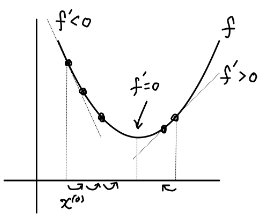


まず，1次元の最適化について考える．現在位置${x}^{(k)}$の微分（勾配）を$f'({x}^{(k)})$とすると，次のようなケースが考えられる．

- 微分が正（$f({x}^{(k)})' > 0$）の場合：最適解は現在位置より左側（負の方向）にあるため，$x$を$-f'$だけ負の方向に動かす．次の位置は，${x}^{(k+1)} = {x}^{(k)} - f'({x}^{(k)})$となる．
- 微分が負（$f({x}^{(k)})' < 0$）の場合：最適解は現在位置より右側（正の方向）にあるため，$x$を$-f'$だけ正の方向に動かす．次の位置は，${x}^{(k+1)} = {x}^{(k)} - f'({x}^{(k)})$となる．
- 微分が0（$f({x}^{(k)})' = 0$）の場合：この時点で最適解が得られているため，反復を終了する．



<https://www.geogebra.org/classic/vfs66wze>


以下のコードは，関数$f(x) = 2x^2 + 50$に対して，1次元の最急降下法の勾配方向を視覚的に示すものである．

In [ ]:
# 関数f(x)の定義
def f(x):
    return 2 * x**2 + 50
# f(x)の1次微分
def f_prime(x):
    return 4 * x

fig = plt.figure(figsize=(10,3))
axes = fig.subplots(1, 3, sharey=True)

# xの範囲
x = np.arange(-10, 10, 0.1)

# 3種類のx_kの位置と勾配の変化を描画
for ax, x_k, is_f_prime in zip(axes, [-5.0, 0.0, 5.0], ["<0", "=0", ">0"]):

    # 現在のx_kの位置をプロット
    ax.scatter(
        x_k, f(x_k),
        c="w",
        edgecolors="k",
    )
    # f(x)と接線f'(x)をプロット
    ax.plot(x, f(x))
    ax.plot(x, f_prime(x_k) * x + f(x_k) - f_prime(x_k) * x_k)

    ax.set_title(f"$x^k$ = {x_k}\n$f'(x^k)${is_f_prime}")
    ax.set_ylim(0,)

plt.show()

#### 1.2.1.1. <a id='toc1_2_1_1_'></a>[アルゴリズム](#toc0_)

最急降下法のアルゴリズムは次の通りである．

- 初期値$x^{(0)}$，ステップサイズ$\alpha \in R^+$を設定し，$k=0$とする．
- 収束するまで以下を繰り返す．
  1. 次の解を計算する：$$x^{(k+1)} = x^{(k)} - \alpha f'(x^{(k)})$$
  2. $k$を更新する：$k \leftarrow k+1$
- 最適解$\hat{x} = x^{(k)}$を出力する．

ここで，$\alpha$は**ステップサイズ**と呼ばれるパラメータである．通常，ステップサイズは定数として問題に応じて事前に設定され，反復中は固定される．ステップサイズが小さすぎると収束が遅くなり，大きすぎると解の近くで振動したり，場合によっては発散することがある．機械学習や深層学習の分野では，このステップサイズは**学習率**（learning rate; LR）とも呼ばれる．




また，ステップサイズを反復回数$k$に応じて変化させる方法も存在する．最急降下法が収束するためには，次の条件が必要である．

\begin{align*}
\lim_{k \to \infty} \alpha^{(k)} &= 0
\end{align*}

さらに，ある条件下での収束を保証するために次のような**Robbins–Monro条件**が知られている．

\begin{align*}
\sum_{k=0}^\infty \alpha^{(k)} = \infty, \quad
\sum_{k=0}^\infty (\alpha^{(k)})^2 < \infty
\end{align*}

- https://en.wikipedia.org/wiki/Stochastic_approximation#Robbins%E2%80%93Monro_algorithm

深層学習の分野では，学習率を動的に変更することが一般的であり，学習率を自動的に調整する[Adam](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html)や[RMSProp](https://docs.pytorch.org/docs/stable/generated/torch.optim.RMSprop.html)のようなアルゴリズムや，学習率をステップ状に減少させる手法（[stepLR](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html)）や，コサイン関数に従って徐々に減少させる手法（[cosine annealing](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html)）などが利用されている．


#### 1.2.1.2. <a id='toc1_2_1_2_'></a>[関数による実装](#toc0_)

ここでは，最適解問題を解くための関数を実装する．具体的には，ある関数`f`（目的関数）とその導関数`g`（勾配）を設定する．

In [ ]:
def f(x: float) -> float:
    """目的関数 f(x)"""
    return 0.05 * x**4 - 1.3 * x**2 + 0.8 * x + 4.75

def g(x: float) -> float:
    """勾配 f'(x), 目的関数の微分"""
    return 0.2 * x**3 - 2.6 * x + 0.8


これらの関数をプロットして，目的関数`f(x)`とその勾配`g(x)`がどのような形状を持つかを視覚化する．
この例では，`f`は非線形関数であり，複数の極小値を持つことがわかる．

In [ ]:
# xの範囲を指定
x_list = np.arange(-5, 5, 0.1)

fig = plt.figure()
axs = fig.subplots(2, sharex=True)

# 目的関数 f(x) をプロット
ax = axs[0]
ax.plot(x_list, f(x_list))
ax.set_ylabel("$f(x)$")

# f'(x) = g(x) をプロット
ax = axs[1]
ax.plot(x_list, g(x_list))
ax.set_xlabel("x")
ax.set_ylabel("$g(x)$")

plt.show()


#### 1.2.1.3. <a id='toc1_2_1_3_'></a>[クラスによる実装](#toc0_)

ここでは，目的関数とその勾配をまとめて扱うために，クラスを使った実装方法を説明する．クラスを用いると，目的関数とその1次導関数（勾配）や2次導関数を一つにまとめて扱うことができる．以下の例では，インスタンス`f()`を呼び出すことで目的関数の値を計算し，`f.grad()`で1次導関数，`f.second_grad()`で2次導関数を返すようにしている．また，後で説明するコールバック関数を扱うための仕組みも含めている．


In [ ]:
class Objective1D():
    """1次元の目的関数"""

    def do_callback(self, x, *callbacks):
        """コールバックを実行

        Args:
            x (np.ndarray): 入力 x
            callbacks (List[callable]): コールバック関数のリスト
        """
        for callback in callbacks:
            callback(x)

    def __call__(self, x: np.ndarray, *args) -> float:
        """目的関数 f(x) の値を計算

        Args:
            x (np.ndarray): 入力 x
            args (callable): コールバック関数

        Returns:
            np.ndarray: f(x) の出力
        """
        self.do_callback(x, *args)  # コールバックを実行
        return 0.05 * x**4 - 1.3 * x**2 + 0.8 * x + 4.75

    def grad(self, x: np.ndarray, *args) -> np.ndarray:
        """f'(x), 目的関数の勾配（1次導関数）を計算

        Args:
            x (np.ndarray): 入力 x

        Returns:
            np.ndarray: f(x) の勾配
        """
        return 0.2 * x**3 - 2.6 * x + 0.8

    def second_grad(self, x: np.ndarray, *args) -> np.ndarray:
        """f''(x), 2次導関数を計算

        Args:
            x (np.ndarray): 入力 x

        Returns:
            np.ndarray: f(x) の2次導関数
        """
        return 0.6 * x**2 - 2.6


このクラスのインスタンスを生成することで，関数$f(x)$やその導関数を簡単に扱うことができる．例えば次のようにインスタンスを生成する．

In [ ]:
f = Objective1D()


以下のコードでは，このインスタンス`f`を使って，目的関数$f(x)$，その1次導関数$f'(x)$，および2次導関数$f''(x)$をプロットしている．

In [ ]:
x_list = np.arange(-5, 5, 0.1)

fig = plt.figure()
axs = fig.subplots(3, sharex=True)

# 目的関数 f(x) をプロット
ax = axs[0]
ax.plot(x_list, f(x_list))
ax.set_ylabel("$f(x)$")

# f'(x) をプロット
ax = axs[1]
ax.plot(x_list, f.grad(x_list))
ax.set_ylabel("$f'(x)$")

# f''(x) をプロット
ax = axs[2]
ax.plot(x_list, f.second_grad(x_list))
ax.set_xlabel("x")
ax.set_ylabel("$f''(x)$")

plt.show()


以下のコードは，目的関数`f`を用いた勾配法の反復を関数`grad_decent_1d()`として実装したものである．ここでは，最適化アルゴリズムと目的関数を分離するために，目的関数`f`とその導関数`g`を引数として受け取る形にしている．このような設計は，数値計算ライブラリ（例：scipy）でも一般的であり，さまざまな目的関数に対して同じ最適化アルゴリズムを適用できる利点がある．
また，初期値`x0`やステップサイズ`alpha`も引数として指定できるようにしている．

なおこの実装では，反復回数が固定されているため，求められた解が必ずしも最適解に収束しているとは限らないことに注意する必要がある．

In [ ]:
def grad_decent_1d(
        f: callable,
        g: callable,
        x0: float,
        alpha: float = 0.1,
        maxiter: int = 100
) -> float:
    """1次元関数の勾配法による最小化

    Args:
        f (callable, ``f(x: float)``): 目的関数 f
        g (callable, ``g(x: float)``): 導関数 f'
        x0 (float): 初期値
        alpha (float, optional): ステップサイズ．デフォルトは0.1
        maxiter (int, optional): 最大反復回数．デフォルトは100

    Returns:
        float: 最適解 \hat{x}
    """
    x = x0  # 初期値を設定

    for k in range(maxiter):  # 指定された回数だけ反復
        x = x - alpha * g(x)  # 勾配法の更新式

        # 現在のx，f(x)，|g(x)|の値を表示
        print(f"x:{x: 20.16e}, f(x):{f(x): 20.16e}, |g(x)|:{abs(g(x)): 20.16e}")

    return x  # 得られた解を返す


この関数に目的関数と導関数，および初期値を入力として渡すと，求められた解が返り値として得られる．以下は使用例であり，反復ごとに$f(x)$と$|\nabla f(x)|$（つまり`|g(x)|`）が表示される．

In [ ]:
x0 = -1.0  # 初期値を設定

x = grad_decent_1d(
    f,          # 目的関数
    f.grad,     # 導関数
    x0,         # 初期値
    alpha=0.05, # ステップサイズ
    maxiter=15  # 最大反復回数
)

# 求められた解を表示
print("x", x)


#### 1.2.1.4. <a id='toc1_2_1_4_'></a>[終了条件の追加](#toc0_)

上記の実装は，最大反復回数`maxiter`まで反復するものであるが，通常は以下のような反復の終了条件を設定する．

- $|x_k - x_{k-1}| < \epsilon$：現在の値と前回の値の差がしきい値$\epsilon$未満である場合
- $|f'(x)| < \epsilon$：勾配の絶対値がしきい値$\epsilon$未満である場合

以下は，しきい値$\epsilon$を明示的に指定する代わりに，`np.isclose()`を用いて終了条件を判定する例である．

In [ ]:
def grad_decent_1d(
        f: callable,
        g: callable,
        x0: float,
        alpha: float = 0.1,
        maxiter: int = 100
) -> float:
    """1次元関数の勾配法による最小化（終了条件付き）

    Args:
        f (callable, ``f(x: float)``): 目的関数 f
        g (callable, ``g(x: float)``): 導関数 f'
        x0 (float): 初期値
        alpha (float, optional): ステップサイズ．デフォルトは0.1
        maxiter (int, optional): 最大反復回数．デフォルトは100

    Returns:
        float: 最適解 \hat{x}
    """
    x = x0
    x_pre = x  # 前回の値を保存する変数
    for k in range(maxiter):
        g_x = g(x)
        x = x - alpha * g_x  # 最急降下法の更新式

        f_x = f(x)
        g_abs = abs(g_x)
        x_diff = abs(x - x_pre)
        is_g_abs_small = np.isclose(g_abs, 0)
        is_x_diff_small = np.isclose(x_diff, 0)

        # 現在のx, f(x), |g(x)|の値と終了条件のチェック結果を表示
        print(f"k:{k} x:{x: 20.16e}, f(x):{f_x: 20.16e}, |g(x)|:{g_abs: 20.16e}")
        print(f"|xk - x_k-1|:{x_diff:e} is close to 0? {is_x_diff_small}")
        print(f"|g(x)|      :{g_abs:e} is close to 0? {is_g_abs_small}")

        # 終了条件のチェック
        if is_g_abs_small or is_x_diff_small:
            return x

        # 次の反復のために前回のxを更新
        x_pre = x

    return x


この関数に目的関数と導関数，および初期値を入力として渡すと，求められた解が返り値として得られる．以下は，終了条件が満たされているかを反復毎に表示する例である．やや冗長な表示であるため，出力が多くなって見にくい可能性がある．



In [ ]:
x0 = -2.0  # 初期値の設定

x = grad_decent_1d(
    f,          # 目的関数
    f.grad,     # 導関数
    x0,         # 初期値
    alpha=0.05  # ステップサイズ
)

# 最終的な解を表示
print("x:", x)


#### 1.2.1.5. <a id='toc1_2_1_5_'></a>[コールバック](#toc0_)

収束の様子を`print`文で確認することは実用上も重要であるが，コード中に多数の`print`文を埋め込むと出力が増えすぎて見づらくなる．そのため，各反復ごとに呼び出される任意のコールバック関数を作成し，収束情報をコールバック内で管理し，反復終了後にグラフとしてプロットする方法が一般的である．

以下のクラス`CacheXk1D`のインスタンス`cache_callback`は，最適化の反復中に現在の解`xk`を引数としてコールバック`cache_callback(xk)`が呼び出されると，その時点の解`xk`と目的関数値`f(xk)`，勾配の絶対値`abs(g(xk))`をリストに蓄積する．またプロット用に`name`も引数で受け取る．


In [ ]:
class CacheXk1D():
    """1次元のスカラー値をキャッシュするクラス"""

    def is_scalar(
            self,
            x: float | int | np.ndarray
        ) -> bool:
        """xがfloat, int, または単一要素のndarrayかを確認する"""
        return isinstance(x, float) \
            or isinstance(x, int) \
            or (isinstance(x, np.ndarray) \
                and x.ndim == 1 \
                and len(x) == 1)

    def __init__(
            self,
            f: callable,
            g: callable,
            x0: float | int | np.ndarray,
            name: str
        ) -> None:
        """コンストラクタ

        Args:
            f (callable, ``f(x: float)``): 目的関数 f
            g (callable, ``g(x: float)``): 導関数 f'
            x0 (float | np.ndarray): 初期値
            name (str): キャッシュ名
        """
        assert self.is_scalar(x0), "x must be float or int"
        self.__x_series = [x0]
        self.__f_series = [f(x0)]
        self.__g_series = [abs(g(x0))]
        self.f = f
        self.g = g
        self.__name = str(name)

    def __call__(self, xk: float) -> None:
        """xkをキャッシュに追加するコールバック

        Args:
            xk (float): 現在の解 x_k
        """
        assert self.is_scalar(xk), "x must be float or int"
        self.__x_series.append(xk)
        self.__f_series.append(self.f(xk))
        self.__g_series.append(abs(self.g(xk)))

    def get_x(self) -> np.ndarray:
        """x0, x1, ..., xkのリストを取得する"""
        return np.array(self.__x_series)

    def get_f(self) -> np.ndarray:
        """f(x0), f(x1), ..., f(xk)のリストを取得する"""
        return np.array(self.__f_series)

    def get_g(self) -> np.ndarray:
        """|f'(x0)|, |f'(x1)|, ..., |f'(xk)|のリストを取得する"""
        return np.array(self.__g_series)

    def get_name(self) -> str:
        """キャッシュ名を取得する"""
        return str(self.__name)

    def set_name(self, name:str) -> None:
        """キャッシュ名を設定する"""
        self.__name = str(name)

このオブジェクトを用いて最適化終了後に2つのプロットを作成する．リストに蓄積された値をプロットするために，以下のクラス`PlotCacheXk1D`のインスタンス`plot_cache`生成時にプロットする`cache`オブジェクトを与え，`plot_cache.plot_1d()`を呼び出す．内部では以下の2つの関数を用いてプロットを行う．

- `plot_convergence()`は，横軸に反復回数をとり，縦軸に`xk`，`f(xk)`，`abs(g(xk))`をプロットする
- `plot_x_over_f()`は，横軸に`x`，縦軸に`f(x)`をプロットし，目的関数$f(x)$を実線で描画するとともに，解の系列$x_0, x_1, \ldots$を丸でプロットする

In [ ]:
class PlotCacheXk1D():
    """CacheXk1Dオブジェクトをプロットするクラス"""

    def __init__(self, cache: CacheXk1D) -> None:
        assert isinstance(cache, CacheXk1D)
        self.cache = cache
        self.x_label = "iterations k"

    def plot_1d(self, draw_y0_line: bool = False) -> Dict[str, plt.figure]:
        """解の収束と目的関数の変化をプロットする

        Args:
            draw_y0_line (bool, optional): y=0の水平線を描画する（デフォルトはFalse）
        """
        return {
            "convergence": self.plot_convergence(),
            "x_over_f": self.plot_x_over_f(draw_y0_line)
        }


    def plot_convergence(self) -> plt.figure:
        """反復回数に対するx, f, および |f'| の3つのプロットを作成"""
        fig = plt.figure()
        axs = fig.subplots(3, sharex=True)

        ax = axs[0]
        ax.plot(self.cache.get_x(), ".-", label=self.cache.get_name())
        ax.set_ylabel("$x_k$")
        ax.legend()

        ax = axs[1]
        ax.plot(self.cache.get_f(), ".-", label=self.cache.get_name())
        ax.set_ylabel("$f(x_k)$")
        ax.legend()

        ax = axs[2]
        ax.plot(self.cache.get_g(), ".-", label=self.cache.get_name())
        ax.set_ylabel("$|f'(x_k)|$")
        ax.legend()

        ax.set_xlabel(self.x_label)

        plt.show()
        return fig

    def plot_x_over_f(
        self,
        draw_y0_line: bool,
        xmin: float = -5,
        xmax: float = 5,
        xstep: float = 0.2
    ) -> plt.figure:
        """f(x)と(x, f(x))の系列をプロット

        Args:
            draw_y0_line (bool): y=0の水平線を描画
            xmin (float, optional): xの範囲の最小値（デフォルトは-5）
            xmax (float, optional): xの範囲の最大値（デフォルトは5）
            xstep (float, optional): xの刻み幅（デフォルトは0.2）
        """
        fig = plt.figure()
        ax = fig.subplots()

        x_list = np.arange(xmin, xmax, xstep)
        ax.plot(x_list, f(x_list), label="$f(x)$")

        # 初期値 x0 の描画
        ax.scatter(
            self.cache.get_x()[0],
            self.cache.get_f()[0],
            color="w",
            s=150,
            edgecolors="k",
            label="$x_0$")

        # 解の系列の描画
        ax.scatter(
            self.cache.get_x(),
            self.cache.get_f(),
            color="r",
            label="$x_k$")

        # 最適解の描画
        ax.scatter(
            self.cache.get_x()[-1],
            self.cache.get_f()[-1],
            color="w",
            s=150,
            marker=",",
            zorder=-10,
            edgecolors="k",
            label="$\hat{x}$")

        # y=0の水平線を描画
        if draw_y0_line:
            ax.axhline(y=0, lw=1, color="k")

        ax.set_xlabel("x")
        ax.set_ylabel("f(x)")
        ax.grid()
        ax.legend()
        ax.set_title(self.cache.get_name())

        plt.show()
        return fig


1次元の最急降下法のクラスを，インスタンス`cache_callback`をコールバックとして受け取るように以下の関数`grad_decent_1d()`を修正する．この実装では，収束の情報がコールバックインスタンスに保持されるため，反復ごとの出力が不要になり，結果がわかりやすくなる．

In [ ]:
def grad_decent_1d(
        f: callable,
        g: callable,
        x0: float,
        alpha: float = 0.1,
        maxiter: int = 100,
        callback: callable = None
) -> float:
    """1次元関数の勾配法による最小化（コールバック版）

    Args:
        f (callable, ``f(x: float)``): 目的関数 f
        g (callable, ``g(x: float)``): 導関数 f'
        x0 (float): 初期値
        alpha (float, optional): ステップサイズ．デフォルトは0.1
        maxiter (int, optional): 最大反復回数．デフォルトは100
        callback (callable, ``callback(x: float)``, optional): コールバック関数．デフォルトはNone

    Returns:
        float: 最適解 \hat{x}
    """
    assert isinstance(x0, float)

    x = x0
    for k in range(maxiter):
        x = x - alpha * g(x)  # 最急降下法の更新式

        # コールバック関数が指定されている場合、現在のxをコールバックに渡す
        if callback:
            callback(x)

        # 終了条件：勾配の絶対値が小さい場合に終了
        if np.isclose(np.abs(g(x)), 0):
            return x

    return x


この関数を使って最適化を実行するコードは以下の通りである．ここでは，`CacheXk1D`のインスタンス`cache_callback`をコールバックとして渡し，収束情報を収集する．

In [ ]:
x0 = -1.0  # 初期値を設定
cache_callback = CacheXk1D(f, f.grad, x0, "Gradient Decent")

x = grad_decent_1d(
    f,              # 目的関数
    f.grad,         # 導関数
    x0,             # 初期値
    alpha=0.1,      # ステップサイズ
    callback=cache_callback  # コールバック関数
)

# 最終的な解を表示
print("x:", x)

この後，解の収束の様子を以下のコードでプロットする．


In [ ]:
plot_cache = PlotCacheXk1D(cache_callback)
figs = plot_cache.plot_1d()


1つ目のプロットから，目的関数値$f(x)$が減少し，勾配の絶対値$|f'(x)|$も徐々に小さくなっていることが確認できる．2つ目のプロットでは，初期値$x_0$から反復を始め，関数$f(x)$の谷を下り，最適解（極小値）$\hat{x}$ 付近に収束している様子が示されている．

#### 1.2.1.6. <a id='toc1_2_1_6_'></a>[scipy.optimize.minimize_scalar()](#toc0_)

[scipy](https://docs.scipy.org/)には，1次元の最適化問題を解くソルバーが実装されており，その1つが`scipy.optimize.minimize_scalar()`である．この関数は，引数として目的関数`f`を与えることで，1次元の関数の最適化を行う．

`minimize_scalar()`は微分情報を必要としない最適化手法を使用しており，初期値も内部で自動的に推測している．なお，非凸関数に対してこの関数を使用した場合，求められる解は局所解である．

- <https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html>
    > Minimization of scalar function of one variable.

`scipy.optimize.minimize_scalar()`はコールバックを引数で指定できないため，`args`にコールバックインスタンスを渡し，目的関数`f`の内部でコールバックを呼び出して反復情報を記録する方法を用いる．


In [ ]:
x0 = -1.0  # コールバックのための初期値．実際にはminimize_scalar()では使用されない．
cache_callback = CacheXk1D(f, f.grad, x0, "scipy minimize_scalar")

result = scipy.optimize.minimize_scalar(
    f,
    args=cache_callback
)
x = result.x
print(result)
print("x", x)


返り値には実行時の情報を持つオブジェクト（[OptimizeResult](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html)）が格納されている．このオブジェクトの主要な属性は以下の通りである．アルゴリズムによっては，存在しない属性もある．

- `x`: 得られた最適解
- `fun`: 最適解における目的関数値(function value)
- `jac`: 最適解における1次微分値(Jacobian)
- `hess_inv`: 最適解における2次微分の逆数 (Hessian inverse)
- `nfev`: 関数`f`の評価（呼び出し）回数(number of f() evaluations)
- `njev`: 導関数の評価（呼び出し）回数(number of Jacobian evaluations)
- `nit`: 反復回数(number of iterations)
- `success`: 最小化が成功したかどうか
- `message`: アルゴリズムからのメッセージ

実行後に，コールバックのインスタンスに保存された反復情報を表示し，収束の様子をプロットする．


In [ ]:
plot_cache = PlotCacheXk1D(cache_callback)
figs = plot_cache.plot_1d()


`minimize_scalar()`は最急降下法ではない最適化手法を用いているため，
1つ目のプロットでは，徐々に値が変化する様子はみられない．しかし，最終的には
目的関数値$f(x)$は減少し，勾配の絶対値$|f'(x)|$も小さくなっていることが確認できる．
2つ目のプロットでは，関数$f(x)$の局所解付近に収束している様子がわかる．ただし初期値はダミーである．

#### 1.2.1.7. <a id='toc1_2_1_7_'></a>[scipy.optimize.minimize()](#toc0_)

`scipy`のもう1つの最適化ソルバーに`scipy.optimize.minimize()`がある．この関数は1次元関数だけでなく，多次元関数の最適化も行うことができる．引数として，目的関数`fun`には`f`を，初期値`x0`には`x0`（多次元用なので`ndarray`で与える），そして導関数`jac`には`f.grad`を指定する．最適化アルゴリズムは指定しなければデフォルトのものが使われる．返り値のオブジェクトは，[OptimizeResult](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html)）と同様の形式で，さまざまな最適化結果が含まれる．

- <https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html>
    > Minimization of scalar function of one or more variables.

また，`scipy.optimize.minimize()`は引数`callback`にコールバックを指定でき，反復ごとに指定したコールバックが呼び出される．


In [ ]:
x0 = np.array([-1.0])  # 初期値をndarrayとして設定
cache_callback = CacheXk1D(f, f.grad, x0, "scipy minimize")

result = scipy.optimize.minimize(
    f,                  # 目的関数
    x0,                 # 初期値
    jac=f.grad,         # 導関数
    callback=cache_callback  # コールバック関数
)

# 最適化結果の表示
print("x:", result.x)
print(result)

デフォルトの最適化アルゴリズムは単純な最急降下法ではないため，少ない反復回数で効率的に最適解に到達する様子が確認できる．最適化が完了した後，コールバックのインスタンスに保持された反復情報をプロットして，解の収束の様子を確認する．

In [ ]:
plot_cache = PlotCacheXk1D(cache_callback)
figs = plot_cache.plot_1d()


1つ目のプロットでは，目的関数値$f(x)$が急激に減少し，勾配の絶対値$|f'(x)|$も急激に小さくなっていくことがわかる．また2つ目のプロットからは，初期値$x_0$からすぐに局所解に収束している様子がわかる．

##### 1.2.1.7.1. <a id='toc1_2_1_7_1_'></a>[カスタムソルバー](#toc0_)

`scipy.optimize.minimize()`には様々なソルバーが実装されているが，最急降下法のような単純な手法は含まれていない．しかし，自作のソルバーを設定することも可能であり，`scipy.optimize.minimize()`の`method`引数に自作ソルバーのインスタンスを指定する．

以下に，最急降下法を実装したカスタムクラスの例を示す．このクラスでは`__call__()`メソッド内にアルゴリズムを実装し，求められた最適解を`OptimizeResult`型で返す．

In [ ]:
class GradientDecent1D():
    """1次元関数の最急降下法を実装するソルバークラス"""

    def __init__(self, maxiter:int = 20, alpha:float = 0.01) -> None:
        """コンストラクタ

        Args:
            maxiter (int, optional): 最大反復回数．デフォルトは20
            alpha (float, optional): ステップサイズ．デフォルトは0.01
        """
        self.maxiter = maxiter
        self.alpha = alpha

    def __call__(
            self,
            f: callable,
            x0: float,
            jac: callable,
            callback: callable,
            **options
        ) -> OptimizeResult:
        """1次元の最急降下法

        Args:
            f (callable, ``f(x: float)``): 目的関数 f
            x0 (float): 初期値
            jac (callable, ``jac(x: float)``): 導関数 f'
            callback (callable, ``callback(x: float)``, optional): コールバック関数
            options (dict, optional): オプション

        Returns:
            OptimizeResult: 最小化の結果を格納したOptimizeResultオブジェクト
        """
        x = x0

        # maxiterをoptionsから取得し，未指定の場合はself.maxiterを使用
        maxiter = options.get('maxiter', self.maxiter)
        # alphaをoptionsから取得し，未指定の場合はself.alphaを使用
        alpha = options.get('alpha', self.alpha)

        for i in range(maxiter):
            jac_x = jac(x)
            x = x - alpha * jac_x  # 最急降下法の更新式

            if callback:
                callback(x)

            # 終了条件：勾配の絶対値が小さい場合に終了
            if np.isclose(np.abs(jac_x), 0):
                return OptimizeResult(
                    x=x,
                    fun=f(x),
                    success=True,
                    message="gradient decent converged successfully",
                    nit=i + 1
                )

        # 最大反復回数に到達した場合の結果
        return OptimizeResult(
            x=x,
            fun=f(x),
            success=False,
            message="gradient decent reached maxiter",
            nit=maxiter
        )

    def name(self):
        return '1D gradient decent'


このカスタムソルバーのインスタンスを以下のように`method=`に指定して使用する．

In [ ]:
x0 = np.array([-1.0])  # 初期値を設定
cache_callback = CacheXk1D(f, f.grad, x0, "gradient decent")

result = scipy.optimize.minimize(
    f,                  # 目的関数
    x0,                 # 初期値
    jac=f.grad,         # 導関数
    callback=cache_callback,  # コールバック関数
    method=GradientDecent1D(),  # カスタムソルバー
    options={'alpha': 0.1, 'maxiter': 150}  # オプション
)

# 最適化結果の表示
print("x:", result.x)
print(result)


以下のコードで解の収束の様子をプロットする．自作の最急降下法と同じオプションを指定しているため，結果も同様になっていることが確認できる．


In [ ]:
plot_cache = PlotCacheXk1D(cache_callback)
figs = plot_cache.plot_1d()


## 1.3. <a id='toc1_3_'></a>[1次の反復法（2次元以上）](#toc0_)

ここでは，勾配ベクトルを用いた多次元の最適化方法を説明する．多次元の場合でも基本的な考え方は同じであるが，可視化のために2次元の例がよく使われる．一般的には，ベクトル$\boldsymbol{x} \in R^n$に対するスカラー値関数$f(\boldsymbol{x}) \in R$を最適化する問題を考える．ここでは例として$n=2$の場合を取り上げ，$f(\boldsymbol{x})$の値を等高線で表現する．


### 1.3.1. <a id='toc1_3_1_'></a>[最急降下法](#toc0_)

1次元で説明した最急降下法は，勾配ベクトルを用いることで多次元に自然に拡張できる．勾配ベクトル$\nabla f$が，目的関数の値が最も増加する方向を表すため，その逆方向である$-\nabla f$が最も急に関数が減少する方向（最急降下方向）となる．したがって，現在の解を最急降下方向にステップサイズ$\alpha$倍して移動し，次の解を求める．


- 初期値$\boldsymbol{x}^{(0)}$, $k=0$, $\alpha \in R^+$
- 収束するまで以下を反復
    - $\boldsymbol{x}^{(k+1)} = \boldsymbol{x}^{(k)} - \alpha \nabla f(\boldsymbol{x}^{(k)})$




- [田村明久, 村松正和, 最適化法, 共立出版, 2002](https://www.kyoritsu-pub.co.jp/book/b10011120.html), p.102, 3.2.2 制約なし最適化の解法1: 最急降下法.
- [矢部博, 最適化とその応用, 数理工学社, 2006](https://www.saiensu.co.jp/search/?isbn=978-4-901683-34-0&y=2006), p.137, 4.5 最急降下法.
- [金森敬文, 鈴木大慈, 竹内一郎, 佐藤一誠, 機械学習のための連続最適化, 講談社, 2016](https://www.kspub.co.jp/book/detail/1529205.html), p.64, 4.4 最急降下法.


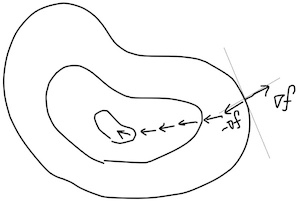

多次元の最適化問題の例として，以下の3つの関数を考える．1次元の場合と同様に，目的関数のクラスを作成し，そのインスタンス`f`を利用する．インスタンスを呼び出すと目的関数の値（スカラー）が得られ，そのメソッド`f.grad()`が勾配ベクトルを返すように設計している．また，後に2次微分を利用する方法を説明するために，`f.hessian()`も実装している．

In [ ]:
class StyblinskiTangFunction():
    """修正Styblinski-Tang関数

    https://en.wikipedia.org/wiki/Test_functions_for_optimization
    """

    def __call__(self, x: np.ndarray) -> float:
        """関数f(x)"""
        assert x.ndim == 1 and len(x) == 2
        val = 0.02 * (x[0]**4 + x[1]**4) - 0.5 * (x[0]**2 + x[1]**2) + 0.5 * (x[0] + x[1]) + 5
        return val

    def grad(self, x: np.ndarray) -> np.ndarray:
        """f(x)の勾配"""
        assert x.ndim == 1 and len(x) == 2
        grad0 = 0.08 * x[0]**3 - x[0] + 0.5
        grad1 = 0.08 * x[1]**3 - x[1] + 0.5
        return np.array([grad0, grad1])

    def hessian(self, x: np.ndarray) -> np.ndarray:
        """f(x)のヘッセ行列"""
        assert x.ndim == 1 and len(x) == 2
        h00 = 0.24 * x[0]**2 - 1
        h01 = h10 = 0
        h11 = 0.24 * x[1]**2 - 1
        return np.array([[h00, h01], [h10, h11]])


In [ ]:
class NonConvexFunction():
    """独自の非凸関数

    https://www.wolframalpha.com/input?i=Plot%5B%7B2+%28x%2B1%29%5E2+%2B+2+%28y%2B1%29%5E2+%2B+2%28x%2B1%29+%28y%2B1%29+-+2.5%28x%2B1%29+-+2.5+%28y%2B1%29++%2B+250+exp%28-%28%28x-2%29%5E2+%2B+%28y-2%29%5E2%29%2F30%29+%7D%2C+%7Bx%2C+-10%2C+10%7D%2C+%7By%2C+-10%2C+10%7D%5D&lang=ja
    """

    def __call__(self, x: np.ndarray) -> float:
        """関数f(x)"""
        assert x.ndim == 1 and len(x) == 2
        val = 2 * (x[0] + 1)**2 \
            + 2 * (x[1] + 1)**2 \
            + 2 * (x[0] + 1) * (x[1] + 1) \
            - 2.5 * (x[0] + 1) \
            - 2.5 * (x[1] + 1) \
            + 250 * np.exp(-((x[0] - 2)**2 + (x[1] - 2)**2) / 30) \
            + 100
        return val / 60

    def grad(self, x: np.ndarray) -> np.ndarray:
        """f(x)の勾配"""
        assert x.ndim == 1 and len(x) == 2
        val0 = -50 / 3 * (x[0] - 2) * np.exp(1 / 30 * (-(x[0] - 2)**2 - (x[1] - 2)**2)) + 4 * x[0] + 2 * x[1] + 3.5
        val1 = -50 / 3 * (x[1] - 2) * np.exp(1 / 30 * (-(x[0] - 2)**2 - (x[1] - 2)**2)) + 4 * x[1] + 2 * x[0] + 3.5
        return np.array([val0, val1]) / 60

    def hessian(self, x: np.ndarray) -> np.ndarray:
        """f(x)のヘッセ行列"""
        assert x.ndim == 1 and len(x) == 2
        val00 = 10 / 9 * (x[0]**2 - 4 * x[0] - 11) * np.exp(1 / 30 * (-(x[0] - 2)**2 - (x[1] - 2)**2)) + 4
        val01 = 10 / 9 * (x[0] - 2) * (x[1] - 2) * np.exp(1 / 30 * (-(x[0] - 4) * x[0] - (x[1] - 4) * x[1] - 8)) + 2
        val10 = 10 / 9 * (x[0] - 2) * (x[1] - 2) * np.exp(1 / 30 * (-(x[0] - 4) * x[0] - (x[1] - 4) * x[1] - 8)) + 2
        val11 = 10 / 9 * (x[1]**2 - 4 * x[1] - 11) * np.exp(1 / 30 * (-(x[0] - 2)**2 - (x[1] - 2)**2)) + 4
        return np.array([[val00, val01], [val10, val11]]) / 60


In [ ]:
class Quadratic2D():
    """二次関数の目的関数

        f(x) = 1/2 x^T A x + b^T x + c
    """

    def __init__(
            self,
            A: List[List[float]] = [
                [2.0, 1.0],
                [1.0, 2.0]],
            b: List[float] = [-3.5, 2.5],
            c: float = -1.2
        ):
        self.A = np.array(A)
        self.b = np.array(b)
        self.c = c

    def __call__(self, x: np.ndarray) -> float:
        """関数f(x)"""
        assert x.ndim == 1 and len(x) == 2
        val = x.T @ self.A @ x / 2 + self.b @ x + self.c
        return val

    def grad(self, x: np.ndarray) -> np.ndarray:
        """f(x)の勾配"""
        assert x.ndim == 1 and len(x) == 2
        return (self.A.T + self.A) @ x / 2 + self.b

    def hessian(self, x: np.ndarray) -> np.ndarray:
        """f(x)のヘッセ行列"""
        assert x.ndim == 1 and len(x) == 2
        return (self.A.T + self.A) / 2


以下のコードは，多次元の最急降下法を`grad_decent()`関数として実装するものである．1次元の場合と同様に，目的関数`f`とその勾配ベクトル`g`を引数として受け取り，さらに初期値`x0`やステップサイズ`alpha`も引数として与える．この関数の返り値は求められた局所解である．

In [ ]:
def grad_decent(
        f: callable,
        g: callable,
        x0: np.ndarray,
        alpha: float = 0.1,
        maxiter: int = 100,
) -> np.ndarray:
    """N次元の最急降下法

    Args:
        f (callable, ``f(x: np.ndarray)``): 目的関数 f
        g (callable, ``g(x: np.ndarray)``): 勾配ベクトル
        x0 (np.ndarray): 初期値
        alpha (float, optional): ステップサイズ．デフォルトは0.1
        maxiter (int, optional): 最大反復回数．デフォルトは100

    Returns:
        np.ndarray: 最適解 \hat{x}
    """
    assert g(x0).shape == x0.shape

    x = x0.copy()
    for k in range(maxiter):
        gx = g(x)
        x = x - alpha * gx  # 勾配ベクトルの逆方向へ移動

        # 反復ごとの解，目的関数の値，勾配のノルムを表示
        print(f"{k:02d}-th iter: x:{x}, f(x):{f(x): 20.16f}, ||g(x)||:{norm(gx): 20.16f}")

        # 勾配のノルムが小さければ収束と判定
        if np.isclose(norm(gx), 0):
            return x

    return x


目的関数を一つ選んで`f`とする．

In [ ]:
# f = StyblinskiTangFunction()
f = NonConvexFunction()
# f = Quadratic2D()


以下のコードを実行すると，反復ごとに解の更新が行われ，各反復で解`x`，目的関数値`f(x)`，および勾配ベクトルのノルム`||g(x)||`が表示される．最終的な解`x`は収束条件を満たした時点で返される．

In [ ]:
with np.printoptions(formatter={'float': '{: 20.16f}'.format}, suppress=True, linewidth=100):
    x0 = np.array([5.0, 1.0])
    x = grad_decent(
        f,
        f.grad,
        x0,
        alpha=0.4,
        maxiter=15
    )
    print("x", x)


上記では解$x^{(k)}$を`print`で表示しているだけであるが，2次元の場合には，解が収束する様子を可視化できる．そこで，目的関数$f(x)$を等高線として表示する関数`visualize_f()`を用意する．

この関数は，$x$と$y$の範囲（デフォルトでは$\pm 10$）で格子状の点における関数値を計算し，`matplotlib`の機能を用いて2D濃淡表示を行い，さらに等高線も表示する．表示範囲を変更したい場合には，`x_min`などの引数で指定可能である．

In [ ]:
def visualize_f(
        f: callable,
        ax: matplotlib.axis.Axis,
        x_min: float = -10,
        x_max: float = +10,
        y_min: float = -10,
        y_max: float = +10,
        levels: int = 20,
        cmap: plt.cm = plt.cm.gray_r,
        norm = None,
        ) -> matplotlib.axis.Axis:
    """目的関数 f の可視化

    Args:
        f (callable, 'f(x: np.ndarray)'): 目的関数 f(x)
        ax (matplotlib.figure.Axis): matplotlibのaxisオブジェクト
        x_min (float, optional): xの最小値．デフォルトは-10
        x_max (float, optional): xの最大値．デフォルトは+10
        y_min (float, optional): yの最小値．デフォルトは-10
        y_max (float, optional): yの最大値．デフォルトは+10
        levels (int, optional): 等高線の本数．デフォルトは20
    """

    # プロット範囲を設定
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # 格子状の点を作成
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]

    # 格子状の各点でf()を評価
    Z = np.array([f(x) for x in np.c_[XX.ravel(), YY.ravel()]])

    # 1次元配列を2次元に変換
    Z = Z.reshape(XX.shape)

    # 濃淡表示
    ax.pcolormesh(XX, YY, Z, norm=norm, cmap=cmap, zorder=-10)

    # 等高線を表示
    cs = ax.contour(
        XX,
        YY,
        Z,
        colors="k",
        linestyles="-",
        linewidths=1,
        levels=levels
    )
    ax.clabel(cs, colors="k", fontsize="xx-small")
    ax.set_aspect("equal")

    return ax

以下のコードは，目的関数をプロットする例である．ここでは`NonConvexFunction`を目的関数として選んでいるが，アルゴリズムの挙動をより深く理解するためには，目的関数を変更して試してみるとよい．

In [ ]:
# f = StyblinskiTangFunction()
f = NonConvexFunction()
# f = Quadratic2D()

fig = plt.figure(figsize=(5, 5))
ax = fig.subplots()

visualize_f(f, ax)

plt.show()


以下の`CacheXk`クラスは，最適化の反復過程で解の履歴を記録するコールバックである．このクラスは多次元用に設計されており，1次元用の`CacheXk1D`と異なり，解や勾配を`ndarray`で扱い，勾配の絶対値ではなくノルムを計算する．また，等高線で目的関数を可視化できるように設定されている．

In [ ]:
class CacheXk():
    """多次元の解xkの履歴を記録するクラス"""


    def __init__(
            self,
            f: callable,
            g: callable,
            x0: np.ndarray,
            name: str
        ):
        """コンストラクタ

        Args:
            f (callable, ``f(x: np.ndarray)``): 目的関数 f
            g (callable, ``g(x: np.ndarray)``): 導関数 f'
            x0 (np.ndarray): 初期値
            name (str): キャッシュ名
        """
        assert hasattr(x0, "copy")
        self.__x_series = [x0.copy()]
        self.__f_series = [f(x0)]
        self.__g_series = [norm(g(x0))]
        self.f = f
        self.g = g
        self.__name = str(name)

    def __call__(self, xk: np.ndarray) -> None:
        """xkをキャッシュに追加するコールバック

        Args:
            xk (np.ndarray): 現在の解 x_k
        """
        assert hasattr(xk, "copy")
        self.__x_series.append(xk.copy())
        self.__f_series.append(self.f(xk))
        self.__g_series.append(norm(self.g(xk)))

    def get_x(self) -> np.ndarray:
        """x0, x1, ..., xkの履歴を取得"""
        return np.array(self.__x_series)

    def get_f(self) -> np.ndarray:
        """f(x0), f(x1), ..., f(xk)の履歴を取得"""
        return np.array(self.__f_series)

    def get_g(self) -> np.ndarray:
        """||f'(x0)||, ||f'(x1)||, ..., ||f'(xk)||の履歴を取得"""
        return np.array(self.__g_series)

    def get_name(self) -> str:
        """キャッシュ名を取得"""
        return str(self.__name)

    def set_name(self, name:str) -> None:
        """キャッシュ名を設定"""
        self.__name = str(name)

`CacheXk`クラスの履歴をプロットするためのクラス`PlotCacheXk`を以下に定義する．このクラスは，1次元用の`PlotCacheXk1D`とほぼ同じであるが，目的関数を等高線でプロットし，図保存用に`fig`オブジェクトのdictを返している．

In [ ]:
class PlotCacheXk():
    """CacheXkオブジェクトをプロットするクラス"""


    def __init__(self, caches: List[CacheXk]) -> None:
        assert isinstance(caches, List), "should be a list of CacheXk"
        self.caches = caches
        self.f = caches[0].f
        self.x_label = "iterations k"
        self.colors = ['r', 'g', 'b', 'c', 'm', 'y']

    def plot_2d(self, figsize:tuple = (5, 5)) -> Dict[str, plt.figure]:
        """解の収束と目的関数の変化をプロットする

        Args:
            figsize (tuple, optional): 図のサイズ．デフォルトは(5, 5)

        Returns:
            Dict[str, plt.figure]: 各プロットのfigオブジェクト
        """
        return {
            "convergence": self.plot_convergence(),
            "x_over_f": self.plot_x_over_f(figsize)
        }


    def plot_convergence(self) -> plt.figure:
        """反復回数に対するx, f, および ||f'|| の3つのプロットを作成

        Returns:
            plt.figure: プロットのfigオブジェクト
        """

        fig = plt.figure()
        axs = fig.subplots(3, sharex=True)

        ax = axs[0]
        for cache, color in zip(self.caches, self.colors):
            ax.plot(cache.get_x()[:, 0], '.-', color=color,
                    label="x of " + cache.get_name())
            ax.plot(cache.get_x()[:, 1], '.--', color=color,
                    label="y of " + cache.get_name())
        ax.set_ylabel("$x_k$")
        ax.legend()

        ax = axs[1]
        for cache, color in zip(self.caches, self.colors):
            ax.plot(cache.get_f(), '.-', color=color, label=cache.get_name())
        ax.set_ylabel("$f(x_k)$")
        ax.legend()

        ax = axs[2]
        for cache, color in zip(self.caches, self.colors):
            ax.plot(cache.get_g(), '.-', color=color, label=cache.get_name())
        ax.set_ylabel("$\\| g(x_k) \\|$")
        ax.set_xlabel(self.x_label)
        ax.legend()

        plt.show()
        return fig

    def plot_x_over_f(self, figsize: tuple) -> plt.figure:
        """等高線付きのf(x)と(x, f(x))の系列を描画

        Args:
            figsize (tuple): 図のサイズ

        Returns:
            plt.figure: プロットのfigオブジェクト
        """
        fig = plt.figure(figsize=figsize)
        ax = fig.subplots()

        for cache, color in zip(self.caches, self.colors):
            x_series = cache.get_x()
            ax.scatter(
                x_series[0, 0],
                x_series[0, 1],
                color="w",
                s=50,
                edgecolors=color)
            ax.scatter(
                x_series[-1, 0],
                x_series[-1, 1],
                color=color,
                s=5,
                label=cache.get_name())
            ax.plot(
                x_series[:, 0],
                x_series[:, 1],
                marker='.',
                markersize=3,
                lw=1,
                color=color)

        ax = visualize_f(self.f, ax)

        ax.legend()
        plt.show()

        return fig


N次元の最急降下法のクラスを，インスタンス`cache_callback`をコールバックとして受け取るように修正したものが以下の関数`grad_decent()`である．

In [ ]:
def grad_decent(
        f: callable,
        g: callable,
        x0: np.ndarray,
        alpha: float = 0.1,
        maxiter: int = 100,
        callback: callable = None
) -> np.ndarray:
    """N次元の最急降下法（コールバック付き）

    Args:
        f (callable, ``f(x: np.ndarray)``): 目的関数 f
        g (callable, ``g(x: np.ndarray)``): 勾配ベクトル
        x0 (np.ndarray): 初期値
        alpha (float, optional): ステップサイズ．デフォルトは0.1
        maxiter (int, optional): 最大反復回数．デフォルトは10
        callback (callable, ``callback(x: np.ndarray)``, optional): コールバック関数．デフォルトはNone

    Returns:
        np.ndarray: 最適化された解 \\hat{x}
    """
    assert g(x0).shape == x0.shape

    x = x0.copy()
    for k in range(maxiter):
        gx = g(x)
        x = x - alpha * gx

        if callback:
            callback(x)

        if np.isclose(norm(gx), 0):
            break

    return x


では2次元の最急降下法を，インスタンス`cache_callback`をコールバックとして設定して，実行する．

In [ ]:
# x0 = np.array([-4.0, 2.0])
x0 = np.array([0, 7.5])
cache_callback = CacheXk(f, f.grad, x0, "gradient decent")

x = grad_decent(
    f,
    f.grad,
    x0,
    alpha=0.8,
    # maxiter=15,
    callback=cache_callback
)
print("x", x)
print("f(x)", f(x))


以下が解の収束の様子をプロットしたものである．


In [ ]:
# 解の収束の様子をプロット
plot_cache = PlotCacheXk([cache_callback])
figs = plot_cache.plot_2d()

## 図を保存するコード
# figs["convergence"].savefig("conter.pdf")
# figs["x_over_f"].savefig("x_over_f.pdf")


1つ目のプロットから，目的関数値が減少し，勾配ベクトルのノルムも徐々に小さくなっていることが確認できる．2つ目のプロットでは，初期値からスタートして目的関数の谷を下り，最適解付近に収束している様子が示されている．


#### 1.3.1.1. <a id='toc1_3_1_1_'></a>[初期値の異なる実行の比較を同時プロットする](#toc0_)

最急降下法のように反復計算で解を求める勾配法は，局所解に収束するため，得られる解は初期値に依存する．初期値が異なると異なる解に到達することがあるため，複数の異なる初期値から実行して比較すると，アルゴリズムの特性が理解しやすくなる．

以下のコードは，同じ目的関数に対して異なる初期値から実行する例である．初期値ごとに別々のコールバックインスタンスを生成して，解の履歴を記録している．

In [ ]:
x0_1 = np.array([-4.0, 2.0])  # 初期値1
x0_2 = np.array([0, 7.5])    # 初期値2
cache_callback_1 = CacheXk(f, f.grad, x0_1, name=r"GD, $\alpha$=0.8")
cache_callback_2 = CacheXk(f, f.grad, x0_2, name=r"GD, $\alpha$=0.2")

# 初期値1で最急降下法を実行
x_1 = grad_decent(
    f,
    f.grad,
    x0_1,
    alpha=0.8,
    callback=cache_callback_1
)
print("x", x_1)
print("f(x)", f(x_1))

# 初期値2で最急降下法を実行
x_2 = grad_decent(
    f,
    f.grad,
    x0_2,
    alpha=0.2,
    callback=cache_callback_2
)
print("x", x_2)
print("f(x)", f(x_2))


このまま`plot_cache.plot_2d()`を2回呼び出すと，別々にプロットされてしまう．しかし，異なる初期値から得られた解を比較するためには，同じプロットに重ねて表示することが望ましい．

このためには，`PlotCacheXk`のコンストラクタに`CacheXk`クラスのインスタンスをリストとして渡し，`plot_x_over_f()`を1回呼び出すことで，複数の解の系列を同時にプロットできる．
`plot_x_over_f()`内では，それぞれの解の系列を`plt.scatter`でプロットし，目的関数を`visualize_f()`で表示している．

- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
    > Plot y versus x as lines and/or markers.
- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
    > A scatter plot of y vs. x with varying marker size and/or color.


In [ ]:
plot_cache = PlotCacheXk([
    cache_callback_1,  # 初期値1に対応するコールバック
    cache_callback_2   # 初期値2に対応するコールバック
])
figs = plot_cache.plot_2d()  # 収束の様子と解の軌跡を同時にプロット


## 図を保存するコード
# figs["convergence"].savefig("conter.pdf")
# figs["x_over_f"].savefig("x_over_f.pdf")


1つ目のプロットから，初期値が異なると目的関数値の減少度合いは異なり，
2つ目のプロットからは，異なる初期値からスタートしているが，おなじ最適解付近に収束する様子は異なっていることがわかる．

### 1.3.2. <a id='toc1_3_2_'></a>[scipyの最適化ソルバー`scipy.optimize.minimize`](#toc0_)

`scipy.optimize.minimize()`は多次元の最適化にも利用でき，1次元の場合と同様に使うことができる．引数として，目的関数`fun`には`f`を，初期値`x0`には`x0`（今回は2次元の`ndarray`），勾配ベクトルの計算関数`jac`には`f.grad`を指定する．

多次元の最適化でもソルバー（最適化アルゴリズム）を指定することが可能で，自作のソルバーを指定することもできる．

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
    > Minimization of scalar function of one or more variables.

以下は，2次元の例で`scipy.optimize.minimize()`を使うコードである．


In [ ]:
# x0 = np.array([-4.0, 2.0])
x0 = np.array([0, 7.5])
cache_callback = CacheXk(f, f.grad, x0, "scipy default solver")
result = scipy.optimize.minimize(
    f,            # 目的関数
    x0,           # 初期値
    jac=f.grad,   # 勾配ベクトル
    callback=cache_callback  # コールバック関数
)
print("x", result.x)
print(result)


以下は解の収束の様子をプロットしたものである．デフォルトのソルバーは最急降下法ではなく後述するBFGS（準ニュートン法）であり，少ない反復回数で効率的に最適解に到達していることが確認できる．


In [ ]:
plot_cache = PlotCacheXk([cache_callback])
figs = plot_cache.plot_2d()



### 1.3.3. <a id='toc1_3_3_'></a>[最急降下法＋直線探索](#toc0_)

単純な最急降下法ではステップサイズが固定であるため，目的関数の形状によっては反復回数が非常に多くなることがある．そこで，現在の解$\boldsymbol{x}^{(k)}$において最急降下方向$- \nabla f(\boldsymbol{x}^{(k)})$を計算し，その方向に沿って目的関数が最も小さくなるまで進んだ点を次の解とする方法が考えられる．これを「直線探索（line search）」と呼び，最適なステップサイズ$\alpha$を求める1次元の最適化問題を解く．

- 収束するまで以下を反復
    1. $\boldsymbol{d}^{(k)} = - \nabla f(\boldsymbol{x}^{(k)})$
    1. $\alpha^{(k)} = \operatorname{argmin}_\alpha f(\boldsymbol{x}^{(k)} + \alpha \boldsymbol{d}^{(k)})$
    1. $\boldsymbol{x}^{(k+1)} = \boldsymbol{x}^{(k)} + \alpha^{(k)} \boldsymbol{d}^{(k)}$

この方法ではステップサイズ$\alpha$が動的に決定されるため，反復回数$k$は少なくなる．しかし，$f(\boldsymbol{x}^{(k)})$の評価回数が増えるため，全体の計算量は目的関数の計算コストに依存する．

- [矢部博, 最適化とその応用, 数理工学社, 2006](https://www.saiensu.co.jp/search/?isbn=978-4-901683-34-0&y=2006), p.130, 4.3 直線探索法.
- [金森敬文, 鈴木大慈, 竹内一郎, 佐藤一誠, 機械学習のための連続最適化, 講談社, 2016](https://www.kspub.co.jp/book/detail/1529205.html), p.55, 4.1 直線探索法.



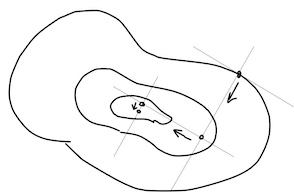


#### 1.3.3.1. <a id='toc1_3_3_1_'></a>[直線探索の手法](#toc0_)

直線探索には大きく分けて2種類の手法がある．





- **厳密な直線探索（exact line search）**
    勾配降下方向に沿って1次元最適化を行いステップサイズを選ぶ．
    - Brentの手法
        - https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brent.html
    - 2分法
    - 黄金分割法
        - https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.golden.html

- **非厳密な直線探索（inexact line search）**
    計算量を減らすために条件を満たす範囲でステップサイズを選ぶ．
    - Armijo条件（Armijo-Goldstein条件）
    - 曲率条件
    - Wolfe条件：Armijo＋曲率
        - https://en.wikipedia.org/wiki/Wolfe_conditions
    - バックトラック：Armijo＋まず大きく進んでから条件を満たすまで戻る
        - https://en.wikipedia.org/wiki/Backtracking_line_search


非厳密な直線探索の考え方は，反復法の各ステップで直線探索が行われることを前提にしている．つまり，ある反復の$k$回目で厳密に最適なステップサイズを求めなくても，次の$k+1$回目の反復で解はさらに改善される可能性が高いため，その時点での1次元最適化問題を正確に解く必要がないという考え方である．

その代わりに，直線探索専用のアルゴリズム（例えばWolfe条件やバックトラック法など）を用いることで，厳密な最適解を求めるための計算量を抑える工夫がされている．このような方法は全体の収束速度を確保しつつ，計算コストを削減できる点で利便性が高い．


#### 1.3.3.2. <a id='toc1_3_3_2_'></a>[scipyの1次元最適化を利用した直線探索](#toc0_)


以下の関数`grad_decent_with_ls()`では，最急降下法に直線探索を組み合わせた実装であり，直線探索にはscipyの関数を利用している．

- **厳密な直線探索**では，`scipy.optimize.minimize_scalar()`を用いる（デフォルトはBrentの手法）．
    - <https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html>
- **非厳密な直線探索**では，`scipy.optimize.line_search()`を用いる（強Wolfe条件に基づく手法）．
    - <https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.line_search.html>
    - 収束している場合，解が`None`になるため，その時点で`break`する

`exact_ls`引数で，厳密な直線探索（`scipy.optimize.minimize_scalar`）か非厳密な直線探索（`scipy.optimize.line_search`）かを指定する．


In [ ]:
def grad_decent_with_ls(
        f: callable,
        g: callable,
        x0: np.ndarray,
        maxiter: int = 100,
        callback: callable = None,
        exact_ls: bool = False,
        c2: float = 0.35,
) -> float:
    """直線探索を含む最急降下法

    Args:
        f (callable, ``f(x: np.ndarray)``): 目的関数 f
        g (callable, ``g(x: np.ndarray)``): 勾配ベクトル
        x0 (np.ndarray): 初期値
        maxiter (int, optional): 最大反復回数．デフォルトは10
        callback (callable, ``callback(x: np.ndarray)``, optional): コールバック関数．デフォルトはNone
        exact_ls (bool, optional): 厳密な直線探索を行うかどうか．デフォルトはFalse
        c2 (float, optional): 非厳密な直線探索のパラメータ．デフォルトは0.35
    Returns:
        np.ndarray: 最適解 \hat{x}
    """
    assert g(x0).shape == x0.shape

    def f_for_line_search(alpha):
        return f(x + alpha * d)

    x = x0.copy()
    nfev = 0  # 目的関数の評価回数
    njev = 0  # 勾配の評価回数
    nit = 0  # 反復回数
    for k in range(maxiter):
        d = -g(x)  # 最急降下方向（負の勾配方向）
        njev += 1

        if exact_ls:
            # 厳密な直線探索
            result = scipy.optimize.minimize_scalar(f_for_line_search)
            alpha = result.x
            nfev += result.nfev  # 直線探索での目的関数の評価回数
            if hasattr(result, "njev"):
                njev += result.njev  # 直線探索での勾配の評価回数
        else:
            # 非厳密な直線探索
            result = scipy.optimize.line_search(f, g, x, d, c2=c2)
            alpha = result[0]
            if alpha is None:  # 収束している場合にbreak
                break
            nfev += result[1]  # 直線探索での目的関数の評価回数
            njev += result[2]  # 直線探索での勾配の評価回数

        x = x + alpha * d
        nit += 1

        if callback:
            callback(x)

        if np.isclose(norm(d), 0):  # 勾配のノルムが小さければ終了
            break

    print("反復回数:", nit)
    print("f(x)の評価回数:", nfev)
    print("f'(x)の評価回数:", njev)
    return x


以下は厳密な直線探索を行うコードである．

In [ ]:
# x0 = np.array([-4.0, 2.0])
x0 = np.array([0, 7.5])
cache_callback_exact = CacheXk(f, f.grad, x0, "GD with exact line search")  # initialize
x = grad_decent_with_ls(
    f,
    f.grad,
    x0,
    callback=cache_callback_exact,
    exact_ls=True
)
print("x", x)
print("f(x)", f(x))


以下は非厳密な直線探索を行うコードである．

In [ ]:
# x0 = np.array([-4.0, 2.0])
x0 = np.array([0, 7.5])
cache_callback_inexact = CacheXk(f, f.grad, x0, "GD with inexact line search (c2=0.4)")  # initialize
x = grad_decent_with_ls(
    f,
    f.grad,
    x0,
    callback=cache_callback_inexact,
    exact_ls=False,
    c2=0.4,
)
print("x", x)
print("f(x)", f(x))


In [ ]:
# x0 = np.array([-4.0, 2.0])
x0 = np.array([0, 7.5])
cache_callback_inexact2 = CacheXk(f, f.grad, x0, "GD with inexact line search (c2=0.9)")  # initialize
x = grad_decent_with_ls(
    f,
    f.grad,
    x0,
    callback=cache_callback_inexact2,
    exact_ls=False,
    c2=0.9,
)
print("x", x)
print("f(x)", f(x))


以下は解の収束過程をプロットしたものである．

厳密な直線探索では，等高線に沿って勾配降下方向に最小値が計算されており，少ない反復回数で収束していることが確認できる．一方，非厳密な直線探索では1次元最適化が厳密ではなく，少しずつ目的関数値が下がるようになっているため，反復回数が多くなる場合がある（ただし，この挙動は`scipy.optimize.line_search()`のパラメータ（`c2`）に依存する）．

In [ ]:
plot_cache = PlotCacheXk([
    cache_callback_exact,
    cache_callback_inexact,
    cache_callback_inexact2,
])
plot_cache.x_label = "number of evaluations of f"
figs = plot_cache.plot_2d()


## 1.4. <a id='toc1_4_'></a>[1次の反復法の欠点](#toc0_)

最急降下法は勾配（1次の微分）情報のみを利用する手法であり，目的関数の形状によっては，直線探索を併用しても反復回数が非常に多くなる場合がある．その理由は，勾配方向が必ずしも最小値の方向とは一致しないためである．等高線と勾配方向は常に直交するため（証明は省略），目的関数が細長い形状をしている場合（目的関数のヘッセ行列の条件数が大きい場合），勾配方向と実際に関数値が減少する方向とのズレが大きくなりやすい．

こうしたズレを解消するためには，2次微分（曲率）の情報を利用する必要があり，その手法がニュートン法として知られている．

- <https://www.geogebra.org/m/em6meuct>


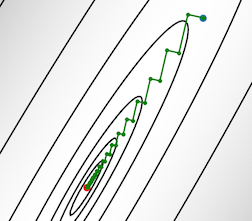

以下は，2次関数に対して厳密な直線探索を用いた最急降下法を適用した例である．この例から，勾配方向が関数値の減少方向と一致していないため，ジグザグな経路をたどっていることが確認できる．

In [ ]:
f_quad = Quadratic2D()

callback_list = []

x0_list = [
    np.array([-4.0, 2.0]),
    np.array([0, 7.5]),
]
for x0 in x0_list:

    cache_callback_exact_ls = CacheXk(f_quad, f_quad.grad, x0, f"GD with line search from {x0}")

    x = grad_decent_with_ls(
        f_quad,
        f_quad.grad,
        x0,
        maxiter=15,
        callback=cache_callback_exact_ls,
        exact_ls=True
    )
    # print("x", x)
    # print("f(x)", f(x))

    callback_list.append(cache_callback_exact_ls)

plot_cache = PlotCacheXk(callback_list)
figs = plot_cache.plot_2d()

## 1.5. <a id='toc1_5_'></a>[2次の反復法（1次元）](#toc0_)

まず1次元の場合を説明し，その後で多次元の場合に拡張する．

### 1.5.1. <a id='toc1_5_1_'></a>[ニュートン法](#toc0_)


ここで，目的関数$f$が2回微分可能であり，かつ$f'' \neq 0$であると仮定する．

ニュートン法（Newton's method）は，目的関数$f(x)$を現在の解$x^{(k)}$で2次関数に近似し，その最小値を次の解として更新する手法である．$f(x)$を2次関数で近似した結果を$\tilde{f}(x)$とすると，この関数の最小値は解析的に求めることができる．

- 収束するまで以下を反復
    1. $x^{(k)}$において$f$を2次関数$\tilde{f}^{(k)}$で近似する
    1. $x^{(k+1)} = \operatorname{argmin}_x \tilde{f}^{(k)}(x)$

実際の反復更新式は次のようになる．

- 収束するまで以下を反復
    1. $x^{(k+1)} = x^{(k)} - \alpha \dfrac{f'(x^{(k)})}{f''(x^{(k)})}$



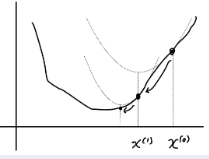

この更新式の導出は以下の通りである．

まず，目的関数$f(x)$を現在の解$x^{(k)}$周辺で2次のテイラー展開で近似する．

\begin{align*}
f(x) \simeq \tilde{f}(x) &=
f(x^{(k)})
+ f'(x^{(k)}) (x - x^{(k)})
+ \frac{1}{2} f''(x^{(k)}) (x - x^{(k)})^2
\end{align*}

次に，この2次近似関数$\tilde{f}$の微分が0となる解を求める．

\begin{align*}
\tilde{f}'(x) &= 0 \\
f'(x^{(k)}) + f''(x^{(k)}) (x - x^{(k)}) &= 0 \\
f'(x^{(k)}) + f''(x^{(k)}) x - f''(x^{(k)}) x^{(k)} &= 0 \\
f''(x^{(k)}) x &= - f'(x^{(k)}) + f''(x^{(k)}) x^{(k)} \\
x &= x^{(k)} - f'(x^{(k)})/f''(x^{(k)}) \\
\end{align*}

得られたこの解を$x^{(k+1)}$とする．

この導出からはステップサイズ$\alpha$は不要だが，実用上はステップサイズを設定することが多い．

#### 1.5.1.1. <a id='toc1_5_1_1_'></a>[実装](#toc0_)

ニュートン法の実装は，最急降下法における更新式に2次微分の情報を加え，その除算を行うようにすればよい（ゼロ除算などのエラー処理を無視すれば，シンプルに追加できる）．

In [ ]:
def newton_method_1d(
        f: callable,
        g: callable,
        gg: callable,
        x0: float,
        alpha: float = 0.1,
        maxiter: int = 100,
        callback: callable = None
) -> float:
    """ニュートン法（1次元）

    Args:
        f (callable, ``f(x)``): 目的関数 f
        g (callable, ``g(x)``): fの1次微分
        gg (callable, ``gg(x)``): fの2次微分
        x0 (float): 初期値
        alpha (float, optional): ステップサイズ. デフォルトは0.1
        maxiter (int, optional): 最大反復回数. デフォルトは100
        callback (callable, ``callback(x)``, optional): コールバック関数. デフォルトはNone

    Returns:
        float: 最適解 \hat{x}
    """
    assert isinstance(x0, float)

    x = x0
    for k in range(maxiter):
        x = x - alpha * g(x) / gg(x)  # ニュートン法の更新式

        if callback:
            callback(x)

        if np.isclose(np.abs(g(x)), 0):  # 勾配がほぼ0なら終了
            return x

    return x


次に，目的関数`f`とその初期値を設定してニュートン法を実行する．


In [ ]:
f = Objective1D()

x0 = -2.5  # -1.0, -2.0
cache_callback = CacheXk1D(f, f.grad, x0, "Newton's method")

x = newton_method_1d(
    f,
    f.grad,
    f.second_grad,
    x0,
    alpha=0.8,
    # maxiter=15,
    callback=cache_callback
)
print("x", x)
print("f(x)", f(x))


以下はニュートン法による解の収束の様子をプロットしたものである．


In [ ]:
plot_cache = PlotCacheXk1D(cache_callback)
figs = plot_cache.plot_1d()


プロットを見ると，ステップサイズにも依存するが，最急降下法よりも少ない反復回数で解に収束していることがわかる．

### 1.5.2. <a id='toc1_5_2_'></a>[ニュートン法の問題点](#toc0_)

ニュートン法は2次微分$f''(x)$を利用し，更新式の分母として使用する．そのため，変曲点で$f''(x) = 0$となる場合には0除算が発生し，更新が行えなくなるという問題がある．

さらに問題となるのは次のことである．最適解付近では下に凸であるという2次最適性条件である$f''(x) > 0$が成立するため収束するが，初期値が最適解から遠い場合には$f''(x) < 0$となることがある．この場合，更新式の分母が負の値になるため，更新方向が逆転し，極小値ではなく極大値に向かって収束してしまう．

したがって，ニュートン法は最適解に十分近く，$f''(x) > 0$が成立するような初期値から開始する場合にのみ，収束が保証される．逆に初期値が最適解から遠いと，収束が保証されない．

<https://www.geogebra.org/classic/nzkfbk69>

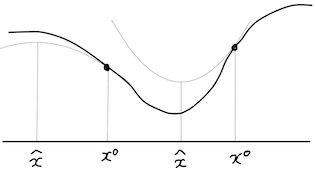

以下のコードでは，目的関数$f(x)$とその2次微分$f''(x)$を表示する．$f''(x) < 0$となる領域では，ニュートン法は極小値ではなく極大値に向かって収束してしまう．

In [ ]:
fig = plt.figure()
ax = fig.subplots()

x_list = np.arange(-5, 5, 0.1)
ax.plot(x_list, f(x_list), label="$f(x)$")
ax.plot(x_list, f.second_grad(x_list), label="$f''(x)$")

ax.hlines(y=0, xmin=x_list.min(), xmax=x_list.max(), colors="k")
ax.set_xlabel("x")
ax.grid()
ax.legend()

plt.show()


以下は初期値$x^{(0)} = -1.5$とした場合の結果である．このとき$f''(x^{(0)}) < 0$であるため，ニュートン法は極大値に収束していることが確認できる．

In [ ]:
x0 = -1.5
cache_callback = CacheXk1D(f, f.grad, x0, "Newton's method")

x = newton_method_1d(
    f,
    f.grad,
    f.second_grad,
    x0,
    alpha=0.8,
    # maxiter=15,
    callback=cache_callback)
print("x", x)
print("f(x)", f(x))


In [ ]:
plot_cache = PlotCacheXk1D(cache_callback)
figs = plot_cache.plot_1d()


このようにニュートン法は収束範囲が限定されるため，収束の局所性を解決するための簡単な手法として，次で説明する修正ニュートン法が用いられる．

### 1.5.3. <a id='toc1_5_3_'></a>[修正ニュートン法](#toc0_)

修正ニュートン法（modified Newton's method）は，ニュートン法の問題点を解決するために，更新式の分母にあたる2次微分の項が常に正となるように，定数を加える手法である．

- 収束するまで以下を反復
    1. $x^{(k+1)} = x^{(k)} - \alpha \dfrac{f'(x^{(k)})}{f''(x^{(k)}) + \lambda}$

この更新式は，$\lambda$が小さくなり0に近づくとニュートン法と一致し，$\lambda$が大きくなると（ステップサイズ$\alpha$も調整して打ち消し合うと）最急降下法と近い挙動を示す．

ニュートン法の問題点（更新方向が逆を向く問題）を解消するためには，$\lambda$の値が十分大きい必要がある．更新方向が勾配$f'(x^{(k)})$と同じ向きになるためには，分母が正であることが重要である．そのためには，次のように$f''(x)$の最小値より大きな$\lambda$を設定する必要がある．

\begin{align*}
\lambda > - \min_x f''(x) \Longrightarrow f''(x) + \lambda > 0
\end{align*}

ただし，実際には2次微分の最小値を正確に求めることは困難であるため，$\lambda$の値は経験に基づいて適切な値に設定し固定することが多い．

<https://www.geogebra.org/classic/mhmmyhpf>

以下のコードは$\lambda = 3$として，$f(x)$と$f''(x) + \lambda$をプロットし，$f''(x) + \lambda > 0$が満たされるように設定した例である．（なお`lambda`はPythonの予約語であるため，変数名として使用しない）


このプロットから，$\lambda$を加えたことで$f''(x) + \lambda$が常に正となっていることが確認できる．

In [ ]:
fig = plt.figure()
ax = fig.subplots()

lmd = 3.0  # 修正用定数

x_list = np.arange(-5, 5, 0.1)
ax.plot(x_list, f(x_list), label="$f(x)$")
ax.plot(x_list, f.second_grad(x_list) + lmd, label="$f''(x) + \lambda$")

ax.hlines(y=0, xmin=x_list.min(), xmax=x_list.max(), colors="k")
ax.set_xlabel("x")
ax.grid()
ax.legend()

ax.set_title(f"$\lambda$={lmd}")
plt.show()

#### 1.5.3.1. <a id='toc1_5_3_1_'></a>[実装](#toc0_)

以下は修正ニュートン法の実装である．定数$\lambda$はパラメータとして引数`lmd`で指定でき，デフォルトでは`lmd=0`としているため，このままでは通常のニュートン法と同一の動作になる．（なお，`lambda`はPythonの予約語であるため変数名として使用できない）

In [ ]:
def modified_newton_method_1d(
        f: callable,
        g: callable,
        gg: callable,
        x0: float,
        lmd: float = 0.0,
        alpha: float = 0.1,
        maxiter: int = 100,
        callback: callable = None
) -> float:
    """修正ニュートン法（1次元）

    Args:
        f (callable, ``f(x: float)``): 目的関数 f
        g (callable, ``g(x: float)``): fの1次微分
        gg (callable, ``gg(x: float)``): fの2次微分
        x0 (float): 初期値
        lmd (float, optional): 修正用のλ. デフォルトは0.0
        alpha (float, optional): ステップサイズ. デフォルトは0.1
        maxiter (int, optional): 最大反復回数. デフォルトは10
        callback (callable, ``callback(x: float)``, optional): コールバック関数. デフォルトはNone

    Returns:
        float: 最適解 \hat{x}
    """
    assert isinstance(x0, float)

    x = x0
    for k in range(maxiter):
        x = x - alpha * g(x) / (gg(x) + lmd)  # 修正ニュートン法の更新式

        if callback:
            callback(x)

        if np.isclose(np.abs(g(x)), 0):
            return x

    return x


次に，初期値と修正ニュートン法のパラメータを設定して実行する．


In [ ]:
x0 = -1.5
cache_callback = CacheXk1D(f, f.grad, x0, "modified Newton")

x = modified_newton_method_1d(
    f,
    f.grad,
    f.second_grad,
    x0,
    lmd=3.0,
    alpha=1.0,
    # maxiter=15,
    callback=cache_callback
)
print("x", x)
print("f(x)", f(x))


以下が修正ニュートン法による解の収束の様子をプロットしたものである．ニュートン法の場合には，最適解から変曲点以上離れてしまうと，更新方向が極大値へと向いてしまうが，修正ニュートン法の場合には，`lmd`を大きくすることによって勾配方向（極小値へと向かう方向）へ更新されていることがわかる．

In [ ]:
plot_cache = PlotCacheXk1D(cache_callback)
figs = plot_cache.plot_1d()


## 1.6. <a id='toc1_6_'></a>[2次の反復法（2次元以上）](#toc0_)

ここでは，勾配ベクトルを利用する多次元の最適化でのニュートン法について説明する．

### 1.6.1. <a id='toc1_6_1_'></a>[ニュートン法](#toc0_)

多次元の場合のニュートン法では，2次微分にあたるヘッセ行列$\nabla^2 f(\boldsymbol{x})$（しばしば$H$と記載）を利用する．

- [田村明久, 村松正和, 最適化法, 共立出版, 2002](https://www.kyoritsu-pub.co.jp/book/b10011120.html), p.105, 3.2.3 制約なし最適化の解法2: ニュートン法.
- [矢部博, 最適化とその応用, 数理工学社, 2006](https://www.saiensu.co.jp/search/?isbn=978-4-901683-34-0&y=2006), p.151, ニュートン法.
- [朝倉 数学ハンドブック 応用編, 朝倉書店, 2011.](https://www.asakura.co.jp/detail.php?book_code=11130) p.425, VI.2.2.2 ニュートン法.
- [最適化ハンドブック, 朝倉書店, 1995](https://www.amazon.co.jp/%E6%9C%80%E9%81%A9%E5%8C%96%E3%83%8F%E3%83%B3%E3%83%89%E3%83%96%E3%83%83%E3%82%AF-G-L-Nemhauser/dp/4254121024), p.10, 2.2 無制約最適化に対するNewton法.
- [金森敬文, 鈴木大慈, 竹内一郎, 佐藤一誠, 機械学習のための連続最適化, 講談社, 2016](https://www.kspub.co.jp/book/detail/1529205.html), p.78, 5 ニュートン法.


#### 1.6.1.1. <a id='toc1_6_1_1_'></a>[アルゴリズム](#toc0_)

1次元の場合と同様に，目的関数$f(\boldsymbol{x})$を現在の解$\boldsymbol{x}^{(k)}$周辺で2次近似すると，その近似関数$\tilde{f}(\boldsymbol{x})$は2次関数となり，最小値を解析的に求められる．ニュートン法は，この2次近似の最小値を次の解として使用する手法である．

- 収束するまで以下を反復
    1. $\boldsymbol{x}^{(k)}$において$f$を2次関数$\tilde{f}^{(k)}$で近似する
    1. $\boldsymbol{x}^{(k+1)} = \operatorname{argmin}_{\boldsymbol{x}} \tilde{f}^{(k)}(\boldsymbol{x})$

実際の反復更新式は以下のように書ける．

- 収束するまで以下を反復
    1. $\boldsymbol{d}^{(k)} = - (\nabla^2 f(\boldsymbol{x}^{(k)}))^{-1} \nabla f(\boldsymbol{x}^{(k)}) = - H^{-1} \nabla f(\boldsymbol{x}^{(k)})$
        - 実際には逆行列を計算するのではなく，$H \boldsymbol{d}^{(k)} = -\nabla f(\boldsymbol{x}^{(k)})$を解く
    2. $\boldsymbol{x}^{(k+1)} = \boldsymbol{x}^{(k)} + \alpha \boldsymbol{d}^{(k)}$


ここで，勾配方向$- \nabla f$と異なり，この更新方向$\boldsymbol{d} = -H^{-1}\nabla f$はニュートン方向と呼ばれる．また，更新量$\boldsymbol{d}^{(k)}$自体をニュートンステップ（Newton step），この更新式全体をニュートン反復（Newton iteration）と呼ぶ．


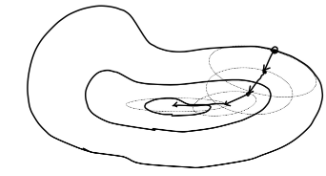

<https://www.geogebra.org/classic/yfytwb54>


1次元の場合と同様に，この更新式は以下のように導出できる．

まず，目的関数$f(\boldsymbol{x})$を現在の解$\boldsymbol{x}^{(k)}$周辺で2次のテーラー近似によって表現する．

\begin{align*}
f(\boldsymbol{x}) \simeq
\tilde{f}(\boldsymbol{x})
&=
f(\boldsymbol{x}^{(k)})
+ \nabla f(\boldsymbol{x}^{(k)})^T (\boldsymbol{x} - \boldsymbol{x}^{(k)})
+ \frac{1}{2} (\boldsymbol{x} - \boldsymbol{x}^{(k)})^T \nabla^2 f(\boldsymbol{x}^{(k)}) (\boldsymbol{x} - \boldsymbol{x}^{(k)})
\end{align*}

次に$\tilde{f}$の微分を0とする解を求める．

\begin{align*}
\nabla \tilde{f}(\boldsymbol{x}) &= \boldsymbol{0} \\
\nabla f(\boldsymbol{x}^{(k)}) + \nabla^2 f(\boldsymbol{x}^{(k)}) (\boldsymbol{x} - \boldsymbol{x}^{(k)}) &= \boldsymbol{0} \\
\nabla f(\boldsymbol{x}^{(k)}) + \nabla^2 f(\boldsymbol{x}^{(k)}) \boldsymbol{x} - \nabla^2 f(\boldsymbol{x}^{(k)}) \boldsymbol{x}^{(k)} &= \boldsymbol{0} \\
\nabla^2 f(\boldsymbol{x}^{(k)}) \boldsymbol{x} &= \nabla^2 f(\boldsymbol{x}^{(k)}) \boldsymbol{x}^{(k)} - \nabla f(\boldsymbol{x}^{(k)}) \\
\boldsymbol{x} &= \boldsymbol{x}^{(k)} - (\nabla^2 f(\boldsymbol{x}^{(k)}))^{-1}\nabla f(\boldsymbol{x}^{(k)}) \\
\end{align*}

この解を次の解$\boldsymbol{x}^{(k+1)}$とする．

なお，1次元の場合と同様に，実際の計算ではステップサイズ$\alpha$を用いることで，収束を調整することが多い．

#### 1.6.1.2. <a id='toc1_6_1_2_'></a>[実装](#toc0_)

1次元の場合と同様に，多次元のニュートン法も，最急降下法のコードに2次微分（ヘッセ行列）を用いた計算を追加することで実装できる．ここで，`np.linalg.inv()`を用いてヘッセ行列の逆行列を直接求めるのではなく，その代わりに`np.linalg.solve()`を用いて連立方程式を解いている．これは逆行列計算の非効率さや不安定さを避けるためである．


In [ ]:
def newton_method(
        f: callable,
        g: callable,
        H: callable,
        x0: np.ndarray,
        alpha: float = 0.1,
        maxiter: int = 100,
        callback: callable = None
) -> np.ndarray:
    """ニュートン法（多次元）

    Args:
        f (callable, ``f(x: np.ndarray)``): 目的関数 f
        g (callable, ``g(x: np.ndarray)``): 勾配ベクトル g
        H (callable, ``H(x: np.ndarray)``): ヘッセ行列 H
        x0 (np.ndarray): 初期値
        alpha (float, optional): ステップサイズ．デフォルトは 0.1
        maxiter (int, optional): 最大反復回数．デフォルトは 100
        callback (callable, ``callback(x: np.ndarray)``, optional): コールバック関数．デフォルトは None

    Returns:
        np.ndarray: 最適解 \hat{x}
    """
    n = len(x0)
    assert len(g(x0)) == n
    assert H(x0).shape == (n, n)

    x = x0.copy()
    for k in range(maxiter):
        gx = g(x)

        # ヘッセ行列を逆行列ではなくsolve()で計算して更新
        x = x - alpha * solve(H(x), gx)

        if callback:
            callback(x)

        if np.isclose(norm(gx), 0):
            return x

    return x


ここでは，3つの目的関数について，3つの異なる初期値からニュートン法を開始する．各初期値に対して，更新の過程（callback）を`callback_list`に保存しておき，`PlotCacheXk()`に渡している．

In [ ]:
for f in [
    Quadratic2D(),
    StyblinskiTangFunction(),
    NonConvexFunction(),
]:

    callback_list = []

    x0_list = [
        np.array([-7.0, 7.0]),
        np.array([-4.0, 2.0]),
        np.array([0, 7.5]),
    ]
    for x0 in x0_list:

        cache_callback_newton = CacheXk(f, f.grad, x0, f"Newton's method from {x0}")

        x = newton_method(
            f,
            f.grad,
            f.hessian,
            x0,
            alpha=0.5,
            # maxiter=50,
            callback=cache_callback_newton
        )
        print("x", x)
        print("f(x)", f(x))

        callback_list.append(cache_callback_newton)

    plot_cache = PlotCacheXk(callback_list)
    figs = plot_cache.plot_2d()

このプロットから，2次関数の場合はニュートン方向が最小値の方向を向き，効率的に収束している様子が確認できる．一方，非凸な関数の場合には，初期値によっては勾配方向とは異なる方向に更新される場合があり，初期値の影響が大きいことが分かる．

### 1.6.2. <a id='toc1_6_2_'></a>[ニュートン法の問題点と改良手法](#toc0_)


#### 1.6.2.1. <a id='toc1_6_2_1_'></a>[問題点１：時間計算量と空間計算量](#toc0_)

多次元のニュートン法の問題点の1つは，計算コストとメモリ使用量が非常に大きくなることである．最急降下法の勾配計算とメモリコストが$O(n)$であるのに対し，ニュートン法ではヘッセ行列の計算コストとメモリコストが$O(n^2)$になる．例えば次元が$n=1e6$の場合，32ビット（4バイト）floatで勾配ベクトルを保存するには3.8MBのメモリ容量しか必要としないが，密なヘッセ行列を保存するには3.7TBものメモリが必要である．さらに，ヘッセ行列の逆行列（つまるニュートン方程式を解くため）の計算には$O(n^3)$のコストがかかる．このため，次元数が非常に大きい問題（例：深層学習）ではニュートン法を用いるのは非現実的である．


In [ ]:
n = int(1e6)
itemsize = 4

# ベクトルのメモリ量を計算
nbytes = itemsize * n
print(
    f"{n}-d vector needs {nbytes / 1024**2:.02f} MB"
)

# ヘッセ行列のメモリ量を計算
nbytes = itemsize * (n**2)
print(
    f"{n}x{n} matrix needs {nbytes / 1024**2:.02f} MB"
    f" = {nbytes / 1024**3:.02f} GB"
    f" = {nbytes / 1024**4:.02f} TB"
)


#### 1.6.2.2. <a id='toc1_6_2_2_'></a>[問題点２：正定値性](#toc0_)

もう一つの問題は，最適解から遠い位置でヘッセ行列が正定値はなく負定値になる場合，ニュートン方向が降下方向ではなく上昇方向を指してしまうことである．これは1次元の場合と同様であり，最適解に十分近い初期値から始めれば収束が保証されるが，そうでない場合には収束が保証されない．

- <https://www.geogebra.org/m/jjdzed8z>
- <https://www.geogebra.org/m/xvaka6uc>


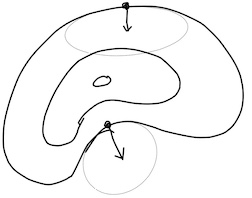

実対称行列$A$が正定値（positive definite）であるとは，任意のベクトル$\boldsymbol{x}$に対して以下が成り立つことを意味する．

\begin{align*}
\boldsymbol{x}^T A \boldsymbol{x} > 0
\end{align*}

また負定値（negative definite）とは
\begin{align*}
\boldsymbol{x}^T A \boldsymbol{x} < 0
\end{align*}
が成り立つことであり，正定値でも負定値でもない場合を不定値（indefinite）とよぶ．

行列$A$の固有値$\lambda$を考えると，正定値性の条件は以下のように変形できる．

\begin{align*}
\boldsymbol{x}^T A \boldsymbol{x} & > 0 \\
\boldsymbol{x}^T \lambda \boldsymbol{x} & > 0 \\
\lambda \| \boldsymbol{x} \|^2 & > 0 \\
\lambda & > 0 \\
\end{align*}

したがって，$A$の最小固有値$\lambda_\mathrm{min}$が正であれば$A$は正定値であるといえる．各点$\boldsymbol{x}$における目的関数$f$のヘッセ行列$\nabla^2 f(\boldsymbol{x})$の最小固有値をプロットすることで，どの位置でニュートン方向が降下方向とならなくなるかを可視化できる．




##### 1.6.2.2.1. <a id='toc1_6_2_2_1_'></a>[正定値性の可視化](#toc0_)

ニュートン法における降下方向を確認するために，スカラー値関数$f$のヘッセ行列の最小固有値を各点で計算し，各位置でヘッセ行列が正定値であるかを調べるクラスを定義する．

In [ ]:
class HessianPositiveDefinite(object):
    """目的関数fのヘッセ行列が正定値かどうかを判定するクラス
    """

    def __init__(self, f:callable):
        self.f = f

    def __call__(self, x) -> float:
        """指定した位置でのヘッセ行列の最小固有値を返す

        Args:
            x (ndarray): ヘッセ行列を計算する位置

        Returns:
            float: 最小固有値
        """
        H = f.hessian(x)
        min_eigenvalue = np.linalg.eigvalsh(H).min()
        return min_eigenvalue

このクラスのインスタンス`is_hessian_f_posdef`を利用して，関数`visualize_f()`を使ってヘッセ行列の正定値性を可視化した結果が以下である．薄い緑色で示されている領域は，少なくとも一つの固有値が負であることを意味している．この領域でニュートン方向を計算すると，降下方向ではない方向を指すことになる．


In [ ]:
f = NonConvexFunction()

fig = plt.figure(figsize=(5, 5))
ax = fig.subplots()

visualize_f(f, ax)

# def_hessian_fが正の領域を灰色に，負の領域を薄緑に着色
pos_neg_norm = BoundaryNorm(boundaries=[-50, 0, 50], ncolors=8)
is_hessian_f_posdef = HessianPositiveDefinite(f)
visualize_f(is_hessian_f_posdef, ax, norm=pos_neg_norm, cmap="Pastel2", levels=0)

plt.show()

ただし，上記の可視化処理は各点で固有値を計算するため計算量が非常に大きくなる．したがって，ある位置$\boldsymbol{x}$で逐一ヘッセ行列の固有値を計算して，ニュートン方向が降下方向として妥当かを確認する方法は，高次元空間では実用的ではない．


#### 1.6.2.3. <a id='toc1_6_2_3_'></a>[解決方法](#toc0_)

ニュートン法の問題を解決するためのいくつかの手法について説明する．それぞれ異なる観点から計算の効率化や収束性の向上を図る．

- **ヘッセ行列の修正**：修正ニュートン法
  - ヘッセ行列に補正を加え，常に降下方向を向くようにする．

- **ヘッセ行列の反復更新**：準ニュートン法
  - 勾配ベクトルでヘッセ行列を逐次近似する手法．

これらに加え，実際には信頼領域法と呼ばれる手法も広く用いられている．この手法は，次の解を探す範囲を制限することで安定性と収束性を向上させるものであり，`scipy.optimize.minimize`で実装されている．

- 信頼領域法（trust region method）
    - 現在の解$x^{(k)}$の近傍のみで次の解を探すという制約付き最適化問題を部分問題として解く
    - dog-leg法：現在の解$x^{(k)}$における最急降下方向とニュートン方向を組み合わせて次の解を探索する

- [金森敬文, 鈴木大慈, 竹内一郎, 佐藤一誠, 機械学習のための連続最適化, 機械学習プロフェッショナルシリーズ, 講談社, 2016](https://www.kspub.co.jp/book/detail/1529205.html), 第8章 信頼領域法, p133, 3.2.2 ドッグレッグ法, p137.
- [矢部博, 最適化とその応用, 数理工学社, 2006](https://www.saiensu.co.jp/search/?isbn=978-4-901683-34-0&y=2006), p.171, 信頼領域法, 図4.18 ドッグレッグ法.
- [最適化ハンドブック, 朝倉書店, 1995](https://www.amazon.co.jp/%E6%9C%80%E9%81%A9%E5%8C%96%E3%83%8F%E3%83%B3%E3%83%89%E3%83%96%E3%83%83%E3%82%AF-G-L-Nemhauser/dp/4254121024), p.40, 4.3 信頼領域法, p.47 ドッグレッグ法
- [最適化ハンドブック, 朝倉書店, 1995](https://www.amazon.co.jp/%E6%9C%80%E9%81%A9%E5%8C%96%E3%83%8F%E3%83%B3%E3%83%89%E3%83%96%E3%83%83%E3%82%AF-G-L-Nemhauser/dp/4254121024), p.40, 4.3 信頼領域法, p.45 近似的最適ステップ法
- <https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html>
    > - Method dogleg uses the dog-leg trust-region algorithm [5] for unconstrained minimization. This algorithm requires the gradient and Hessian; furthermore the Hessian is required to be positive definite.
    > - Method trust-ncg uses the Newton conjugate gradient trust-region algorithm [5] for unconstrained minimization. This algorithm requires the gradient and either the Hessian or a function that computes the product of the Hessian with a given vector. Suitable for large-scale problems.


#### 1.6.2.4. <a id='toc1_6_2_4_'></a>[修正ニュートン法](#toc0_)

多次元におけるニュートン法の改良として，修正ニュートン法を用いる．
最適解付近で目的関数が下に凸であることを保証する条件は，1次元では$f''(x) > 0$であったが，多次元の場合はヘッセ行列$\nabla^2 f(\boldsymbol{x})$が正定値であること，すなわち任意の$\boldsymbol{x}$に対して
$$
\boldsymbol{x}^T \nabla^2 f(\boldsymbol{x}) \boldsymbol{x} > 0
$$
が成り立つことである．そこで，更新式を次のように修正する．


- 収束するまで以下を反復
    1. $\boldsymbol{d}^{(k)} = - \left(\nabla^2 f(\boldsymbol{x}^{(k)}) + \lambda I \right)^{-1} \nabla f(\boldsymbol{x}^{(k)})$
       - $\left(\nabla^2 f(\boldsymbol{x}^{(k)}) + \lambda I \right)\boldsymbol{d}^{(k)} = - \nabla f(\boldsymbol{x}^{(k)})$を解く
    2. $\boldsymbol{x}^{(k+1)} = \boldsymbol{x}^{(k)} + \alpha^{(k)} \boldsymbol{d}^{(k)}$

ここで$I$は単位行列，$\lambda$は正の定数である．この更新式において$\lambda$が小さいとニュートン法に近づき，更新方向はニュートン方向となる．逆に$\lambda$が大きいと，最急降下法に近づき，更新方向は勾配方向に近づく．

この$\lambda$の値は，更新式における修正ヘッセ行列$\nabla^2 f(\boldsymbol{x}^{(k)}) + \lambda I$が正定値となるように設定する．ヘッセ行列$\nabla^2 f(\boldsymbol{x}^{(k)})$の固有値を$\lambda_1 \ge \lambda_2 \ge \cdots \ge \lambda_n$とすると，修正ヘッセ行列$\nabla^2 f(\boldsymbol{x}^{(k)}) + \lambda I$の固有値は$\lambda_1 + \lambda \ge \lambda_2 + \lambda \ge \cdots \ge \lambda_n + \lambda$となる．したがって，
\begin{align*}
\lambda_n + \lambda &> 0 \\
\lambda &> - \lambda_n \\
\end{align*}
と設定すれば，修正ヘッセ行列の固有値は常に正になり，正定値が保証される．実際には，全ての点$\boldsymbol{x}$においてヘッセ行列の固有値を求めることは現実的でないため，$\lambda$は経験的に適当な値に固定することが一般的である．




##### 1.6.2.4.1. <a id='toc1_6_2_4_1_'></a>[実装](#toc0_)

以下が修正ニュートン法の実装であり，$\lambda$を引数`lmd`で指定している（`lambda`はPythonの予約語なので使用しない）．

In [ ]:
def modified_newton_method(
        f: callable,
        g: callable,
        H: callable,
        x0: np.ndarray,
        lmd: float = 1.0,
        alpha: float = 0.1,
        maxiter: int = 100,
        callback: callable = None,
) -> np.ndarray:
    """修正ニュートン法

    Args:
        f (callable, ``f(x: np.ndarray)``): 目的関数f
        g (callable, ``g(x: np.ndarray)``): 勾配ベクトル
        H (callable, ``H(x: np.ndarray)``): ヘッセ行列
        x0 (np.ndarray): 初期値
        lmd (float, optional): 修正ニュートン法のlambda値．デフォルトは1.0.
        alpha (float, optional): ステップサイズ．デフォルトは0.1.
        maxiter (int, optional): 最大反復回数．デフォルトは100.
        callback (callable, ``callback(x: np.ndarray)``, optional): コールバック関数．デフォルトはNone.

    Returns:
        np.ndarray: 最適解 \hat{x}
    """
    n = len(x0)
    assert len(g(x0)) == n
    assert H(x0).shape == (n, n)

    x = x0.copy()
    # lambda * I を作成し、修正に用いる
    lmd_I = np.eye(n) * lmd

    for k in range(maxiter):
        gx = g(x)

        # 修正されたヘッセ行列で方程式を解き、更新を行う
        x = x - alpha * solve(H(x) + lmd_I, g(x))

        if callback:
            callback(x)

        if np.isclose(norm(gx), 0):
            return x

    return x


以下は，修正ニュートン法を使用して異なる初期値からの収束を確認するコード例である．
プロットから，ニュートン法では極小値に収束しなかった初期値から始めても，修正ニュートン法では極小値へ収束することが確認できる．
ただし目的関数に応じて適切な`lmd`値の設定が重要である．

In [ ]:
for f in [
    Quadratic2D(),
    StyblinskiTangFunction(),
    NonConvexFunction(),
]:

    callback_list = []

    x0_list = [
        np.array([-7.0, 7.0]),
        np.array([-4.0, 2.0]),
        np.array([0, 7.5]),
    ]
    for x0 in x0_list:

        cache_callback_newton = CacheXk(f, f.grad, x0, f"modified Newton from {x0}")

        x = modified_newton_method(
            f,
            f.grad,
            f.hessian,
            x0,
            alpha=0.8,
            lmd=3.0,
            # maxiter=50,
            callback=cache_callback_newton
        )
        print("x", x)
        print("f(x)", f(x))

        callback_list.append(cache_callback_newton)

    plot_cache = PlotCacheXk(callback_list)
    figs = plot_cache.plot_2d()

#### 1.6.2.5. <a id='toc1_6_2_5_'></a>[動的な修正ニュートン法](#toc0_)

修正ニュートン法では，固定の$\lambda$の値を経験的に与えるが，この値を試行錯誤で決定するのは計算コストの高い問題では現実的ではない．

$\lambda$の役割は，ニュートン方向が関数値を減少させない場合に，降下方向に向けることである．そこで，各反復で動的に$\lambda$を設定する方法が考えられる．具体的には，各点でヘッセ行列の最小固有値を計算し，その値が負の場合，正になるように$\lambda^{(k)}$を設定する．これにより，常に降下方向を向くような更新が期待できる．

<!-- 関数値が減少しなければ最急降下方向へ向くように$\lambda$を大きくし（つまり$\gamma_2 > 1$により$\gamma_2$倍する），
減少したならニュートン方向へ向くように$\lambda$を小さくする（$\gamma_1 < 1$により$\gamma_1$倍する）． -->





##### 1.6.2.5.1. <a id='toc1_6_2_5_1_'></a>[アルゴリズム](#toc0_)


- 初期値$x^{(0)}, k=0$
- 収束するまで以下を反復
    1. $\nabla^2 f(\boldsymbol{x}^{(k)})$の最小固有値$\lambda_{\mathrm{min}}$を求め，$\lambda^{(k)} = \max(0, -\lambda_{\mathrm{min}})$とする．
    2. $\boldsymbol{d}^{(k)} = - \left(\nabla^2 f(\boldsymbol{x}^{(k)}) + \lambda^{(k)} I \right)^{-1} \nabla f(\boldsymbol{x}^{(k)})$
       - $\left(\nabla^2 f(\boldsymbol{x}^{(k)}) + \lambda I \right)\boldsymbol{d}^{(k)} = - \nabla f(\boldsymbol{x}^{(k)})$を解く
    2. $\boldsymbol{x}^{(k+1)} = \boldsymbol{x}^{(k)} + \alpha^{(k)} \boldsymbol{d}^{(k)}$

実際には，固有値計算には計算量がかかるため，$(\nabla^2 f(\boldsymbol{x}^{(k)}) + \lambda^{(k)} I)$に対するコレスキー分解を反復する実装が使われる．

- [金森敬文, 鈴木大慈, 竹内一郎, 佐藤一誠, 機械学習のための連続最適化, 講談社, 2016](https://www.kspub.co.jp/book/detail/1529205.html), p.83, 修正ニュートン法.
- [G. A. F. Seber, C. J. Wild, Nonlinear Regression, John Wiley & Sons, 1989](https://onlinelibrary.wiley.com/doi/book/10.1002/0471725315), p.602, 13.3 Second-derivative (modified Newton) methods, 13.3.b. Adding to the Hessian.
    <!-- > Another way of modifying the Hessian involves adding a positive definite matrix A to H, namely $\bar{H} = H + A$, where A is large enough for $\bar{H}$ also to be positive definite. This idea was used by Levenberg [1994] and Marquardt [1963] in least-squares problems. The first application to the Newton method was by Goldfeld et al. [1966] who replaced $H^{(a)}$ by $\bar{H}^{(a)} = H^{(a)} + \nu^{(a)} I_p$. -->
- [矢部博, 最適化とその応用, 数理工学社, 2006](https://www.saiensu.co.jp/search/?isbn=978-4-901683-34-0&y=2006), p.171, 信頼領域法.
    <!-- > 部分問題(4.43)を解くことは，ある適当な非負の数$\lambda_k$に対して次の連立1次方程式 $(B_k + \lambda_k I) \boldsymbol{s}_k = - \nabla f(\boldsymbol{x}_k)$を解くことに関係する（中略）これはニュートン方程式に対するLevenberg-Marguardt（略）の修正に対応する． -->


##### 1.6.2.5.2. <a id='toc1_6_2_5_2_'></a>[実装](#toc0_)

以下が動的な修正ニュートン法の実装である．

In [ ]:
def dynamic_modified_newton(
        f: callable,
        g: callable,
        H: callable,
        x0: np.ndarray,
        alpha: float = 0.1,
        maxiter: int = 100,
        callback: callable = None,
) -> np.ndarray:
    """動的な修正ニュートン法

    Args:
        f (callable, ``f(x: np.ndarray)``): 目的関数f
        g (callable, ``g(x: np.ndarray)``): 勾配ベクトル
        H (callable, ``H(x: np.ndarray)``): ヘッセ行列
        x0 (np.ndarray): 初期値
        alpha (float, optional): ステップサイズ．デフォルトは0.1.
        maxiter (int, optional): 最大反復回数．デフォルトは10.
        callback (callable, ``callback(x: np.ndarray)``, optional): コールバック関数．デフォルトはNone.
    Returns:
        np.ndarray: 最適解 \hat{x}
    """
    n = len(x0)
    assert len(g(x0)) == n
    assert H(x0).shape == (n, n)

    x = x0.copy()
    I = np.eye(n)

    for k in range(maxiter):
        gx = g(x)
        Hx = H(x)
        # ヘッセ行列の最小固有値を求めて、負の固有値に対してλを調整
        lmd_min = np.linalg.eigvalsh(Hx)[0]
        lmd_k = max(0, -lmd_min * 2.0)  # 2を掛けて確実に正定値化

        # 修正ニュートン法の更新式
        x = x - alpha * solve(Hx + lmd_k * I, g(x))

        if callback:
            callback(x)

        if np.isclose(norm(gx), 0):
            return x

    return x


以下はニュートン法と同様の初期値で動的な修正ニュートン法を実行するコードである．可視化すると，動的な修正ニュートン法では，ニュートン法で極小値に収束しなかった初期値からでも極小値に収束していることがわかる．

In [ ]:
for f in [
    Quadratic2D(),
    StyblinskiTangFunction(),
    NonConvexFunction(),
]:

    callback_list = []

    x0_list = [
        np.array([-7.0, 7.0]),
        np.array([-4.0, 2.0]),
        np.array([0, 7.5]),
    ]
    for x0 in x0_list:

        cache_callback_newton = CacheXk(f, f.grad, x0, f"dynamic modified Newton from {x0}")

        x = dynamic_modified_newton(
            f,
            f.grad,
            f.hessian,
            x0,
            alpha=0.5,
            callback=cache_callback_newton
        )
        print("x", x)
        print("f(x)", f(x))

        callback_list.append(cache_callback_newton)

    plot_cache = PlotCacheXk(callback_list)
    figs = plot_cache.plot_2d()

### 1.6.3. <a id='toc1_6_3_'></a>[準ニュートン法](#toc0_)

修正ニュートン法は正定値性の問題を解決する一方で，ヘッセ行列の計算コストが大きいという課題がある．特に，最適化問題の次元が高い場合，ヘッセ行列の計算や保存に必要なリソースが膨大になる．例えば，パラメータの次元が2の場合にはヘッセ行列の計算コストは低く，簡単に可視化も可能である．しかし，パラメータ次元が数万や数百万になると，ヘッセ行列の計算や保存は現実的ではなくなる．

準ニュートン法（quasi-Newton method）は，ヘッセ行列そのものの計算を避け，その近似を反復的に更新することで，計算効率を改善する手法である．



- [田村明久, 村松正和, 最適化法, 共立出版, 2002](https://www.kyoritsu-pub.co.jp/book/b10011120.html), p.119, 3.2.7 制約なし最適化の解法3: 準ニュートン法.
- [矢部博, 最適化とその応用, 数理工学社, 2006](https://www.saiensu.co.jp/search/?isbn=978-4-901683-34-0&y=2006), p.156, 準ニュートン法.
- [朝倉 数学ハンドブック 応用編, 朝倉書店, 2011.](https://www.asakura.co.jp/detail.php?book_code=11130) p.427, VI.2.2.3 準ニュートン法.
- [金森敬文, 鈴木大慈, 竹内一郎, 佐藤一誠, 機械学習のための連続最適化, 講談社, 2016](https://www.kspub.co.jp/book/detail/1529205.html), p.107, 7 準ニュートン法.






#### 1.6.3.1. <a id='toc1_6_3_1_'></a>[アルゴリズム](#toc0_)

準ニュートン法では，ヘッセ行列やその逆行列を近似更新する2種類の方法がある．

- **ヘッセ行列を更新**
   - 初期値$\boldsymbol{x}^{(0)}$，正定値対称の初期ヘッセ行列$B^{(0)}$, $k=0$
   - 収束するまで以下を反復
      1. $\boldsymbol{d}^{(k)} = - (B^{(k)})^{-1} \nabla f(\boldsymbol{x}^{(k)})$
         - $B^{(k)} \boldsymbol{d}^{(k)} = -\nabla f(\boldsymbol{x}^{(k)})$を解く
      2. $\boldsymbol{x}^{(k+1)} = \boldsymbol{x}^{(k)} + \alpha^{(k)} \boldsymbol{d}^{(k)}$
      3. $\boldsymbol{s}^{(k)} = \boldsymbol{x}^{(k+1)} - \boldsymbol{x}^{(k)}$：移動量
      4. $\boldsymbol{y}^{(k)} = \nabla f(\boldsymbol{x}^{(k+1)}) - \nabla f(\boldsymbol{x}^{(k)})$：勾配変化量
      5. $B^{(k)}, \boldsymbol{s}^{(k)}, \boldsymbol{y}^{(k)}$を用いて$B^{(k+1)}$を更新

- **ヘッセ行列の逆行列を更新**
   - 初期値$\boldsymbol{x}^{(0)}$，正定値対称の初期ヘッセ逆行列$H^{(0)}$, $k=0$
   - 収束するまで以下を反復
      1. $\boldsymbol{d}^{(k)} = - H^{(k)} \nabla f(\boldsymbol{x}^{(k)})$
      2. $\boldsymbol{x}^{(k+1)} = \boldsymbol{x}^{(k)} + \alpha^{(k)} \boldsymbol{d}^{(k)}$
      3. $\boldsymbol{s}^{(k)} = \boldsymbol{x}^{(k+1)} - \boldsymbol{x}^{(k)}$：移動量
      4. $\boldsymbol{y}^{(k)} = \nabla f(\boldsymbol{x}^{(k+1)}) - \nabla f(\boldsymbol{x}^{(k)})$：勾配変化量
      5. $H^{(k)}, \boldsymbol{s}^{(k)}, \boldsymbol{y}^{(k)}$を用いて$H^{(k+1)}$を更新

上記に登場する
$\boldsymbol{s}^{(k)}$と$\boldsymbol{y}^{(k)}$は，勾配ベクトルの1次テーラー近似に由来する．
現在の解$\boldsymbol{x}^{(k)}$での勾配ベクトル$\nabla f(\boldsymbol{x}^{(k)})$を，
次の解$\boldsymbol{x}^{(k+1)}$周りでテーラー近似すると，

\begin{align*}
\nabla f(\boldsymbol{x}^{(k)}) &=
\nabla f(\boldsymbol{x}^{(k+1)})
+ \nabla^2 f(\boldsymbol{x}^{(k+1)}) (\boldsymbol{x}^{(k)} - \boldsymbol{x}^{(k+1)})
\\
\nabla f(\boldsymbol{x}^{(k)}) - \nabla f(\boldsymbol{x}^{(k+1)}) &=
\nabla^2 f(\boldsymbol{x}^{(k+1)}) (\boldsymbol{x}^{(k)} - \boldsymbol{x}^{(k+1)})
\\
\boldsymbol{y}^{(k)} &= \nabla^2 f(\boldsymbol{x}^{(k+1)}) \boldsymbol{s}^{(k)}
\end{align*}

となり，ヘッセ行列が正定値であることを仮定すると

\begin{align*}
(\boldsymbol{s}^{(k)})^T \boldsymbol{y}^{(k)} &= (\boldsymbol{s}^{(k)})^T \nabla^2 f(\boldsymbol{x}^{(k+1)}) \boldsymbol{s}^{(k)} > 0
\end{align*}

が得られる．これらの関係式が近似ヘッセ行列$B$でも成立するためには

$$
\nabla f(\boldsymbol{x}^{(k+1)}) - \nabla f(\boldsymbol{x}^{(k)}) \approx B^{(k)} (\boldsymbol{x}^{(k+1)} - \boldsymbol{x}^{(k)})
$$

が成り立つ必要があり，これをセカント条件（secant condition）と呼ぶ．



#### 1.6.3.2. <a id='toc1_6_3_2_'></a>[BFGS更新式](#toc0_)

BFGS（Broyden-Fletcher-Goldfarb-Shanno）法は，準ニュートン法の一つであり，近似ヘッセ行列またはその逆行列を更新する手法として広く利用されている．
以下は，ヘッセ行列を更新する場合のBFGS公式である．

$$
B^{(k+1)}
=
B^{(k)}
+
\frac{\boldsymbol{y}^{(k)} \boldsymbol{y}^{(k)T}}{\boldsymbol{y}^{(k)T} \boldsymbol{s}^{(k)}}
-
\frac{B^{(k)} \boldsymbol{s}^{(k)} \boldsymbol{s}^{(k)T} B^{(k)T} }{\boldsymbol{s}^{(k)T} B^{(k)} \boldsymbol{s}^{(k)}}
$$

この公式は，ヘッセ行列の近似を更新しつつ，次の2つの性質を保つ．

1. **正定値性**：ヘッセ行列の近似$B^{(k)}$が正定値であれば，$B^{(k+1)}$も正定値である．
2. **セカント条件**：$B^{(k+1)} \boldsymbol{s}^{(k)} = \boldsymbol{y}^{(k)}$を満たす．





#### 1.6.3.3. <a id='toc1_6_3_3_'></a>[実装](#toc0_)

準ニュートン法の実装にはいくつかの注意点がある．まず，反復回数が進むにつれて，解の更新移動量$\boldsymbol{s}^{(k)} = \boldsymbol{x}^{(k+1)} - \boldsymbol{x}^{(k)}$が非常に小さくなることがある．この場合，$\boldsymbol{s}^{(k)}$が除算の分母に使用される箇所で数値的不安定性が生じる可能性があるため，そのような場合には反復を打ち切る必要がある．

さらに，準ニュートン法の収束性はWolfe条件を満たすような直線探索を利用した場合に保証されることが多い．そのため，固定のステップサイズを用いるのではなく，（以下の実装では`scipy.optimize.line_search`を利用して）動的に$\alpha^{(k)}$を求める必要がある．

以下はBFGS更新式を用いた準ニュートン法の実装である．


In [ ]:
def quasi_newton_method(
        f: callable,
        g: callable,
        x0: np.ndarray,
        maxiter: int = 100,
        callback: callable = None,
) -> np.ndarray:
    """BFGS法による準ニュートン法の実装

    Args:
        f (callable, ``f(x: np.ndarray)``): 目的関数 f
        g (callable, ``g(x: np.ndarray)``): fの勾配ベクトル
        x0 (np.ndarray): 初期値
        maxiter (int, optional): 最大反復回数．デフォルトは100．
        callback (callable, ``callback(x: np.ndarray)``, optional): 解の進捗を記録するコールバック関数．デフォルトはNone．

    Returns:
        np.ndarray: 最適解 \hat{x}
    """

    def BFGS(B: np.ndarray, s: np.ndarray, y: np.ndarray) -> np.ndarray:
        """BFGS更新式を計算する．
        Args:
            B (np.ndarray): 現在のヘッセ行列の近似 B_k
            s (np.ndarray): 解の移動量 s_k
            y (np.ndarray): 勾配の変化量 y_k

        Returns:
            np.ndarray: 更新されたヘッセ行列 B_k+1
        """
        assert B.ndim == 2 and s.ndim == 1 and y.ndim == 1
        assert B.shape[0] == B.shape[1] == len(s) == len(y)
        Bs = B @ s
        return B + np.outer(y, y) / (y @ s) - np.outer(Bs, Bs) / (s @ Bs)


    n = len(x0)
    assert len(g(x0)) == n

    x = x0.copy()
    B = np.eye(n)  # 初期ヘッセ行列として単位行列を使用

    for k in range(maxiter):

        g_x = g(x)

        # ヘッセ行列の近似Bを用いて更新方向を計算
        d = solve(B, -g_x)

        # Wolfe条件を満たすステップサイズを取得
        result = scipy.optimize.line_search(f, g, x, d)
        alpha = result[0]
        if alpha is None:  # 収束判定
            break

        # 解の更新
        x = x + alpha * d

        # 移動量と勾配の変化量を計算
        s = alpha * d
        y = g(x) - g_x

        # ヘッセ行列の近似を更新
        B = BFGS(B, s, y)

        if callback:
            callback(x)

        if np.isclose(norm(s), 0) or np.isclose(norm(g_x), 0):
            return x

    return x


ニュートン法と同様の初期値でBFGSによる準ニュートン法を実行した結果が以下のコードである．

In [ ]:
for f in [
    Quadratic2D(),
    StyblinskiTangFunction(),
    NonConvexFunction(),
]:

    callback_list = []

    x0_list = [
        np.array([-7.0, 7.0]),
        np.array([-4.0, 2.0]),
        np.array([0, 7.5]),
    ]
    for x0 in x0_list:

        cache_callback_bfgs = CacheXk(f, f.grad, x0, f"BFGS from {x0}")

        x = quasi_newton_method(
            f,
            f.grad,
            x0,
            callback=cache_callback_bfgs
        )
        print("x", x)
        print("f(x)", f(x))

        callback_list.append(cache_callback_bfgs)

    plot_cache = PlotCacheXk(callback_list)
    figs = plot_cache.plot_2d()



#### 1.6.3.4. <a id='toc1_6_3_4_'></a>[L-BFGS](#toc0_)

準ニュートン法は，ヘッセ行列の計算を省略することで計算量を削減しているが，ヘッセ近似行列$B^{(k)}$の更新式によるメモリ使用量と計算量は依然として$O(n^2)$のオーダーである．

これをさらに改善するために，Limited-memory BFGS（L-BFGS）という手法が提案されている．L-BFGSは，過去の反復回数$m$回分の情報

- $\boldsymbol{s}^{(k)}, \boldsymbol{s}^{(k-1)}, \ldots, \boldsymbol{s}^{(k-m)}$
- $\boldsymbol{y}^{(k)}, \boldsymbol{y}^{(k-1)}, \ldots, \boldsymbol{y}^{(k-m)}$

を保存し，それを用いて更新を行うことで，ヘッセ近似行列全体を保持せずに計算を進める方法である．これにより，メモリ使用量と計算量は$O(nm)$に削減され，特に次元$n$が大きい場合に効果的である．
（実用上は$n=1000$に対して$m=10$程度でもよい）

- https://en.wikipedia.org/wiki/Limited-memory_BFGS
    > Limited-memory BFGS (L-BFGS or LM-BFGS) is an optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory.
- [矢部博, 最適化とその応用, 数理工学社, 2006](https://www.saiensu.co.jp/search/?isbn=978-4-901683-34-0&y=2006), p.166, 記憶制限準ニュートン法.


L-BFGSでは，メモリ使用量が大幅に削減されるため，準ニュートン法が高次元問題にも適用可能となる．そのため，`scipy.optimize.minimize()`のデフォルトソルバーとしても利用されており，制約のない最適化問題に対して非常に一般的な手法である．

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
    > If (`method` is) not given, chosen to be one of BFGS, L-BFGS-B, SLSQP, depending on whether or not the problem has constraints or bounds.


## 1.7. <a id='toc1_7_'></a>[共役勾配法](#toc0_)

共役勾配法（conjugate gradient, CG）は，もともと対称正定値行列$A$に対する連立一次方程式$A\boldsymbol{x} = \boldsymbol{b}$を解くために提案された手法である．その後，非線形最適化問題にも応用されている．

内積に基づく「直交」の定義は以下のように与えられる．

- 直交：$\langle \boldsymbol{u}, \boldsymbol{v} \rangle = \boldsymbol{u}^T \boldsymbol{v} = 0$

この定義は，内積の定義に依存する．
以下のように対称行列$A$を用いた内積も定義することができる．
この拡張された内積が0となる場合，$\boldsymbol{u}, \boldsymbol{v}$は「$A$について共役である」という．

- 共役：$\langle \boldsymbol{u}, \boldsymbol{v} \rangle_A
    = \langle A \boldsymbol{u}, \boldsymbol{v} \rangle
    = \boldsymbol{u}^T A \boldsymbol{v} = 0$

共役勾配法では，解の更新方向$\boldsymbol{d}^{(k)}$を過去の更新方向$\boldsymbol{d}^{(k-1)}, \boldsymbol{d}^{(k-2)}, \ldots$と直交（または共役）するように設定する．
各更新方向が直交（つまり独立）であるため，無駄のない空間の探索が可能となるという利点がある．また，高々$n$回の反復で厳密解を得ることができる．



- [金森敬文, 鈴木大慈, 竹内一郎, 佐藤一誠, 機械学習のための連続最適化, 講談社, 2016](https://www.kspub.co.jp/book/detail/1529205.html), p.96, 6 共役勾配法.
- [矢部博, 最適化とその応用, 数理工学社, 2006](https://www.saiensu.co.jp/search/?isbn=978-4-901683-34-0&y=2006), p.140, 共役勾配法.
- [朝倉 数学ハンドブック 応用編, 朝倉書店, 2011.](https://www.asakura.co.jp/detail.php?book_code=11130), p.293, V.2.5 共役勾配法（CG法）, p.430, VI.2.2.4 共役勾配法.
- [最適化ハンドブック, 朝倉書店, 1995](https://www.amazon.co.jp/%E6%9C%80%E9%81%A9%E5%8C%96%E3%83%8F%E3%83%B3%E3%83%89%E3%83%96%E3%83%83%E3%82%AF-G-L-Nemhauser/dp/4254121024), p.52, 5.2 共役勾配法.
- [水島二郎, 柳瀬眞一郎, 石原卓, 理工学のための数値計算法［第3版］, 数理工学社, 2019](https://www.saiensu.co.jp/search/?isbn=978-4-86481-061-6&y=2019), p.121, 5.6 共役勾配法（CG法）
- [菊地文雄, 数値計算の誤差と精度, 丸善出版, 2022](https://www.maruzen-publishing.co.jp/item/b304781.html), p.25, CG法.



### 1.7.1. <a id='toc1_7_1_'></a>[連立方程式ソルバーとしての共役勾配法](#toc0_)

まず，正定値対称行列$A$を係数行列とする連立方程式$A \boldsymbol{x} = \boldsymbol{b}$を解くための共役勾配法について説明する．この手法は，ニュートン法でのヘッセ行列に基づく方程式$H \boldsymbol{d} = \nabla f$を解いてニュートン方向$\boldsymbol{d}$を求める際にも利用され，その場合はNewton-CGと呼ばれる．

- https://docs.scipy.org/doc/scipy/reference/optimize.minimize-newtoncg.html
    > Minimization of scalar function of one or more variables using the Newton-CG algorithm.



#### 1.7.1.1. <a id='toc1_7_1_1_'></a>[基底展開](#toc0_)


丸め誤差がなければ，共役勾配法は$n$回の反復で連立方程式の厳密解を求めることができる．
これは丸め誤差がなくとも有限回の反復では打切り誤差が生じる反復法（Jacobi法，Gauss-Seidel法，SOR
法など）とは異なる性質である．

この共役勾配法の性質を理解するために，基底展開について考える．


##### 1.7.1.1.1. <a id='toc1_7_1_1_1_'></a>[直交の場合](#toc0_)

まず直交の場合を考える．
$n$次元空間$R^n$において正規直交基底
$\{\boldsymbol{v}_1, \ldots, \boldsymbol{v}_n \}$
が与えられているとする．このとき，
任意のベクトル$\boldsymbol{x}^* \in R^n$はこの基底を用いて一意に展開できる．

\begin{align*}
\boldsymbol{x}^*
= \alpha_1 \boldsymbol{v}_1 + \cdots + \alpha_n \boldsymbol{v}_n
= \sum_{i=1}^n \alpha_i \boldsymbol{v}_i
\end{align*}

ここで正規直交基底の性質
$\boldsymbol{v}_i^T \boldsymbol{v}_j = 0\ (i \neq j), \boldsymbol{v}_i^T \boldsymbol{v}_i = 1$
を用いると，展開係数$\alpha_i$は次のように計算できる．

正規直交基底の性質より，$i \neq j$では$\boldsymbol{v}_i^T \boldsymbol{v}_j = 0$であり，$i = j$では$\boldsymbol{v}_i^T \boldsymbol{v}_i = 1$である．
したがって，
両辺に左から$\boldsymbol{v}_i^T$をかければ
係数$\alpha_i$は以下のように得られる．

\begin{align*}
\boldsymbol{v}_i^T \boldsymbol{x}^*
= \boldsymbol{v}_i^T \sum_{j=1}^n \alpha_j \boldsymbol{v}_j
= \sum_{j=1}^n \alpha_j (\boldsymbol{v}_i^T \boldsymbol{v}_j)
= \alpha_i (\boldsymbol{v}_i^T \boldsymbol{v}_i)
= \alpha_i
\end{align*}


この結果，任意のベクトル$\boldsymbol{x}^*$は直交基底を用いて次のように一意に展開できる．
\begin{align*}
\boldsymbol{x}^* = \sum_{i=1}^n (\boldsymbol{v}_i^T \boldsymbol{x}^*) \boldsymbol{v}_i
\end{align*}


##### 1.7.1.1.2. <a id='toc1_7_1_1_2_'></a>[共役の場合](#toc0_)

次に，行列$A$に対して共役なベクトル集合$\{\boldsymbol{d}_1, \boldsymbol{d}_2, \ldots, \boldsymbol{d}_n\}$について考える．これらのベクトルが互いに一次独立であれば，直交基底の場合と同様に，任意のベクトル$\boldsymbol{x}^* \in \R^n$はこの基底を用いて一意に展開できる．

\begin{align*}
\boldsymbol{x}^*
= \sum_{i=1}^n \alpha_i \boldsymbol{d}_i
\end{align*}

行列$A$について共役であるとは，以下の性質を満たすことである．
$$
\boldsymbol{d}_i^T A \boldsymbol{d}_j = 0 \quad (i \neq j)
$$

この性質を用いて，上式の係数$\alpha_i$を求める．
両辺に左から$\boldsymbol{v}_i^T A$をかければ
係数$\alpha_i$は以下のようになる．

\begin{align*}
\boldsymbol{d}_i^T A \boldsymbol{x}^*
= \boldsymbol{d}_i^T A \sum_{j=1}^n \alpha_j \boldsymbol{d}_j
= \sum_{j=1}^n \alpha_j (\boldsymbol{d}_i^T A \boldsymbol{d}_j)
= \alpha_i (\boldsymbol{d}_i^T A \boldsymbol{d}_i)
\end{align*}

共役の性質より，$i \neq j$の場合は$\boldsymbol{d}_i^T A \boldsymbol{d}_j = 0$となり，$i = j$の場合のみが残る．
よってこの結果より，係数$\alpha_i$は次のように表される．

\begin{align*}
\alpha_i =
\frac{\boldsymbol{d}_i^T A \boldsymbol{x}^*}{\boldsymbol{d}_i^T A \boldsymbol{d}_i}
\end{align*}



ではここで，
このベクトル$\boldsymbol{x}^*$が連立方程式の解とすると，$A \boldsymbol{x}^* = \boldsymbol{b}$が成り立つため，
係数$\alpha_i$は次のようになる．

\begin{align*}
\alpha_i
= \frac{\boldsymbol{d}_i^T A \boldsymbol{x}^*}{\boldsymbol{d}_i^T A \boldsymbol{d}_i}
= \frac{\boldsymbol{d}_i^T \boldsymbol{b}}{\boldsymbol{d}_i^T A \boldsymbol{d}_i}
\end{align*}

したがって最適解$\boldsymbol{x}^*$は次のように表すことができる．

\begin{align*}
\boldsymbol{x}^*
= \sum_{i=1}^n
    \frac{\boldsymbol{d}_i^T \boldsymbol{b}}{\boldsymbol{d}_i^T A \boldsymbol{d}_i}
    \boldsymbol{d}_i
\end{align*}

つまり「$\{\boldsymbol{d}_1, \ldots, \boldsymbol{d}_n \}$が与えられれば」，
上式で最適解を表すことが（つまり求めることが）できる．

なおこの式は$A$の逆行列計算を含まないため，効率的である．
また$A$は行列ベクトル積の形$A \boldsymbol{d}_i$でのみ登場するため，
$A$が大規模疎行列の場合でも，この行列ベクトル積は容易に計算することができる．

次の課題は，$A$について共役なベクトル集合$\{\boldsymbol{d}_1, \ldots, \boldsymbol{d}_n\}$を効率的に求めることである．
特に，次元$n$が非常に大きい場合には，$n$よりも少ないベクトルで十分な近似を行うことが望ましい．このため，共役勾配法では反復法と直線探索を組み合わせることで，いかに示すように効率的にベクトルを構築していく．

#### 1.7.1.2. <a id='toc1_7_1_2_'></a>[連立方程式の最適化問題としての定式化](#toc0_)

連立方程式$A\boldsymbol{x} = \boldsymbol{b}$の解は以下の最適化問題の解と等価である．

\begin{align*}
& \min_{\boldsymbol{x}} \frac{1}{2} \| A\boldsymbol{x} - \boldsymbol{b} \|_2^2 \\
=& \min_{\boldsymbol{x}} \frac{1}{2} \boldsymbol{x}^T A \boldsymbol{x} - \boldsymbol{x}^T \boldsymbol{b}
\end{align*}
つまり目的関数は
\begin{align*}
f(\boldsymbol{x}) = \frac{1}{2} \boldsymbol{x}^T A \boldsymbol{x} - \boldsymbol{x}^T \boldsymbol{b}
\end{align*}
であり，その勾配は
\begin{align*}
\nabla f(\boldsymbol{x}) = A \boldsymbol{x} - \boldsymbol{b} = \boldsymbol{r}
\end{align*}
である．この問題では，上記のように勾配ベクトルは連立方程式の両辺の差，
つまり残差ベクトル$\boldsymbol{r}$でもあるため，ここでは残差$\boldsymbol{r}$と勾配$\nabla f(\boldsymbol{x})$を区別せず用いる．

##### 1.7.1.2.1. <a id='toc1_7_1_2_1_'></a>[ステップサイズ](#toc0_)

次の更新方向を$\boldsymbol{d}$とすると，勾配法の反復式は以下のように表される．
$$
\boldsymbol{x}^{(k+1)} = \boldsymbol{x}^{(k)} + \alpha^{(k)} \boldsymbol{d}
$$
ここで，ステップサイズ$\alpha^{(k)}$は以下の直線探索によって求められる．
$$
\alpha^{(k)} = \mathrm{arg}\min_\alpha f(\boldsymbol{x}^{(k)} + \alpha \boldsymbol{d})
$$

この直線探索問題を展開して解析的に解を求める．目的関数$f$は二次形式であるため，具体的には以下のようになる．
$$
f(\boldsymbol{x}^{(k)} + \alpha \boldsymbol{d}) = \frac{1}{2} (\boldsymbol{x}^{(k)} + \alpha \boldsymbol{d})^T A (\boldsymbol{x}^{(k)} + \alpha \boldsymbol{d}) - (\boldsymbol{x}^{(k)} + \alpha \boldsymbol{d})^T \boldsymbol{b}
$$

この式を展開すると次のように書き下せる．
$$
f(\boldsymbol{x}^{(k)} + \alpha \boldsymbol{d}) =
\frac{1}{2} (\boldsymbol{x}^{(k)T} A \boldsymbol{x}^{(k)} + 2\alpha \boldsymbol{x}^{(k)T} A \boldsymbol{d} + \alpha^2 \boldsymbol{d}^T A \boldsymbol{d})
- \boldsymbol{x}^{(k)T} \boldsymbol{b} + \alpha \boldsymbol{d}^T \boldsymbol{b}
$$

これを$\alpha$で微分してステップサイズを求める．
$$
\frac{\partial}{\partial \alpha} f(\boldsymbol{x}^{(k)} + \alpha \boldsymbol{d}) = \boldsymbol{x}^{(k)T} A \boldsymbol{d} + \alpha \boldsymbol{d}^T A \boldsymbol{d} - \boldsymbol{b}^T \boldsymbol{d}
$$

勾配$\boldsymbol{r}^{(k)} = A \boldsymbol{x}^{(k)} - \boldsymbol{b}$を用いると，さらに簡潔に表現できる．
$$
\frac{\partial}{\partial \alpha} f(\boldsymbol{x}^{(k)} + \alpha \boldsymbol{d}) = \boldsymbol{r}^{(k)T} \boldsymbol{d} + \alpha \boldsymbol{d}^T A \boldsymbol{d}
$$

最小値を求めるため，この式を0とおくと，ステップサイズ$\alpha^{(k)}$の厳密解は次のように与えられる．
$$
\alpha^{(k)} = \frac{-\boldsymbol{r}^{(k)T} \boldsymbol{d}}{\boldsymbol{d}^T A \boldsymbol{d}}
$$



##### 1.7.1.2.2. <a id='toc1_7_1_2_2_'></a>[方向ベクトル](#toc0_)

進むべき方向ベクトル$\boldsymbol{d}$が与えられた場合，上記のようにステップサイズ$\alpha$を計算し，反復式を用いて更新を行うことができる．では，その方向ベクトル$\boldsymbol{d}$をどのように選べばよいだろうか．

まず最初の方向ベクトル$\boldsymbol{d}^{(0)}$について考える．最急降下法を思い出すと，初期の方向として最急降下方向を選ぶのは自然な選択である．すなわち，
$$
\boldsymbol{d}^{(0)} = -\nabla f(\boldsymbol{x}^{(0)}) = \boldsymbol{b} - A \boldsymbol{x}^{(0)} = -\boldsymbol{r}^{(0)}
$$
とする．ここで$\boldsymbol{r}^{(0)}$は初期の残差ベクトルを表す．

この方向ベクトルを用いると，次のように初回の更新を行うことができる．
$$
\boldsymbol{x}^{(1)} = \boldsymbol{x}^{(0)} + \alpha^{(0)} \boldsymbol{d}^{(0)}
$$
ここで$\alpha^{(0)}$は直線探索によって得られる最適なステップサイズである．

次に，更新後の方向ベクトル$\boldsymbol{d}^{(1)}$をどのように選ぶかを考える．単純に次の最急降下方向である$-\nabla f(\boldsymbol{x}^{(1)})$を選ぶことも可能であるが，それでは$\boldsymbol{d}^{(0)}$と共役にはならない．

共役勾配法では，過去の方向と現在の方向が互いに共役であることが必要である．そのため，次の方向ベクトル$\boldsymbol{d}^{(1)}$は，以下で説明するように，現在の勾配方向を共役化して求める．共役化の具体的な方法は次に述べるが，まずは直交の場合を説明することで考え方を理解する．

##### 1.7.1.2.3. <a id='toc1_7_1_2_3_'></a>[直交の場合](#toc0_)

現在の解を$\boldsymbol{x}^{(k+1)}$とする．ここでの最急降下方向$- \nabla f(\boldsymbol{x}^{(k+1)})$を直前の更新方向$\boldsymbol{d}^{(k)}$に対して直交させるため，$\boldsymbol{d}^{(k)}$への射影を取り除く操作を行う．

射影の具体的な計算は，次のようになる．$\dfrac{\boldsymbol{d}^{(k)}}{\|\boldsymbol{d}^{(k)}\|}$は$\boldsymbol{d}^{(k)}$方向の単位ベクトルを表しており，$- \nabla f(\boldsymbol{x}^{(k+1)})^T \dfrac{\boldsymbol{d}^{(k)}}{\|\boldsymbol{d}^{(k)}\|}$はその方向への射影長さ（スカラー）である．よって，射影成分は次のように表される．

$$
- \nabla f(\boldsymbol{x}^{(k+1)})^T \frac{\boldsymbol{d}^{(k)}}{\|\boldsymbol{d}^{(k)}\|}
\cdot
\frac{\boldsymbol{d}^{(k)}}{\|\boldsymbol{d}^{(k)}\|}
=
\frac{- \nabla f(\boldsymbol{x}^{(k+1)})^T \boldsymbol{d}^{(k)}}{\boldsymbol{d}^{(k)}{}^T \boldsymbol{d}^{(k)}} \boldsymbol{d}^{(k)}
$$

この射影成分を現在の最急降下方向$- \nabla f(\boldsymbol{x}^{(k+1)})$から引くと，直前の方向$\boldsymbol{d}^{(k)}$に直交する成分のみが残る．これを次の更新方向$\boldsymbol{d}^{(k+1)}$とする．





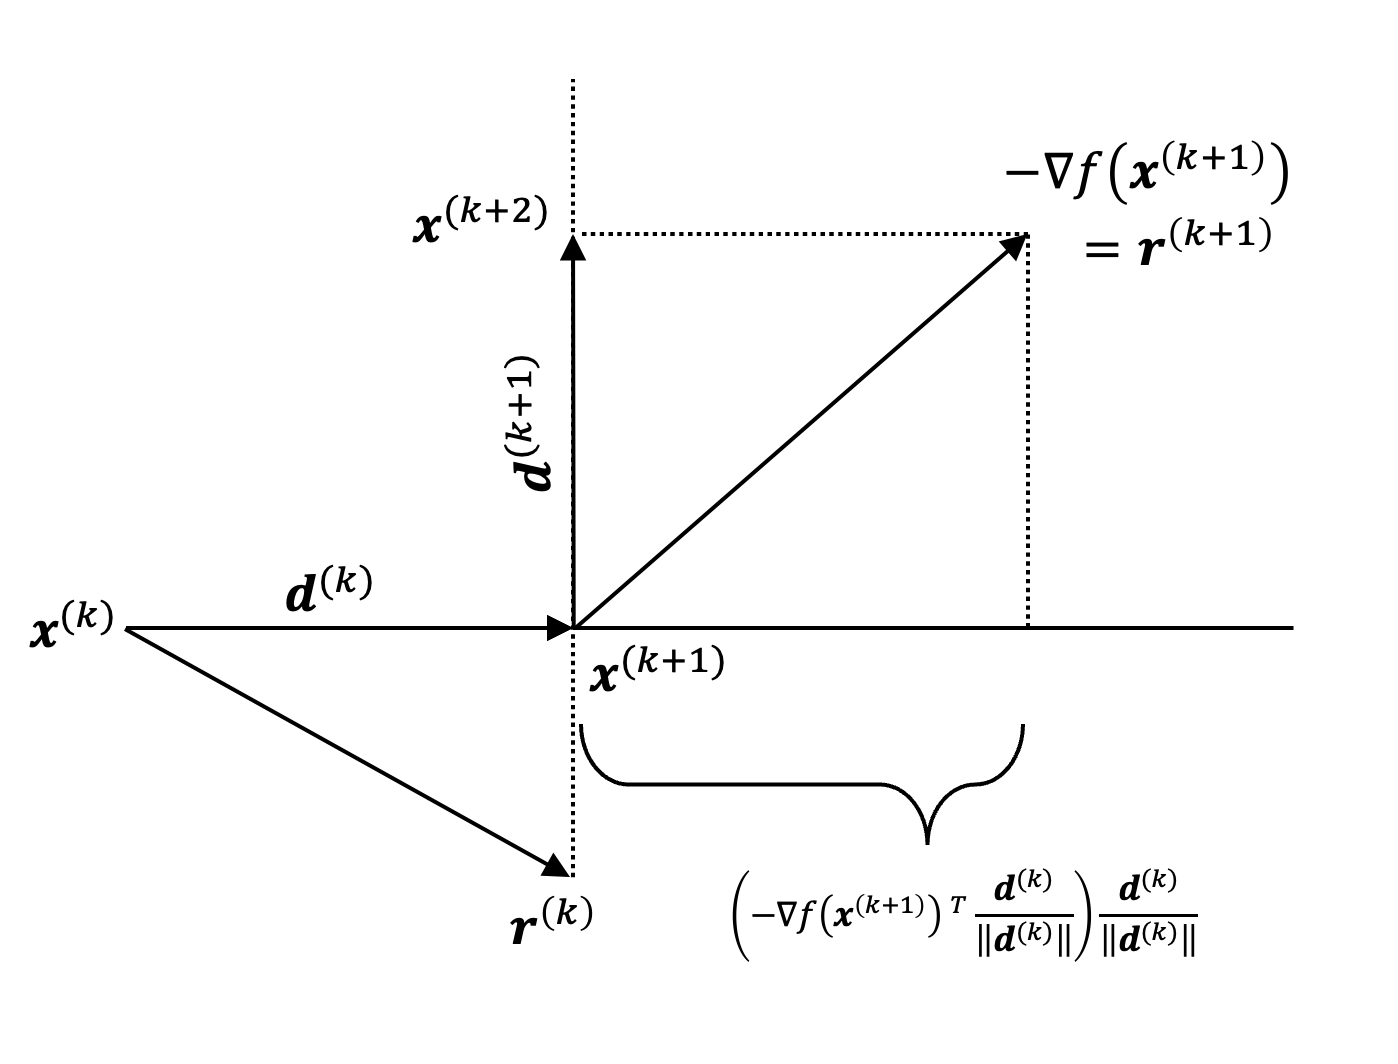


更新方向$\boldsymbol{d}^{(k+1)}$は次のように求められる．

\begin{align*}
\boldsymbol{d}^{(k+1)}
&=
- \nabla f(\boldsymbol{x}^{(k+1)}) -
\frac{
- \nabla f(\boldsymbol{x}^{(k+1)})^T
\boldsymbol{d}^{(k)}
}{\boldsymbol{d}^{(k)}{}^T \boldsymbol{d}^{(k)}}
\boldsymbol{d}^{(k)}
\\
&=
- \nabla f(\boldsymbol{x}^{(k+1)})
+
\frac{
\nabla f(\boldsymbol{x}^{(k+1)})^T
\boldsymbol{d}^{(k)}
}{\boldsymbol{d}^{(k)}{}^T \boldsymbol{d}^{(k)}}
\boldsymbol{d}^{(k)}
\end{align*}

さらに，残差ベクトル$\boldsymbol{r}^{(k+1)} = -\nabla f(\boldsymbol{x}^{(k+1)})$を用いると，

$$
\boldsymbol{d}^{(k+1)}
=
- \boldsymbol{r}^{(k+1)}
+
\frac{
\boldsymbol{r}^{(k+1)T}
\boldsymbol{d}^{(k)}
}{\boldsymbol{d}^{(k)}{}^T \boldsymbol{d}^{(k)}}
\boldsymbol{d}^{(k)}
$$

ここで，

$$
\beta^{(k)} =
\frac{
\boldsymbol{r}^{(k+1)T}
\boldsymbol{d}^{(k)}
}{\boldsymbol{d}^{(k)}{}^T \boldsymbol{d}^{(k)}}
$$

と定義すると，次の更新式が得られる．

$$
\boldsymbol{d}^{(k+1)}
=
- \boldsymbol{r}^{(k+1)}
+
\beta^{(k)}
\boldsymbol{d}^{(k)}
$$

この式によって，次の方向ベクトル$\boldsymbol{d}^{(k+1)}$を効率的に計算できる．

以上の更新方法により，最急降下方向を元にして，直交性を保ちつつ解を反復的に求めることができる．次は，直交の場合のアイデアを共役へ拡張する．

##### 1.7.1.2.4. <a id='toc1_7_1_2_4_'></a>[共役の場合](#toc0_)


上記の直交の場合の導出において，内積の定義を標準内積から$A$による内積に変更することで，共役の場合の結果が得られる．ここで，$A$による内積と，それから誘導されるノルムは以下のように定義される．

\begin{align*}
\langle \boldsymbol{u}, \boldsymbol{v} \rangle_A = \boldsymbol{u}^T A \boldsymbol{v}
\\
\| \boldsymbol{u} \|_A = \boldsymbol{u}^T A \boldsymbol{u}
\end{align*}

この変更により，射影成分は次のように表される．

\begin{align*}
&
- \nabla f(\boldsymbol{x}^{(k+1)})^T A \frac{\boldsymbol{d}^{(k)}}{\| \boldsymbol{d}^{(k)} \|_A}
\cdot
\frac{\boldsymbol{d}^{(k)}}{\| \boldsymbol{d}^{(k)} \|_A}
\\
&=
\frac{- \nabla f(\boldsymbol{x}^{(k+1)})^T A \boldsymbol{d}^{(k)}}{\boldsymbol{d}^{(k)}{}^T A \boldsymbol{d}^{(k)}} \boldsymbol{d}^{(k)}
\\
&=
\frac{- \boldsymbol{r}^{(k+1)T} A \boldsymbol{d}^{(k)}}{\boldsymbol{d}^{(k)}{}^T A \boldsymbol{d}^{(k)}} \boldsymbol{d}^{(k)}
\end{align*}

この射影成分を現在の最急降下方向から引くことで，共役な次の更新方向が得られる．整理すると，共役勾配法のアルゴリズムは次のようになる．

- 解の初期値$\boldsymbol{x}^{(0)}$, 更新方向の初期値$\boldsymbol{d}^{(0)} = -\boldsymbol{r}^{(0)} = A \boldsymbol{x}^{(0)} - \boldsymbol{b}$
- $k=1,2,\ldots,n-1$について以下を反復
    1. ステップサイズの計算：$\alpha^{(k)} = \dfrac{-\boldsymbol{r}^{(k)T} \boldsymbol{d}^{(k)}}{\boldsymbol{d}^{(k)T} A \boldsymbol{d}^{(k)}}$
    1. 解の更新：$\boldsymbol{x}^{(k+1)} = \boldsymbol{x}^{(k)} + \alpha^{(k)} \boldsymbol{d}^{(k)}$
    1. 残差の更新：$\boldsymbol{r}^{(k+1)} = A \boldsymbol{x}^{(k+1)} - \boldsymbol{b}$
    1. 係数の計算：$\beta^{(k)} = \dfrac{\boldsymbol{r}^{(k+1)T} A \boldsymbol{d}^{(k)}}{\boldsymbol{d}^{(k)}{}^T A \boldsymbol{d}^{(k)}}$
    1. 方向ベクトルの更新：$\boldsymbol{d}^{(k+1)} = - \boldsymbol{r}^{(k+1)} + \beta^{(k)} \boldsymbol{d}^{(k)}$



### 1.7.2. <a id='toc1_7_2_'></a>[非線形最適化としての共役勾配法](#toc0_)


- https://en.wikipedia.org/wiki/Nonlinear_conjugate_gradient_method
    > In numerical optimization, the nonlinear conjugate gradient method generalizes the conjugate gradient method to nonlinear optimization.
- [田村明久, 村松正和, 最適化法, 共立出版, 2002](https://www.kyoritsu-pub.co.jp/book/b10011120.html), p.122, 3.2.8 制約なし最適化の解法4: 共役勾配法.
- [矢部博, 最適化とその応用, 数理工学社, 2006](https://www.saiensu.co.jp/search/?isbn=978-4-901683-34-0&y=2006), p.149, 非線形共役勾配法.

- [金森敬文, 鈴木大慈, 竹内一郎, 佐藤一誠, 機械学習のための連続最適化, 講談社, 2016](https://www.kspub.co.jp/book/detail/1529205.html), p.102, 6.3 非線形共役勾配法.

非線形最適化における共役勾配法は，線形最適化で用いる更新式とほぼ同じである．

- 初期値$\boldsymbol{x}^{(0)}$，初期更新方向$\boldsymbol{d}^{(0)} = -\nabla f(\boldsymbol{x}^{(0)})$, $k=0$
- $k=1,2,\ldots$について収束するまで以下を反復
    1. $\boldsymbol{x}^{(k+1)} = \boldsymbol{x}^{(k)} + \alpha^{(k)} \boldsymbol{d}^{(k)}$
    1. $\boldsymbol{d}^{(k+1)} = - \nabla f(\boldsymbol{x}^{(k+1)}) + \beta^{(k)} \boldsymbol{d}^{(k)}$


しかし，いくつかの重要な違いが存在する．具体的には以下の点が異なる．

- 勾配ベクトル：
    線形の場合は残差ベクトル$\boldsymbol{r}$を勾配として用いるが，非線形の場合は目的関数$f$の勾配$\nabla f$を直接使用する．
- ステップサイズ$\alpha^{(k)}$：
    線形の場合は解析的に導出可能であったが，非線形の場合は一般に解析解が存在しない．そのため，最急降下法のように固定または可変のステップサイズを使用する．
- 係数$\beta^{(k)}$：
    線形の場合は目的関数のヘッセ行列$A$を用いて計算されるが，非線形ではヘッセ行列の計算コストが大きくなるため，近似計算を行う．
    その方法は複数あるが，以下は代表的なFletcher-Reeves公式である．
\begin{align*}
\beta^{(k)} &=
\frac{\| \nabla f(\boldsymbol{x}^{(k+1)}) \|^2}{\| \nabla f(\boldsymbol{x}^{(k)}) \|^2}
\end{align*}

この非線形共役勾配法の更新式は，テーラー展開に基づいたニュートン法とは異なりヘッセ行列の計算を必要とせず，また準ニュートン法とは異なり行列の更新も行わないため，（最急降下法と同様に）大規模な問題に適用が可能である．

実装上は，反復するにつれて，$\beta^{(k)}$の分母である勾配ベクトルのノルムは小さくなるため，
除算の分母に使えなくなるほど小さくなった場合には反復を打ち切る必要がある．
またステップサイズの決定には直線探索を用いる．

以下は上記の非線形共役勾配法を実装したコードである．$\alpha$は固定，$\beta$はFletcher-Reevesを用いている．

In [ ]:
def conjugate_gradient(
        f: callable,
        g: callable,
        x0: np.ndarray,
        alpha: float = 0.1,
        maxiter: int = 100,
        callback: callable = None
) -> np.ndarray:
    """Fletcher-Reeves法を用いた非線形共役勾配法

    Args:
        f (callable, ``f(x: np.ndarray)``): 目的関数
        g (callable, ``g(x: np.ndarray)``): 目的関数の勾配
        x0 (np.ndarray): 初期値
        alpha (float, optional): ステップサイズ（固定）．デフォルトは0.1．
        maxiter (int, optional): 最大反復回数．デフォルトは100．
        callback (callable, ``callback(x: np.ndarray)``, optional): 解の更新ごとに呼び出されるコールバック関数．

    Returns:
        np.ndarray: 最適解$\hat{x}$
    """
    n = len(x0)
    assert len(g(x0)) == n

    x = x0.copy()
    d = -g(x0)  # 初期の更新方向
    for k in range(maxiter):
        gx_pre = g(x)
        x = x + alpha * d  # 解の更新
        gx = g(x)

        # Fletcher-Reeves法に基づく係数βの計算
        beta = (gx @ gx) / (gx_pre @ gx_pre)

        # 更新方向を計算
        d = - gx + beta * d

        if callback:
            callback(x)

        if np.isclose(norm(gx), 0):
            return x

    return x


In [ ]:
for f in [
    Quadratic2D(),
    StyblinskiTangFunction(),
    NonConvexFunction(),
]:

    callback_list = []

    x0_list = [
        np.array([-7.0, 7.0]),
        np.array([-4.0, 2.0]),
        np.array([0, 7.5]),
    ]
    for x0 in x0_list:

        cache_callback_cg = CacheXk(f, f.grad, x0, f"CG from {x0}")

        x = conjugate_gradient(
            f,
            f.grad,
            x0,
            alpha=0.1,
            # maxiter=15,
            callback=cache_callback_cg
        )
        print("x", x)
        print("f(x)", f(x))

        callback_list.append(cache_callback_cg)

    plot_cache = PlotCacheXk(callback_list)
    figs = plot_cache.plot_2d()

## 1.8. <a id='toc1_8_'></a>[慣性項，加速法](#toc0_)

上述の各種アルゴリズムには様々な理論的性質が証明されている．しかし，現実の目的関数は非常に複雑であり，理論が成立する前提条件が満たされないことも多い．そのような場合にも，経験的に収束を促進するための工夫が数多く存在する．

以下では，共役勾配法の更新式に類似した2つの方法を説明する．

### 1.8.1. <a id='toc1_8_1_'></a>[慣性項の利用](#toc0_)

まず，勾配法（Gradient Descent, GD）の基本的な更新式を振り返る．勾配法では，更新式は以下のように記述される．

1. $\boldsymbol{d}^{(k)} = - \nabla f(\boldsymbol{x}^{(k)})$
1. $\boldsymbol{x}^{(k+1)} = \boldsymbol{x}^{(k)} + \alpha^{(k)} \boldsymbol{d}^{(k)}$

<!-- もしくは，更新方向ベクトル$\boldsymbol{d}^{(k)}$にステップサイズ（学習率）を含めた形で以下のように記述することもできる．

1. $\boldsymbol{d}^{(k)} = - \alpha^{(k)} \nabla f(\boldsymbol{x}^{(k)})$
1. $\boldsymbol{x}^{(k+1)} = \boldsymbol{x}^{(k)} + \boldsymbol{d}^{(k)}$ -->

しかし，目的関数や問題設定によっては，この更新方向ベクトル$\boldsymbol{d}^{(k)}$が反復毎に大きく方向を変える場合がある．その結果，更新が効率的に進まないことがある．この問題を解決するために，**慣性項（momentum）** を導入した以下のような更新式が提案されている．

1. $\boldsymbol{d}^{(k)} = - \nabla f(\boldsymbol{x}^{(k)}) + \mu \boldsymbol{d}^{(k-1)}$
1. $\boldsymbol{x}^{(k+1)} = \boldsymbol{x}^{(k)} + \alpha^{(k)} \boldsymbol{d}^{(k)}$

<!-- もしくは，更新方向ベクトルに学習率を含める形では次のようになる．

1. $\boldsymbol{d}^{(k)} = - \alpha^{(k)} \nabla f(\boldsymbol{x}^{(k)}) + \mu \boldsymbol{d}^{(k-1)}$
1. $\boldsymbol{x}^{(k+1)} = \boldsymbol{x}^{(k)} + \boldsymbol{d}^{(k)}$ -->

ここで，$\mu$は**慣性項重み**と呼ばれ，通常$\mu = 0.8 \sim 0.99$程度の値が利用される．この慣性項を導入することで，前回の更新方向を加味し，ばらつきを抑えながら更新方向を決定することができる．共役勾配法の更新式と比較すると，更新方向ベクトルの係数$\beta$が固定である場合に相当することが分かる．


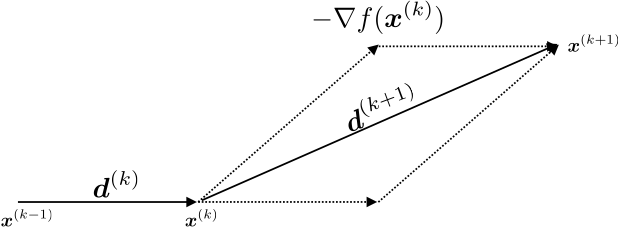


慣性項は，近年の深層学習における確率的勾配降下法（stochastic gradient descent, SGD）
において勾配方向のばらつきを抑えるために広く利用されている．

慣性項は，近年の深層学習における**確率的勾配降下法（Stochastic Gradient Descent, SGD）**において，勾配方向のばらつきを抑え，より効率的に収束するための工夫として広く用いられている．

- <https://pytorch.org/docs/stable/generated/torch.optim.SGD.html>
    > Implements stochastic gradient descent (optionally with momentum).
- <https://scikit-learn.org/stable/modules/sgd.html>
    > Stochastic Gradient Descent (SGD) is a simple yet very efficient approach


次に，慣性項を導入した勾配法の実装例を示す．


In [ ]:
def grad_decent_with_momentum(
        f: callable,
        g: callable,
        x0: np.ndarray,
        alpha: float = 0.1,
        mu: float = 0.9,
        maxiter: int = 100,
        callback: callable = None
) -> np.ndarray:
    """
    慣性項を利用した勾配法（Gradient Descent with Momentum）

    Args:
        f (callable): 目的関数 f(x)
        g (callable): 目的関数の勾配ベクトル g(x)
        x0 (np.ndarray): 初期値
        alpha (float): 学習率（ステップサイズ）
        mu (float): 慣性項の重み（モメンタム係数）
        maxiter (int): 最大反復回数
        callback (callable): 各反復ごとの状態を記録するための関数（オプション）

    Returns:
        np.ndarray: 最適解 \hat{x}
    """
    n = len(x0)
    assert len(g(x0)) == n

    x = x0.copy()
    d = np.zeros(n)
    for k in range(maxiter):
        gx = g(x)

        d = - gx + mu * d  # 過去の更新方向を慣性項として加算
        x = x + alpha * d  # 解を更新

        if callback:
            callback(x)

        if np.isclose(norm(gx), 0):
            return x

    return x


以下は，異なる慣性項重みを用いて最急降下法を実行した結果である．慣性項重みが大きい場合，更新方向の変化が緩やかになる．その結果，目的関数の値が急激に変化する領域で大きくオーバーシュートするような軌跡を描くことが観察される．

- 慣性項重みが小さい場合
   - 更新方向は主に現在の勾配情報に依存する．
   - 勾配のばらつきが大きい場合，収束までに多くの反復が必要になることがある．

- 慣性項重みが大きい場合
   - 更新方向は過去の方向をより強く考慮する．
   - 目的関数の急峻な変化に対してスムーズな応答を示すが，場合によってはオーバーシュートが発生しやすい．


In [ ]:
for mu in [0.9, 0.5]:

    callback_list = []

    x0_list = [
        np.array([-7.0, 7.0]),
        np.array([-4.0, 2.0]),
        np.array([0, 7.5]),
    ]
    for x0 in x0_list:

        cache_callback_gd_momentum = CacheXk(f, f.grad, x0, f"GD with momentum {mu}")

        x = grad_decent_with_momentum(
            f,
            f.grad,
            x0,
            alpha=1.0,
            mu=mu,
            callback=cache_callback_gd_momentum
        )
        print("x", x)
        print("f(x)", f(x))

        callback_list.append(cache_callback_gd_momentum)


    plot_cache = PlotCacheXk(callback_list)
    figs = plot_cache.plot_2d()



### 1.8.2. <a id='toc1_8_2_'></a>[Nesterovの加速勾配法](#toc0_)

1次の微分情報のみを利用する単純な最急降下法の収束を加速させる方法として**加速法**がある．その中でも，Nesterovの加速勾配法（Nesterov's Accelerated Gradient, NAG）は，慣性項を利用した手法に似ており，**Nesterov Momentum**と呼ばれることがある．

通常の勾配法では，現在の位置$\boldsymbol{x}^{(k)}$で勾配ベクトルを計算するが，NAGでは少し進んだ先の位置$\boldsymbol{y}^{(k)}$で勾配を計算する．このアイデアにより，より効率的な更新が可能になる．

直前の更新方向を$\boldsymbol{d}^{(k-1)}$，現在の解を$\boldsymbol{x}^{(k)}$とする．NAGでは，少し進んだ次の点を以下のように設定する．

$$
\boldsymbol{y}^{(k)} = \boldsymbol{x}^{(k)} + \mu^{(k)} \boldsymbol{d}^{(k-1)}
$$

この$\boldsymbol{y}^{(k)}$において，最急降下法と同様に勾配ベクトルを計算し，解を更新する．

$$
\boldsymbol{x}^{(k+1)} = \boldsymbol{y}^{(k)} - \alpha^{(k)} \nabla f(\boldsymbol{y}^{(k)})
$$

また，更新方向$\boldsymbol{d}^{(k)}$は以下のように定義される．

$$
\boldsymbol{d}^{(k)} = \boldsymbol{x}^{(k+1)} - \boldsymbol{x}^{(k)}
$$




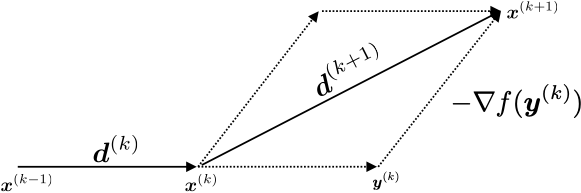


上記の手順をこれまでのような更新式と同様に書くと，以下のようにかける．

1. $\boldsymbol{d}^{(k)} = - \alpha^{(k)} \nabla f(\boldsymbol{x}^{(k)} + \mu^{(k)} \boldsymbol{d}^{(k-1)}) + \mu^{(k)} \boldsymbol{d}^{(k-1)}$
1. $\boldsymbol{x}^{(k+1)} = \boldsymbol{x}^{(k)} + \boldsymbol{d}^{(k)}$

ここで，$\mu^{(k)}$は慣性項の重みであり，通常は定数または以下のように設定されることがある．

- $\mu^{(k)} = \frac{k-1}{k+2}$




- <https://pytorch.org/docs/stable/generated/torch.optim.SGD.html?highlight=nesterov>
    > nesterov (bool, optional) – enables Nesterov momentum (default: False)


以下に，NAGの実装例を以下に示す．

In [ ]:
def nesterov_accel_grad(
        f: callable,
        g: callable,
        x0: np.ndarray,
        alpha: float = 0.1,
        maxiter: int = 100,
        callback: callable = None
) -> np.ndarray:
    """
    Nesterovの加速勾配法（Nesterov's Accelerated Gradient, NAG）

    Args:
        f (callable): 目的関数 f(x)
        g (callable): 目的関数の勾配ベクトル g(x)
        x0 (np.ndarray): 初期値
        alpha (float): 学習率（ステップサイズ）
        maxiter (int): 最大反復回数
        callback (callable): 各反復ごとの状態を記録するための関数（オプション）

    Returns:
        np.ndarray: 最適解 \hat{x}
    """
    n = len(x0)
    assert len(g(x0)) == n

    x = x0.copy()
    x_pre = x0.copy()
    d = np.zeros(n)

    for k in range(maxiter):
        mu_k = k / (k + 1)  # 慣性項重みを計算
        y = x + mu_k * d  # 少し進んだ点 y を計算
        x = y - alpha * g(y)  # y における勾配方向に基づいて更新
        d = x - x_pre  # 更新方向を計算
        x_pre = x.copy()

        if callback:
            callback(x)

        if np.isclose(norm(g(x)), 0):
            return x

    return x


以下はNAGを実行した例である．

In [ ]:
callback_list = []

x0_list = [
    np.array([-7.0, 7.0]),
    np.array([-4.0, 2.0]),
    np.array([0, 7.5]),
]
for x0 in x0_list:

    cache_callback_nag = CacheXk(f, f.grad, x0, f"NAG")

    x = nesterov_accel_grad(
        f,
        f.grad,
        x0,
        alpha=0.5,
        callback=cache_callback_nag
    )
    print("x", x)
    print("f(x)", f(x))

    callback_list.append(cache_callback_nag)


plot_cache = PlotCacheXk(callback_list)
figs = plot_cache.plot_2d()


## 1.9. <a id='toc1_9_'></a>[自動微分と深層学習フレームワーク](#toc0_)

これまでは，numpyの`ndarray`を利用して目的関数$f$を定義し，その勾配$\nabla f$やヘッセ行列$\nabla^2 f$を人手で計算して実装していた．

近年の深層学習でも，本質的な処理は同じであり，ニューラルネットワークの学習は目的関数（通常は損失関数）を勾配法で最小化することで行われる．しかし，現在の大規模なネットワークモデルでは，パラメータの数が数百万から数千億個にも達する．例えば，GPT-3は1750億個のパラメータを持つ（[参考リンク](https://xtech.nikkei.com/atcl/nxt/column/18/01428/092300002/)）．そのため，ネットワークモデルを数式として書き起こしたり，その微分を人間が導出したりすることは現実的ではない．

このような大規模かつ複雑な目的関数を効率的に最小化するため，深層学習フレームワークでは**自動微分（automatic differentiation）**が用いられている．

### 1.9.1. <a id='toc1_9_1_'></a>[微分の計算方法](#toc0_)

計算機で微分を計算する方法には，**数式微分**，**数値微分**，**自動微分**の3つがある．それぞれの特徴を以下に示す．

- **数式微分（Symbolic Differentiation）**
   数式をシンボリックに微分する方法である．数式処理システムとしては，[Mathematica](https://www.wolfram.com/mathematica/)や[WolframAlpha](https://www.wolframalpha.com/)が有名であり，Pythonでは`sympy`ライブラリが使用できる．
   複雑な数式の微分や積分をシンボリックに扱うことが可能であるが，大規模で複雑な目的関数では，微分結果を数値計算に適用することが困難である．
  - https://www.sympy.org/en/index.html

- **数値微分（Numerical Differentiation）**
   差分近似を用いて微分を計算する方法である．
   常微分方程式（ODE）や偏微分方程式（PDE）の数値解法で広く利用されている．
   しかし多次元の目的関数では計算量が増加し，近似精度が低下することがある．pythonでの数値微分にはfinddiffやnumdifftoolsなどがある．
  - https://github.com/maroba/findiff/
  - https://github.com/pbrod/numdifftools

- **自動微分（Automatic Differentiation）**
   関数をオブジェクトとして扱い，そのオブジェクトに微分のメソッドを実装する．連鎖律を利用して，すべての演算（四則演算や初等関数など）の微分値を計算する．現在の深層学習フレームワークで広く利用されており，
   高い精度で効率的な微分計算が可能で，大規模なモデルにも適用できる．
  - https://pytorch.org/
  - https://www.tensorflow.org/
  - https://github.com/google/flax
  - https://mxnet.apache.org/
  - https://dl.sony.com/ja/
  - https://learn.microsoft.com/ja-jp/cognitive-toolkit/
  - https://chainer.org/ (deprecated)
  - https://github.com/BVLC/caffe (deprecated)
  - https://github.com/Theano/Theano (deprecated)




### 1.9.2. <a id='toc1_9_2_'></a>[jax](#toc0_)

以下では，`jax`を利用した自動微分の基本的な使い方を説明する．  
`jax`は古いパッケージである[autograd](https://github.com/hips/autograd)の自動微分機能を発展させたものであり，深層学習フレームワークの[flax](https://github.com/google/flax)のバックエンドとして利用されている．

- https://github.com/google/jax
    > JAX is a Python library for accelerator-oriented array computation and program transformation, designed for high-performance numerical computing and large-scale machine learning.
- https://github.com/google/flax
    > Flax: A neural network library and ecosystem for JAX designed for flexibility

#### 1.9.2.1. <a id='toc1_9_2_1_'></a>[JAXのインストールと基本設定](#toc0_)

JAXがインストールされているかを確認するには，以下のコードを実行する．


In [ ]:
import jax


エラーが出なければ，すでに`jax`はインストールされている．インストールされていない場合は，公式マニュアルに従ってインストールを行う．以下はCPU用の最小構成のインストール例である．


In [ ]:
# !pip install "jax[cpu]"



なお，CSEのconda環境（Python 3.11）にはすでに`jax`がインストールされている．

- https://github.com/google/jax#installation

#### 1.9.2.2. <a id='toc1_9_2_2_'></a>[基本的な使い方](#toc0_)

ここでは，JAXの`numpy`互換機能を用いて，これまで説明してきた最適化コードを実行するための最低限の説明を行う．

JAXでは，通常の`numpy`の代わりに`jax.numpy`を使用する．以下のようにインポートすることで，`numpy`の機能とほぼ同じ方法で利用できる．
つまり，`np.***`を`jnp.***`に置き換えるだけでほとんどのコードが動く．


もしjaxのarrayをnumpyのndarrayに戻す必要がある場合には，
numpyの`np.asarray()`をjaxのarrayに適用する．


In [ ]:
import jax.numpy as jnp

# JAXのArrayを生成
x = jnp.arange(10)
print(x, type(x))

# JAXとNumPyの違いを確認
x_jax = jnp.array([1.0, 2.3])
print(x_jax, type(x_jax))

x_np = np.array([1.0, 2.3])
print(x_np, type(x_np))


JAXの`Array`型はNumPyの`ndarray`型と非常に似ているが，変更できない（代入不可）という違いがある．
ただし今回の使い方では代入することはないため，問題ではない．

以下の例では，NumPyのArrayは要素の変更が可能であるが，JAXのArrayではエラーが発生する．

In [ ]:
# NumPyの配列の要素を変更
x_np[0] = 0
print(x_np)

# JAXの配列の要素を変更（エラーが発生）
x_jax[0] = 0  # これはエラー
print(x_np)


なおJAXの`Array`をNumPyの`ndarray`に戻す場合は，`np.asarray()`を使用する．これにより，ほとんどの操作が互換的に行える．

In [ ]:
# JAXのArrayをNumPyのndarrayに変換
x_jax_to_np = np.asarray(x_jax)
print(x_jax_to_np, type(x_jax_to_np))

### 1.9.3. <a id='toc1_9_3_'></a>[jaxを用いた目的関数クラスの実装](#toc0_)

ここでは，`jax`を用いて目的関数を実装する方法を説明する．
（注意：以下の実装方法は`jax`の一般的な使用法ではない．これまで説明してきた最適化手法に合わせたコードを`jax`で記述しているため，パフォーマンスが低下する可能性がある．効率的な実装方法については`jax`の公式ドキュメントを参照のこと．）

#### 1.9.3.1. <a id='toc1_9_3_1_'></a>[基底クラス](#toc0_)

まず，目的関数の基底クラスを定義する．このクラスでは，関数呼び出し，微分，ヘッセ行列の計算のみを実装し，関数本体は派生クラスで定義することを想定している．

`jax`では，以下の関数を用いて自動微分を実現する．

1. **勾配の計算**
   `jax.grad(f)`を用いることで，関数`f`の導関数（勾配）を計算する関数を定義できる．
   例えば，`g = jax.grad(f)`とすると，`g(x)`を呼び出すことで`f(x)`の勾配が計算される．

2. **ヘッセ行列の計算**
   `jax.hessian(f)`を用いることで，関数`f`のヘッセ行列を計算できる．
   これは勾配の勾配（2階微分）を効率的に計算する．


- https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html
    > Creates a function that evaluates the gradient of fun.
- https://jax.readthedocs.io/en/latest/_autosummary/jax.hessian.html
    > Hessian of fun as a dense array.
  - https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html#jacobians-and-hessians-using-jacfwd-and-jacrev
    - `jaxfwd`と`jacrev`を用いた`jax.hessian`の実装方法の説明

以下に基底クラスの実装例を示す．


In [ ]:
class FunctionJax():
    """
    JAXを用いた基底クラス．目的関数を派生クラスで定義する．
    """

    def __init__(self):
        self.g = jax.grad(self.forward)
        self.H = jax.hessian(self.forward)

    def forward(self, x: jnp.ndarray) -> float:
        """
        目的関数f(x)を定義するためのインターフェース．
        派生クラスでこのメソッドを実装する必要がある．
        """
        raise NotImplementedError

    def __call__(self, x: jnp.ndarray) -> float:
        """f(x)の値を計算"""
        return self.forward(x)

    def grad(self, x: jnp.ndarray) -> jnp.ndarray:
        """f(x)の勾配を計算"""
        return self.g(x)

    def hessian(self, x: jnp.ndarray) -> jnp.ndarray:
        """f(x)のヘッセ行列を計算"""
        return self.H(x)


#### 1.9.3.2. <a id='toc1_9_3_2_'></a>[実際に使用する派生クラス](#toc0_)

目的関数を具体的に定義するには，基底クラスを継承し，`forward`メソッドを実装するだけでよい．微分やヘッセ行列の計算は`jax`が自動的に行うため，追加の定義は不要である．

以下は，非凸関数`NonConvexFunction`を`jax`に置き換えた例である．ここでの注意点は，`numpy`や`math`モジュールの関数は利用できない点である．すべての計算は`jax.numpy`（`jnp`）の関数を使用する必要がある．


In [ ]:
class NonConvexFunctionJax(FunctionJax):
    """非凸関数のjax実装バージョン．

    https://www.wolframalpha.com/input?i=Plot%5B%7B2+%28x%2B1%29%5E2+%2B+2+%28y%2B1%29%5E2+%2B+2%28x%2B1%29+%28y%2B1%29+-+2.5%28x%2B1%29+-+2.5+%28y%2B1%29++%2B+250+exp%28-%28%28x-2%29%5E2+%2B+%28y-2%29%5E2%29%2F30%29+%7D%2C+%7Bx%2C+-10%2C+10%7D%2C+%7By%2C+-10%2C+10%7D%5D&lang=ja
    """

    def forward(self, x: jnp.ndarray) -> float:
        assert x.ndim == 1 and len(x) == 2

        return (
            2 * (x[0] + 1)**2 \
            + 2 * (x[1] + 1)**2 \
            + 2 * (x[0] + 1) * (x[1] + 1) \
            - 2.5 * (x[0] + 1) \
            - 2.5 * (x[1] + 1) \
            + 250 * jnp.exp(-((x[0] - 2)**2 + (x[1] - 2)**2) / 30) \
            + 100) / 60


### 1.9.4. <a id='toc1_9_4_'></a>[jaxとnumpyの比較](#toc0_)

ここでは，`jax`版と`numpy`版の目的関数を比較する．それぞれの目的関数インスタンスを作成し，同じ入力に対して関数値，勾配，ヘッセ行列を計算する．

まず，`jax`版のインスタンス`f`と`numpy`版のインスタンス`f_nonjax`を作成する．

In [ ]:
f_nonjax = NonConvexFunction()  # numpy版の目的関数
f = NonConvexFunctionJax()      # jax版の目的関数


#### 1.9.4.1. <a id='toc1_9_4_1_'></a>[jax版の計算](#toc0_)

`jax`版の目的関数`f`には，`jax.numpy`（`jnp`）の配列を引数として与える必要がある．以下は，入力$x$に対して関数値，勾配，ヘッセ行列を計算するコード例である．


In [ ]:
# jax版の入力を定義
x = jnp.array([1.0, 2.0])

# 関数値，勾配，ヘッセ行列を表示
print("f(x)", f(x))            # 関数値
print("g(x)", f.grad(x))       # 勾配
print("H(x)\n", f.hessian(x))  # ヘッセ行列


ここで注意すべき点は，関数値`f(x)`の出力はスカラーであるが，`jax`の`array`型として返されることである．この形式は自動微分に必要な追加情報を保持している．


#### 1.9.4.2. <a id='toc1_9_4_2_'></a>[numpy版の計算](#toc0_)

確認のために，上記の手順を
`numpy`版の目的関数`f_nonjax`で同様に行う．これには，通常の`numpy`の配列を引数として与える．以下は，`jax`版と同様の計算を`numpy`版で行う例である．


In [ ]:
# numpy版の入力を定義
x = np.array([1.0, 2.0])

# 関数値，勾配，ヘッセ行列を表示
print("f(x)", f_nonjax(x))            # 関数値
print("g(x)", f_nonjax.grad(x))       # 勾配
print("H(x)\n", f_nonjax.hessian(x))  # ヘッセ行列

関数値，勾配，ヘッセ行列の値はnumpy版とjax版で同一であることが確認できる．

### 1.9.5. <a id='toc1_9_5_'></a>[jax版の目的関数に対する最適化の実行例](#toc0_)

ここでは，`jax`版の目的関数`f`を用いて最適化を実行する．
`jax`版は入力を`jnp.Array`型に変更するだけであるため，目的関数を`jax`版に置き換えるだけで，他のコード（最適化ソルバーやコールバック関数など）を変更せずに利用できる（`np`に依存した機能を使っていない場合）．

さらに，高速化のために，最適化ソルバーに与える目的関数`f`とその勾配`f.grad`，およびヘッセ行列`f.hessian`を`jax`の**JIT（Just-in-Time）コンパイル**でコンパイルして利用する．これにより，計算の効率が大幅に向上する．


In [ ]:
f = NonConvexFunctionJax()

以下のコードでは，`jax`のJITコンパイルされた目的関数とその勾配を用いて，NAG法を実行する．

In [ ]:
# x0 = jnp.array([-4.0, 2.0])
x0 = jnp.array([0, 7.5])
cache_callback_nag_jax = CacheXk(jax.jit(f), jax.jit(f.grad), x0, "NAG with jax")
x = nesterov_accel_grad(
    jax.jit(f),
    jax.jit(f.grad),
    x0,
    alpha=0.5,
    callback=cache_callback_nag_jax
)
print("x", x)
print("f(x)", f(x))

plot_cache = PlotCacheXk([cache_callback_nag_jax])
figs = plot_cache.plot_2d()


次に，JITコンパイルされた目的関数，その勾配，およびヘッセ行列を用いてニュートン法を実行する．

In [ ]:
# x0 = jnp.array([-4.0, 2.0])
x0 = jnp.array([0, 7.5])
cache_callback_newton_jax = CacheXk(jax.jit(f), jax.jit(f.grad), x0, "Newton's method with jax")
x = newton_method(
    jax.jit(f),
    jax.jit(f.grad),
    jax.jit(f.hessian),
    x0,
    alpha=0.1,
    callback=cache_callback_newton_jax
)
print("x", x)
print("f(x)", f(x))

plot_cache = PlotCacheXk([cache_callback_newton_jax])
figs = plot_cache.plot_2d()


最後に，JITコンパイルされた目的関数とその勾配を用いて共役勾配法（CG法）を実行する．

In [ ]:
# x0 = jnp.array([-4.0, 2.0])
x0 = jnp.array([0, 7.5])
cache_callback_cg_jax = CacheXk(jax.jit(f), jax.jit(f.grad), x0, "CG with jax")
x = conjugate_gradient(
    jax.jit(f),
    jax.jit(f.grad),
    x0,
    alpha=0.1,
    callback=cache_callback_cg_jax
)
print("x", x)
print("f(x)", f(x))

plot_cache = PlotCacheXk([cache_callback_cg_jax])
figs = plot_cache.plot_2d()


## 1.10. <a id='toc1_10_'></a>[機械学習・深層学習と計算精度・コスト](#toc0_)


### 1.10.1. <a id='toc1_10_1_'></a>[概要：損失関数の最小化](#toc0_)


深層学習を含む機械学習では，学習データ$\boldsymbol{x}_i$とそのラベル$y_i$からなる学習データセット

$$
D_{\mathrm{train}} = \{ \boldsymbol{x}_i, y_i \}_{i=1}^{N_{\mathrm{train}}}
$$

が与えられる．これに基づいて，パラメータ$\boldsymbol{\theta}$を持つモデル$f$が予測する値$\hat{y} = f(\boldsymbol{x}; \boldsymbol{\theta})$と，正解ラベルとの間の差を評価する経験損失関数（Empirical Loss Function）

$$
\mathcal{L}_{\mathrm{train}} = \frac{1}{N_{\mathrm{train}}} \sum_{i=1}^{N_{\mathrm{train}}} L(y_i, f(\boldsymbol{x}_i; \boldsymbol{\theta}))
$$

を最小化する問題として学習を行う．これは次式で表される．

$$
\min_{\boldsymbol{\theta}} \ \mathcal{L}_{\mathrm{train}}
$$

（なお，これまでは最適化する変数を$\boldsymbol{x}$と表記してきたが，ここではモデルのパラメータを$\boldsymbol{\theta}$と記述しているため，混同しないように注意すること．）

#### 1.10.1.1. <a id='toc1_10_1_1_'></a>[損失関数の種類](#toc0_)

ここで損失関数$L(y_i, \hat{y}_i)$は，各データ$i$における正解ラベル$y_i$とモデル予測値$\hat{y}_i$の差異を定量化するものである．タスクによって異なる損失関数が使用される．例えば以下のようなものが代表的な損失である．

- 多クラス分類問題では，交差エントロピー損失（Cross Entropy Loss）が一般的に使用される．
  - https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
      > This criterion computes the cross entropy loss between input logits and target.
- 連続値予測問題では，平均二乗誤差（Mean Squared Error, MSE）がよく用いられる．
  - https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html
      > Creates a criterion that measures the mean squared error (squared L2 norm) between each element in the input


#### 1.10.1.2. <a id='toc1_10_1_2_'></a>[汎化性能の評価](#toc0_)


モデルの性能を評価する際には，**学習データセット**の損失を最小化するように学習された最適なパラメータ

$$
\boldsymbol{\theta}^* =
\mathrm{argmin}_{\boldsymbol{\theta}} \ \mathcal{L}_{\mathrm{train}}
$$

を用いる．そして，このパラメータを用いて**評価データセット**$D_{\mathrm{val}}$に対する損失

$$
\mathcal{L}_{\mathrm{val}} = \frac{1}{N_{\mathrm{val}}} \sum_{i=1}^{N_{\mathrm{val}}} L(y_i, f(\boldsymbol{x}_i; \boldsymbol{\theta}^*))
$$

や認識率$\mathrm{Acc}_{\mathrm{val}}$などを計算する．

学習データセットとは別の評価データセットを用いる理由は，モデルの汎化能力（学習データ以外のデータに対する適応力）が重要であるためである．汎化性能の高いモデルは，未知のデータに対しても高い認識性能を発揮する．



### 1.10.2. <a id='toc1_10_2_'></a>[最適化と機械学習の違い：最小化か汎化性能か](#toc0_)

機械学習において，本当に最小化したいものは**汎化誤差**である．これは評価データセットの損失関数$\mathcal{L}_{\mathrm{val}}$や，より一般的には期待損失

$$
E_{\boldsymbol{x}, y}[L(y, f(\boldsymbol{x}; \boldsymbol{\theta}))]
$$

として表される．しかし，実際に最小化しているのは**訓練誤差**（学習データセットの損失関数$\mathcal{L}_{\mathrm{train}}$）である．

この違いから，学習データセットの損失$\mathcal{L}_{\mathrm{train}}$を完全に最小化したとしても，汎化性能が向上するとは限らない．むしろ，学習データへの過度な適合（**過学習**）が発生し，汎化性能が低下してしまうことが一般的である．

一方で，**一般的な最適化問題**では，目的関数をできるだけ正確に最小化することが最終的なゴールである．そのため，計算誤差の少ないアルゴリズムを採用し，`float64`などの高精度なデータ型を使用して計算を行い，収束条件を厳密に設定することが求められる．


#### 1.10.2.1. <a id='toc1_10_2_1_'></a>[深層学習における計算精度とコスト](#toc0_)

このような違いのため，機械学習や深層学習では，学習時の損失関数の最小化を厳密に行うことはあまり重要ではない．そのため，以下のような軽量で効率的な計算手法が採用されることが多い．

1. **低精度実数値型の使用**
   深層学習では通常，実数変数の型は`float32`が使用される．さらに，計算精度が低いがメモリ使用量を削減でき，計算速度も向上するfp16やbf16などの16ビットの浮動小数点表現が採用されることも多い．これらのデータ型は，メモリ効率を向上させるだけでなく，演算の高速化にも寄与する．
   - **fp16**: 半精度浮動小数点（[IEEE 754 binary16](https://ja.wikipedia.org/wiki/%E5%8D%8A%E7%B2%BE%E5%BA%A6%E6%B5%AE%E5%8B%95%E5%B0%8F%E6%95%B0%E7%82%B9%E6%95%B0)）．
   - **bf16**: Brain Floating Pointとして知られる[bfloat16](https://en.wikipedia.org/wiki/Bfloat16_floating-point_format)．
   - https://pytorch.org/docs/stable/notes/numerical_accuracy.html#reduced-precision-reduction-for-fp16-and-bf16-gemms
        > Half-precision GEMM operations are typically done with intermediate accumulations (reduction) in single-precision for numerical accuracy and improved resilience to overflow．

2. **混合精度（Mixed Precision）**
    一部の計算に`fp16`や`bf16`を使用しながら，他の部分では`fp32`を使用する場合がある．このような手法を**混合精度計算**と呼ぶ．混合精度計算では，低精度データ型を利用することで効率性を向上させつつ，高精度データ型を適宜使用して数値的な安定性を確保する．
    混合精度を効率的に扱うために，自動的に精度変換を行う仕組みが利用される．例えば，NVIDIAが提供する[Automatic Mixed Precision (AMP)](https://developer.nvidia.com/automatic-mixed-precision)は，`fp16`と`fp32`の変換を内部で自動的に行う．
    - https://pytorch.org/docs/stable/amp.html
        > torch.amp provides convenience methods for mixed precision, where some operations use the torch.float32 (float) datatype and other operations use lower precision floating point datatype (lower_precision_fp): torch.float16 (half) or torch.bfloat16．




### 1.10.3. <a id='toc1_10_3_'></a>[深層学習では1次の勾配法を用いる](#toc0_)

これまでの説明では，最適化の収束の様子を2次元の問題として示してきた．これは，最適化で求めるパラメータ数を2個に限定した場合である．一般的な最適化問題では，パラメータ数が数百個から数千個に及ぶことも珍しくなく，そのような高次元の問題に対応するために，L-BFGSなどの手法が発展してきた．

一方で，深層学習ではそれを大きく超える次元数の最適化が必要になる．現在のネットワークモデルでは，パラメータ数が数百万から数千億個に達する．たとえば，GPT-3のパラメータ数は1750億個である（[参考リンク](https://xtech.nikkei.com/atcl/nxt/column/18/01428/092300002/)）．このような膨大なパラメータ数により，計算コストとメモリ使用量は非常に大きくなる．特にヘッセ行列はパラメータ数$N$に対して$O(N^2)$となるため，ニュートン法などのヘッセ行列を用いる手法は現実的ではない．

たとえば，[AlexNet](https://pytorch.org/hub/pytorch_vision_alexnet/)と呼ばれる初期の畳み込みニューラルネットワーク（CNN）には約6000万個のパラメータがある（[参考リンク](https://stackoverflow.com/questions/40060949/how-to-calculate-the-number-of-parameters-of-alexnet)）．これを`fp16`（16ビット，2バイト）で表した場合，勾配ベクトルの保持には約117MBが必要であるが，ヘッセ行列の保持には約7PB（ペタバイト）ものメモリが必要となる．以下は計算例である．


In [ ]:
N = 60_000_000  # パラメータ数
bytes_per_parameter = 2  # fp16: 2バイト
print("gradient needs memory of", N * bytes_per_parameter / 10**6, "MB")
print(
    "Hessian needs memory of", N**2 * bytes_per_parameter / 10**12, "TB"
    " =", N**2 * bytes_per_parameter / 10**15, "PB"
)


#### 1.10.3.1. <a id='toc1_10_3_1_'></a>[1次の勾配法の利用](#toc0_)

このようなメモリ使用量の制約から，深層学習では1次の勾配情報のみを用いる手法が一般的である．具体的には，以下のような方法が使用される．

1. 確率的勾配降下法（Stochastic Gradient Descent, SGD）
   勾配法に慣性項を加えたバリエーションがよく用いられる．
   - 慣性項を加えることで，更新方向が平滑化され，収束が安定する．

2. 動的なステップサイズの変更
    - 学習率を動的に調整する手法として，以下のようなものがある．
      - [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)
          > Implements the Adam algorithm．
      - [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html)
          > Implements the AdamW algorithm．
    - 学習率を変更するスケジュールを手動で設定する方法もある．

これらの方法は，高次元の最適化問題に適用できる最急降下法をより効率的にする工夫であり，深層学習において標準的に利用されている．


### 1.10.4. <a id='toc1_10_4_'></a>[深層学習では確率的勾配法を用いる](#toc0_)

深層学習において，勾配法によるパラメータ更新は以下の更新式に従う．

\begin{align*}
\boldsymbol{\theta}^{(k+1)} & \leftarrow \boldsymbol{\theta}^{(k)} - \alpha \frac{\partial \mathcal{L}_{\mathrm{train}}}{\partial\boldsymbol{\theta}}
\end{align*}

ここで，損失関数$\mathcal{L}_{\mathrm{train}}$の勾配は次のように計算される．

\begin{align*}
\frac{\partial \mathcal{L}_{\mathrm{train}}}{\partial\boldsymbol{\theta}}
&= \frac{1}{N_{\mathrm{train}}} \sum_{i=1}^{N_{\mathrm{train}}}
\frac{\partial}{\partial\boldsymbol{\theta}}
L(y_i, f(\boldsymbol{x}_i; \boldsymbol{\theta}))
\end{align*}

これは，各学習データ$\boldsymbol{x}_i$における損失の勾配を平均したものである．


#### 1.10.4.1. <a id='toc1_10_4_1_'></a>[確率的勾配法の必要性](#toc0_)

この手法が問題となるのは，学習データセットが大規模な場合である．
たとえば，一回のパラメータ更新のために$N_{\mathrm{train}}$個のデータに対する損失関数の勾配をすべて計算し，総和する必要がある．しかし，データセットが大規模である場合，この計算は現実的ではない．以下は代表的なデータセットの規模の例である．

- **[ImageNet-21k](https://www.image-net.org/index.php)**: 一般的に画像認識のベンチマークとして用いられているデータセットで，約1400万枚の画像からなる．（サブセットである[ImageNet-1k](https://www.image-net.org/challenges/LSVRC/index.php)でも約100万枚の画像がある）
- **[LAION-5B](https://laion.ai/blog/relaion-5b/)**: 約58億枚の画像からなるデータセット（画像生成AIの[Stable Diffusion](https://ja.stability.ai/stable-diffusion)の学習に使用されたデータセット）．

このような大規模データセットでは，勾配法による1回の反復計算だけでも非常に高い計算コストがかかる．


#### 1.10.4.2. <a id='toc1_10_4_2_'></a>[確率的勾配降下法（SGD）](#toc0_)

この問題を解決するために，確率的勾配降下法（Stochastic Gradient Descent, SGD）が用いられる．SGDでは，学習データセット全体の損失を平均するのではなく，各学習データの損失に基づいてパラメータを逐次更新する．その更新式は次のように表される．


\begin{align*}
\boldsymbol{\theta}^{(i+1)} & \leftarrow \boldsymbol{\theta}^{(i)} - \alpha \frac{\partial}{\partial\boldsymbol{\theta}}
L(y_i, f(\boldsymbol{x}_i; \boldsymbol{\theta}))
\end{align*}

ここで，学習データ$i=1, \ldots, N_{\mathrm{train}}$について順次更新を行い，$i=N_{\mathrm{train}}$に到達すると，学習データ全体を1回使用したことになる．この1回の単位を**エポック（epoch）**と呼ぶ．エポックが終了したら，再び$i=1$からデータセットを利用して更新を繰り返す．


#### 1.10.4.3. <a id='toc1_10_4_3_'></a>[ミニバッチSGD](#toc0_)

実際には，学習データを1つずつ更新するのではなく，複数のデータをまとめて使用することが一般的である．このように，1回の勾配計算に用いる学習データの集合を**バッチ（またはミニバッチ）**と呼ぶ．バッチサイズを変更することで，計算コストとメモリ使用量のバランスを調整できる．

- https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
  > Implements stochastic gradient descent (optionally with momentum).
